Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data prostate
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/prostate_TumorVSNormal_test.data"
url_train = "https://raw.githubusercontent.com/jamessaldo/final-task/master/prostate_TumorVSNormal_train.data"
data_train = pd.read_csv(url_train, header=None)
data_test = pd.read_csv(url_test, header=None)
data_prostate = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Prostate Tumor:',data_prostate.isnull().sum().sum())

Total Missing Value pada Data Prostate Tumor: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data prostate
data_new_prostate = data_prostate.drop([12600],axis=1)
scaler = MinMaxScaler()
data_new_prostate = scaler.fit_transform(data_new_prostate)
data_new_prostate = DataFrame(data_new_prostate)
data_new_prostate['label'] = list(data_prostate[12600])
dic = {'Normal':0,'Tumor':1}
data_new_prostate.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Prostate Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA


>
/
Name
Last Modified

# 3. Feature Selection with IG

## Prostate

In [9]:
data_X = data_new_prostate.drop(['label'],axis=1)
data_Y = data_new_prostate['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Prostate_IG = pd.DataFrame(data_X_new)
Prostate_IG['label'] = data_Y
useddata_prostate = Prostate_IG
print(useddata_prostate.shape)
Prostate_IG

(136, 101)


0         1         2         3         4         5         6  \
0    0.033305  0.064040  0.085265  0.060130  0.078720  0.034029  0.053165   
1    0.000000  0.044543  0.080677  0.072141  0.090349  0.040425  0.052957   
2    0.059351  0.017247  0.082734  0.081604  0.064407  0.012171  0.063368   
3    0.078708  0.015048  0.040259  0.047827  0.059835  0.013413  0.037340   
4    0.091944  0.030245  0.087084  0.067628  0.080012  0.035209  0.048723   
..        ...       ...       ...       ...       ...       ...       ...   
131  0.613293  0.440034  0.609745  0.644464  0.628864  0.470442  0.476471   
132  0.604042  0.367245  0.523214  0.519182  0.604910  0.402571  0.341755   
133  0.780387  0.395591  0.451554  0.495086  0.643872  0.346560  0.351541   
134  0.888414  0.349848  0.440718  0.510446  0.517543  0.434302  0.369933   
135  0.648876  0.393841  0.503203  0.545461  0.631846  0.322218  0.363201   

            7         8         9  ...        91        92        93  \
0    0.050074  0.019817  0.017677  ...  0.012753  0.030769  0.024859   
1    0.060383  0.007622  0.025253  ...  0.019505  0.038462  0.015819   
2    0.058910  0.019055  0.037879  ...  0.019505  0.056073  0.024294   
3    0.055965  0.044207  0.063131  ...  0.010503  0.039069  0.055367   
4    0.066274  0.010671  0.020202  ...  0.036759  0.044332  0.023729   
..        ...       ...       ...  ...       ...       ...       ...   
131  0.689249  0.595274  0.613636  ...  0.706677  0.397773  0.307345   
132  0.637703  0.557165  0.646465  ...  0.647412  0.358704  0.299435   
133  0.721649  0.727134  0.611111  ...  0.713428  0.380567  0.255367   
134  0.805596  0.523628  0.621212  ...  0.601650  0.415385  0.442373   
135  0.606775  0.671494  0.628788  ...  0.624906  0.332996  0.320339   

           94        95        96        97        98        99  label  
0    0.049860  0.067010  0.030585  0.017817  0.042419  0.041975      1  
1    0.062478  0.099656  0.035239  0.017817  0.079874  0.037037      1  
2    0.025237  0.066151  0.017287  0.011136  0.069043  0.037037      1  
3    0.028654  0.047251  0.033245  0.022272  0.044224  0.044444      1  
4    0.042324  0.096220  0.031915  0.014477  0.046480  0.046914      1  
..        ...       ...       ...       ...       ...       ...    ...  
131  0.573870  0.364261  0.444814  0.664811  0.167870  0.760494      0  
132  0.533211  0.283505  0.352394  0.432071  0.187274  0.664198      0  
133  0.510077  0.259450  0.628324  0.585746  0.154332  0.837037      0  
134  0.512180  0.265464  0.456117  0.623608  0.141245  0.602469      0  
135  0.570890  0.434708  0.317819  0.575724  0.223827  0.427160      0  

[136 rows x 101 columns]

# 4. Classification

## Prostate + IG

Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  0.5714285714285714
F1_Score :  0.36363636363636365
              precision    recall  f1-score   support

           0     

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


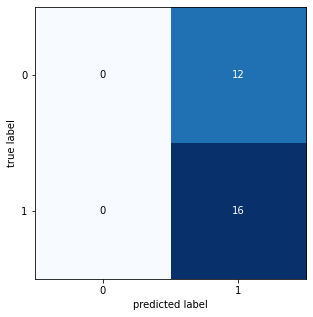

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

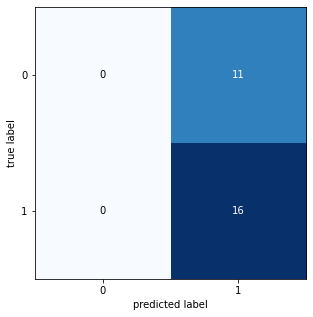

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

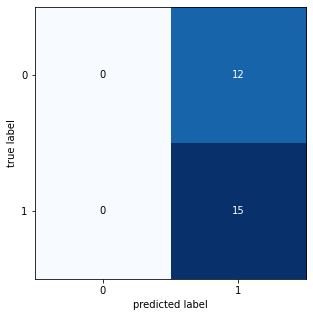

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

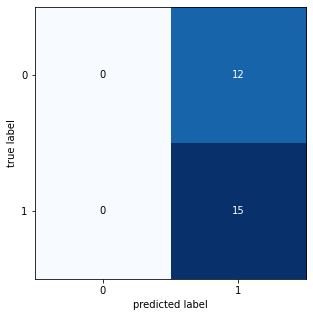

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

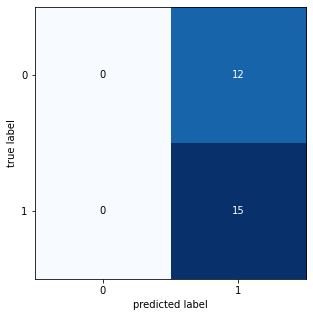

avg accuraccy Prostate cancer =  0.5661375661375662
avg F1_Score Prostate cancer =  0.36143159166414984
max accuraccy Prostate cancer =  0.5925925925925926
max F1_Score Prostate cancer =  0.37209302325581395
min accuraccy Prostate cancer =  0.5555555555555556
min F1_Score Prostate cancer =  0.35714285714285715
Running Time:  40.17150781999953


(0.5661375661375662, 0.36143159166414984)

In [10]:
FLNN_Classifier(Prostate_IG,"Prostate cancer",2)

Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  0.5714285714285714
F1_Score :  0.36363636363636365
              precision    recall  f1-score   support

           0     

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


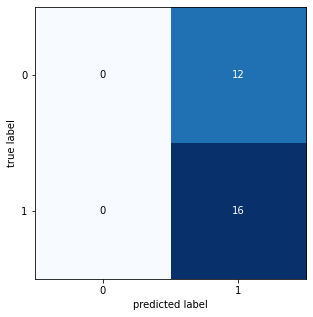

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

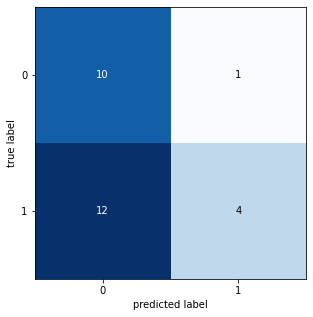

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

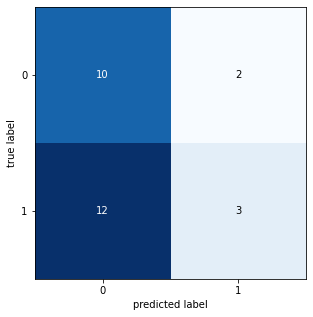

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

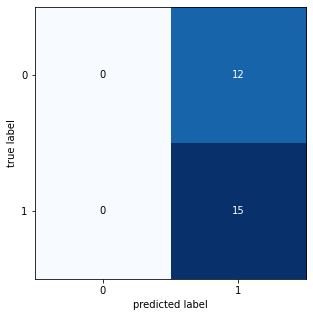

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

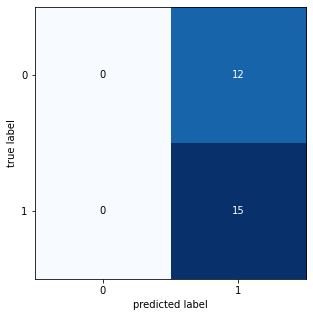

avg accuraccy Prostate cancer =  0.5365079365079364
avg F1_Score Prostate cancer =  0.40310924369747897
max accuraccy Prostate cancer =  0.5714285714285714
max F1_Score Prostate cancer =  0.4935064935064935
min accuraccy Prostate cancer =  0.48148148148148145
min F1_Score Prostate cancer =  0.35714285714285715
Running Time:  35.66615070900298


(0.5365079365079364, 0.40310924369747897)

In [11]:
FLNN_Classifier(Prostate_IG,"Prostate cancer",3)

Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  0.5714285714285714
F1_Score :  0.36363636363636365
              precision    recall  f1-score   support

           0     

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


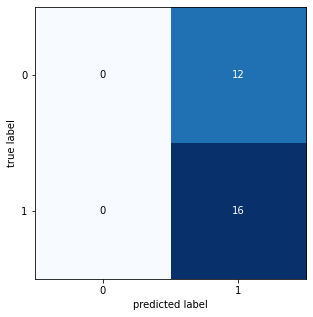

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

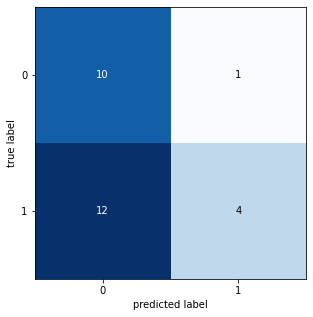

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

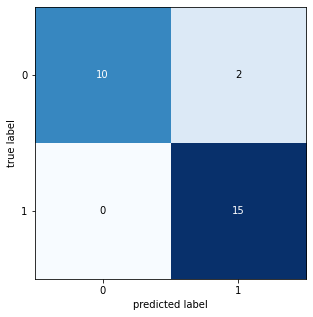

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

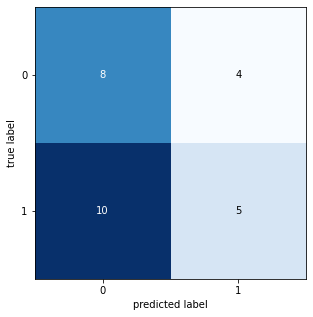

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

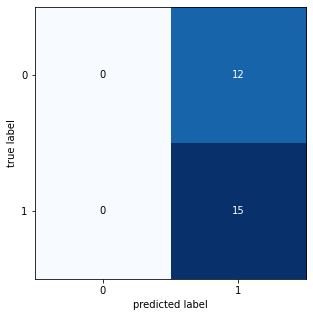

avg accuraccy Prostate cancer =  0.6105820105820106
avg F1_Score Prostate cancer =  0.5225162337662338
max accuraccy Prostate cancer =  0.9259259259259259
max F1_Score Prostate cancer =  0.9232954545454546
min accuraccy Prostate cancer =  0.48148148148148145
min F1_Score Prostate cancer =  0.35714285714285715
Running Time:  30.633483026002068


(0.6105820105820106, 0.5225162337662338)

In [12]:
FLNN_Classifier(Prostate_IG,"Prostate cancer",4)

## Prostate + IG + GA

Generation : 0
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 

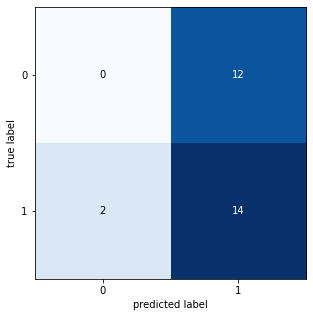

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


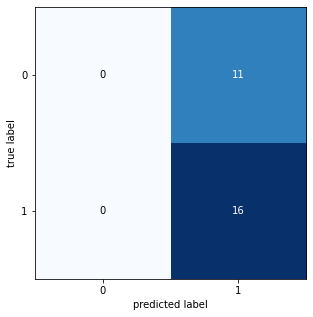

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5
              precision    recall  f1-score   support

           0       0.50      1.0

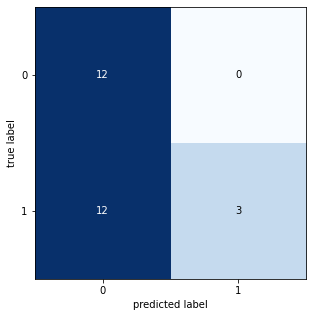

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7407407407407407
F1_Score :  0.7157894736842105
              precision    recall  f1-score   support

           0     

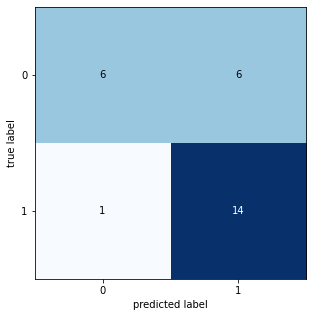

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

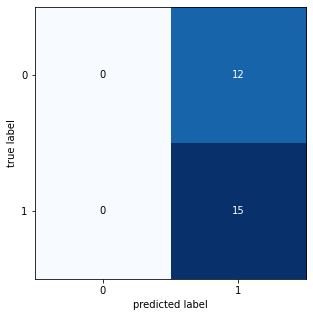

avg accuraccy Prostate Cancer =  0.5888888888888889
avg F1_Score Prostate Cancer =  0.45567173748324297
max accuraccy Prostate Cancer =  0.7407407407407407
max F1_Score Prostate Cancer =  0.7157894736842105
min accuraccy Prostate Cancer =  0.5
min F1_Score Prostate Cancer =  0.33333333333333337
Running Time:  40.58239247900201
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


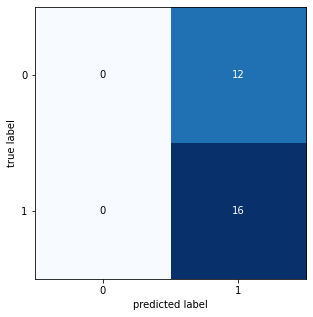

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

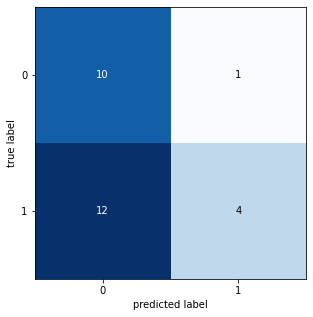

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

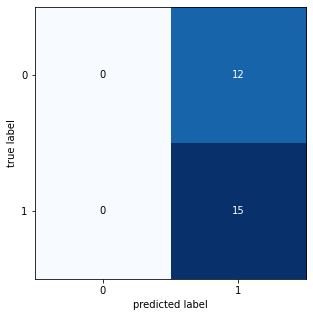

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.6447368421052632
              precision    recall  f1-score   support

           0     

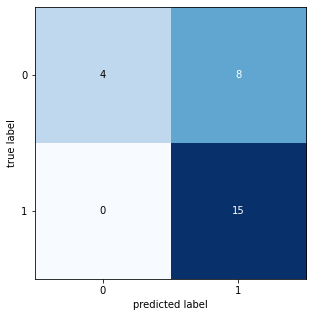

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

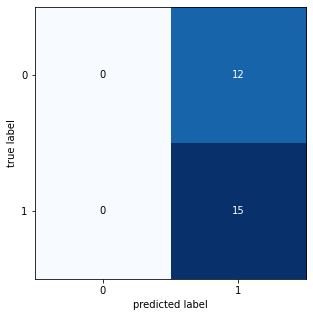

avg accuraccy Prostate Cancer =  0.5809523809523809
avg F1_Score Prostate Cancer =  0.443233082706767
max accuraccy Prostate Cancer =  0.7037037037037037
max F1_Score Prostate Cancer =  0.6447368421052632
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.60617478899803
gene : [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

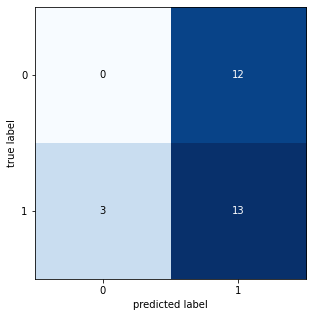

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


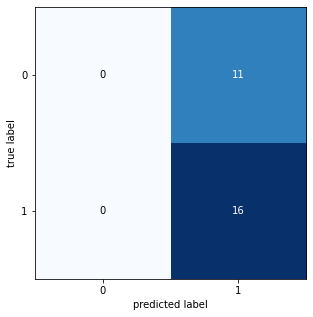

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

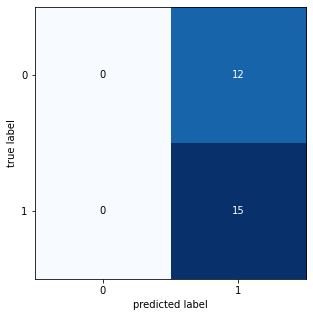

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

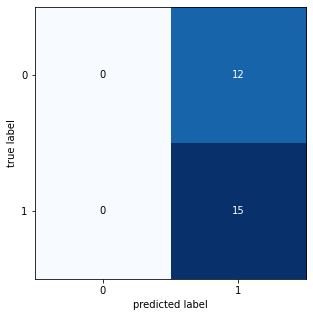

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

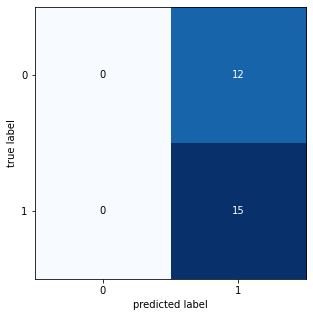

avg accuraccy Prostate Cancer =  0.5447089947089948
avg F1_Score Prostate Cancer =  0.3521189530832186
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.4642857142857143
min F1_Score Prostate Cancer =  0.3170731707317073
Running Time:  40.789499512000475
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


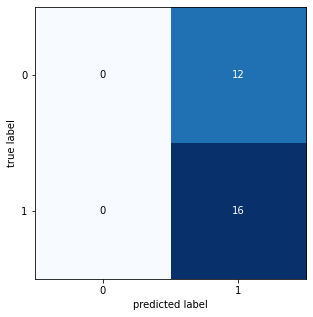

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

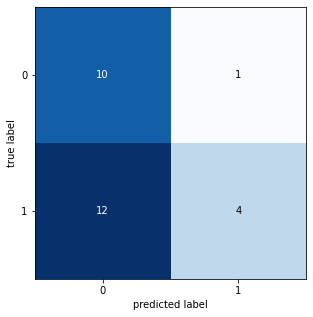

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

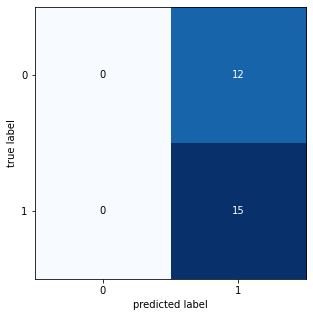

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

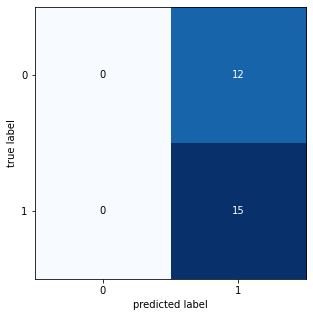

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

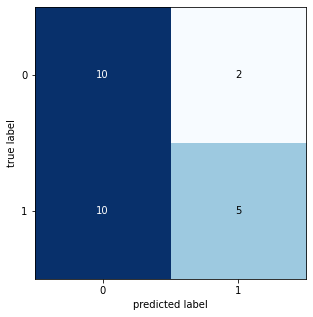

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.42224025974025975
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.26123206399643
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

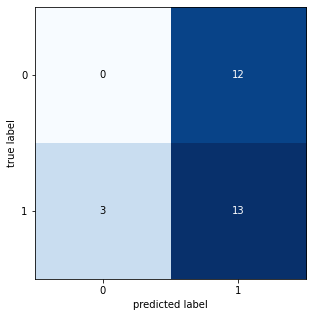

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


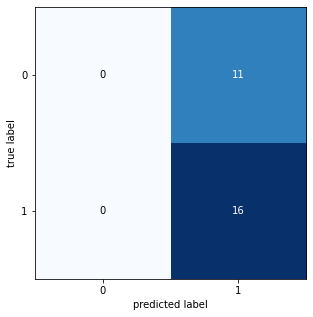

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

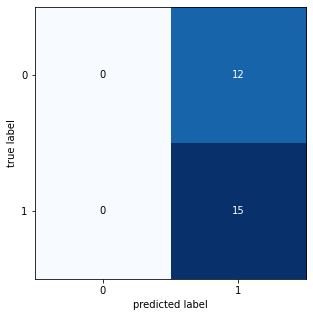

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

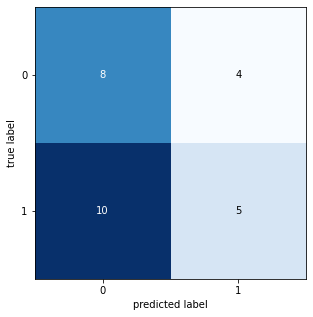

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

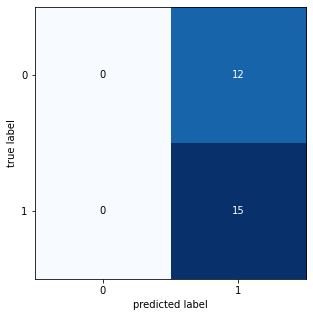

avg accuraccy Prostate Cancer =  0.5298941798941799
avg F1_Score Prostate Cancer =  0.3756903816546472
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.4642857142857143
min F1_Score Prostate Cancer =  0.3170731707317073
Running Time:  40.68618977800361
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


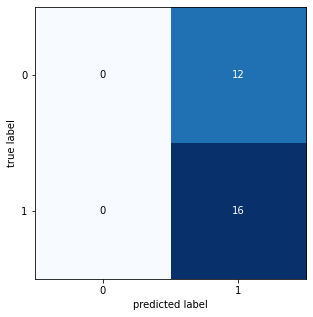

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

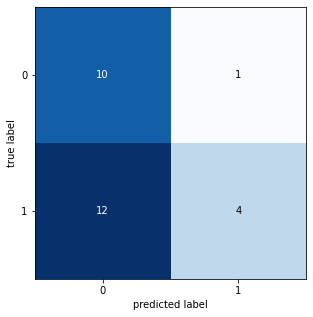

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.4444444444444444
F1_Score :  0.4155844155844156
              precision    recall  f1-score   support

           0     

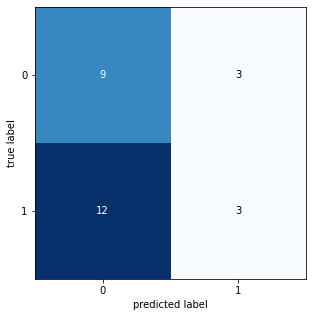

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

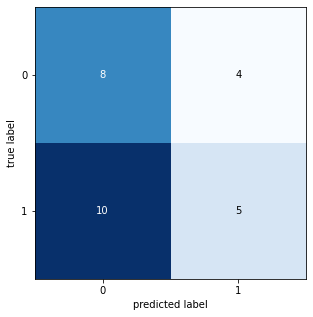

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

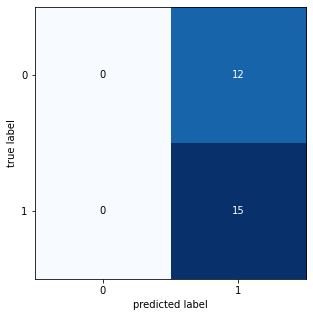

avg accuraccy Prostate Cancer =  0.5142857142857142
avg F1_Score Prostate Cancer =  0.42097402597402606
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.4444444444444444
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.78769148599531
gene : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

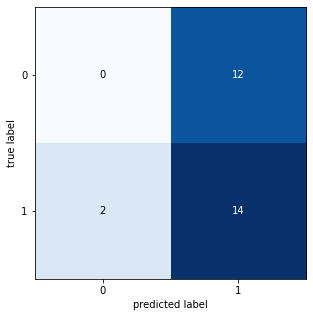

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

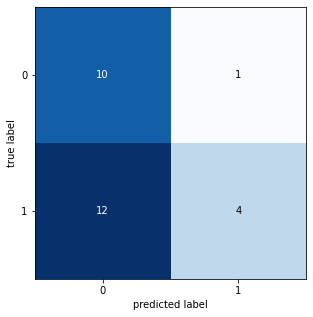

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


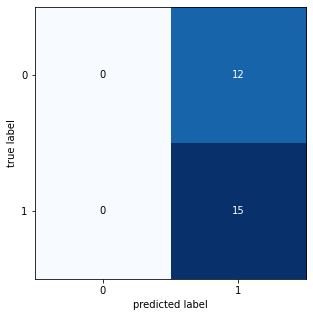

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

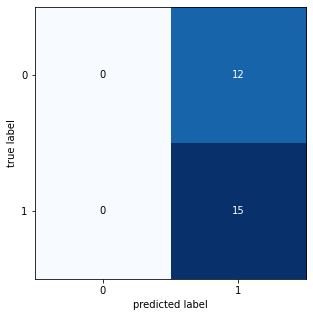

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

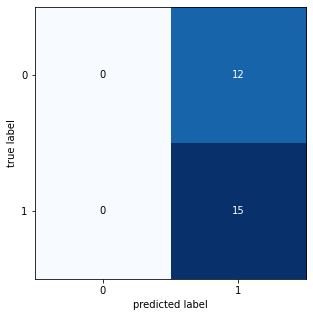

avg accuraccy Prostate Cancer =  0.537037037037037
avg F1_Score Prostate Cancer =  0.3796536796536797
max accuraccy Prostate Cancer =  0.5555555555555556
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5
min F1_Score Prostate Cancer =  0.33333333333333337
Running Time:  40.41498908200447
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


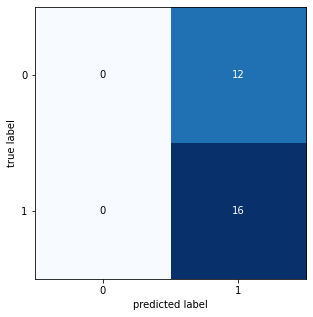

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

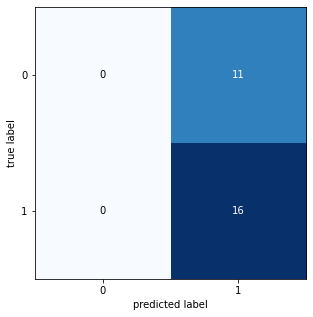

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

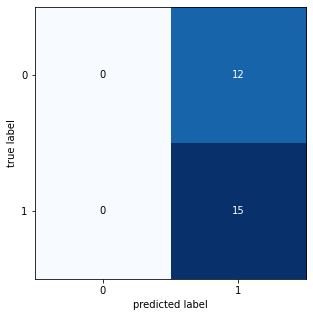

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

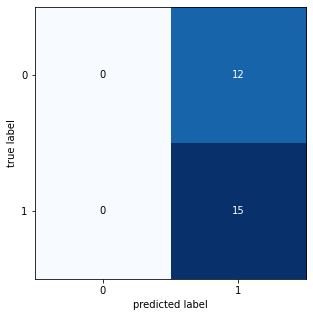

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

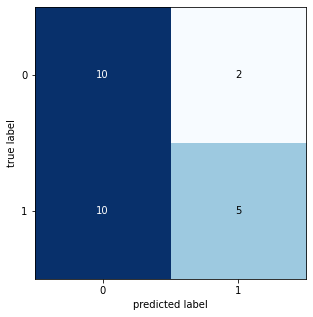

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.39795756569012386
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.64409254700149
gene : [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


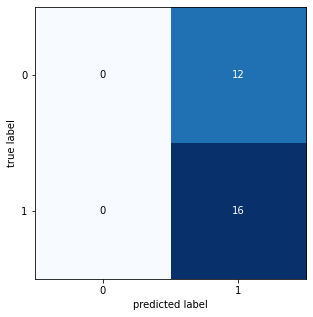

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

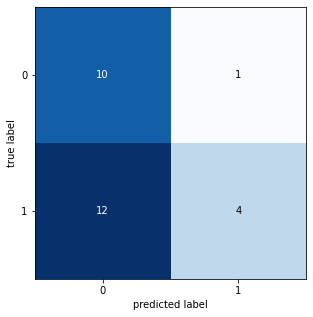

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

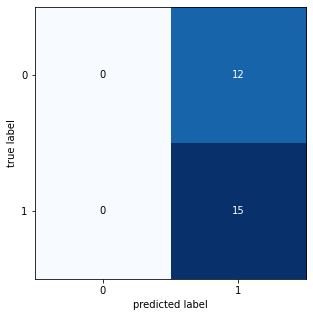

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

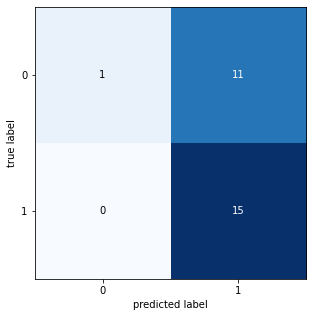

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

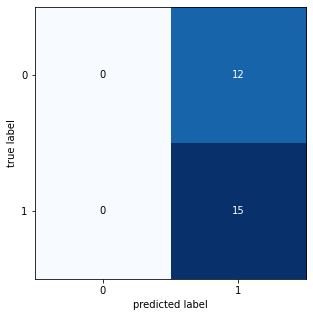

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.4028410613776468
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.95466683700215
gene : [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

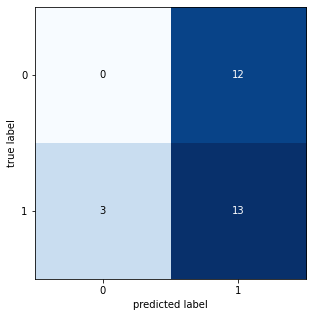

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


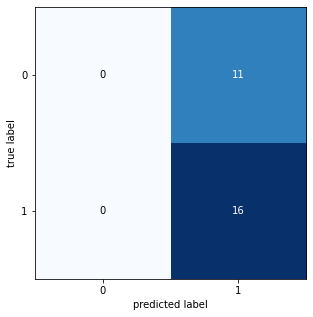

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

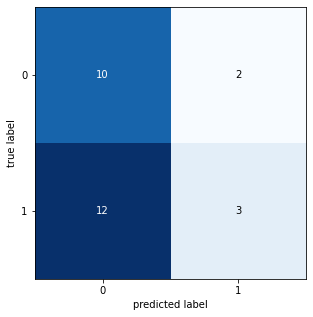

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

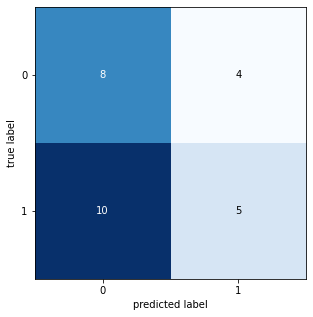

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

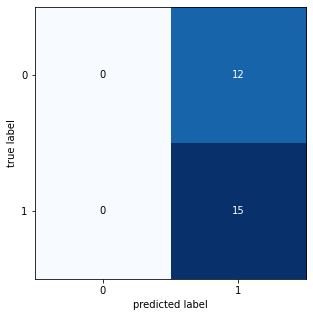

avg accuraccy Prostate Cancer =  0.515079365079365
avg F1_Score Prostate Cancer =  0.39308533963784037
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.4642857142857143
min F1_Score Prostate Cancer =  0.3170731707317073
Running Time:  40.54430123000202
gen terbaik : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
F-1 Score terbaik : 0.45567173748324297  || Akurasi terbaik : 0.5888888888888889  || jumlah fitur : 48

Generation : 1
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


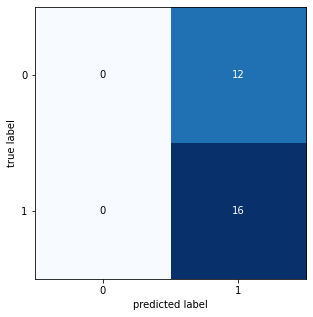

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

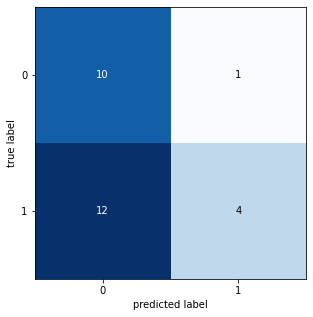

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

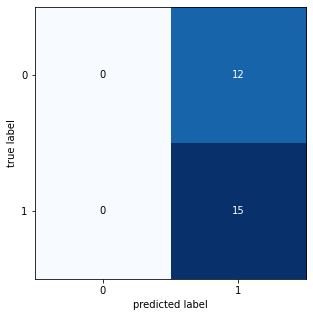

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6666666666666666
F1_Score :  0.5846153846153846
              precision    recall  f1-score   support

           0     

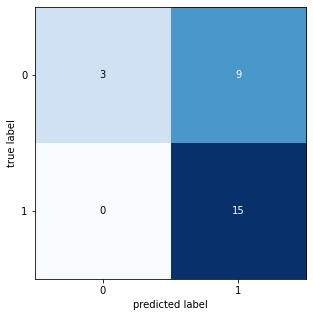

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

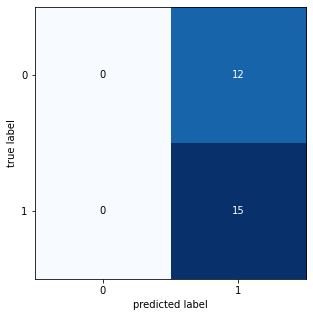

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.4312087912087913
max accuraccy Prostate Cancer =  0.6666666666666666
max F1_Score Prostate Cancer =  0.5846153846153846
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.744496316998266
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


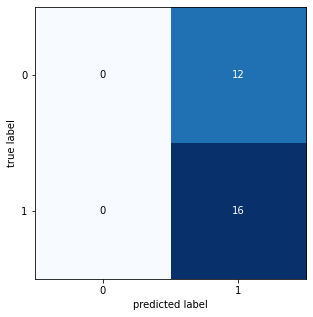

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

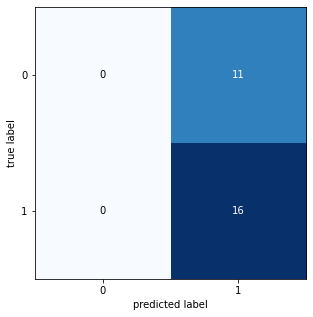

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

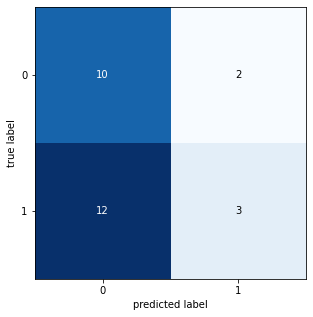

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

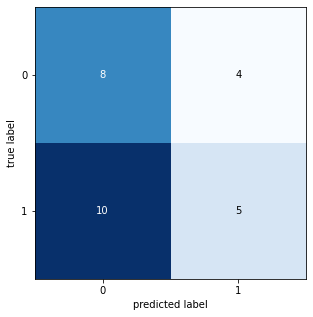

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

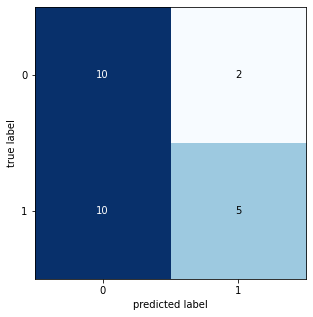

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4389239522447458
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.36363636363636365
Running Time:  40.346313459005614
gene : [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


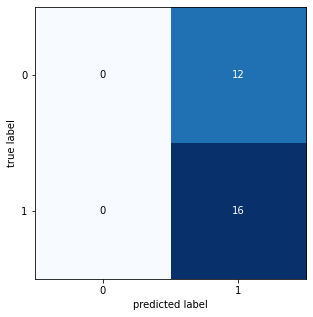

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

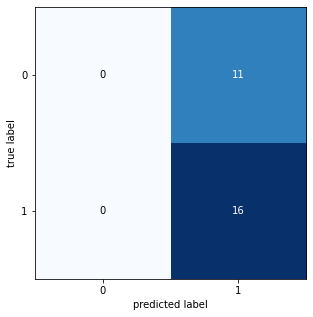

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

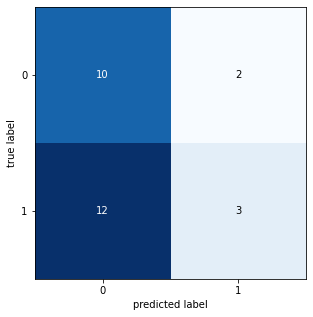

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.3333333333333333
F1_Score :  0.25
              precision    recall  f1-score   support

           0       0.38      0.

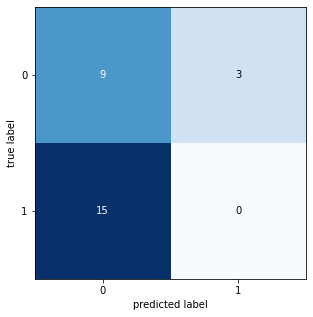

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

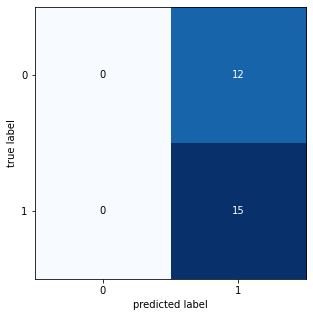

avg accuraccy Prostate Cancer =  0.5068783068783068
avg F1_Score Prostate Cancer =  0.3573979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.3333333333333333
min F1_Score Prostate Cancer =  0.25
Running Time:  40.16545331400266
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


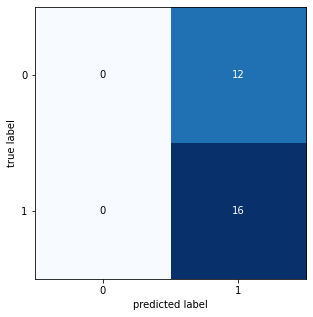

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.6296296296296297
F1_Score :  0.4642857142857143
              precision    recall  f1-score   support

           0     

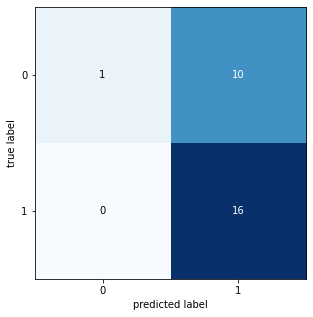

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

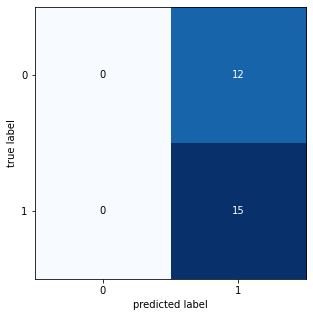

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

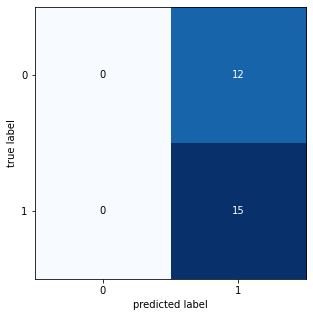

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

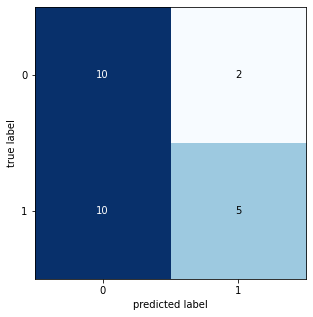

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.41639610389610393
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.94130627899722
gene : [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


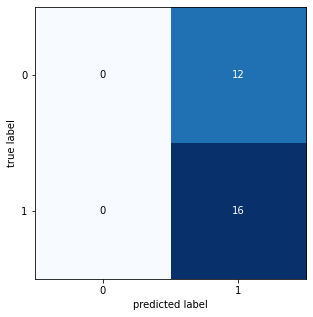

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

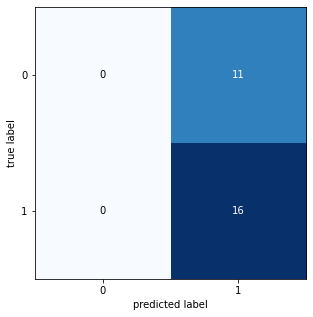

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

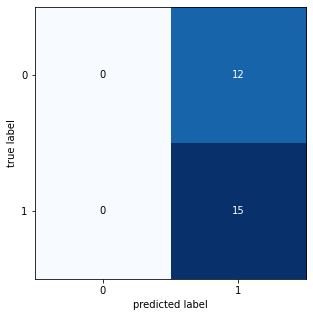

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

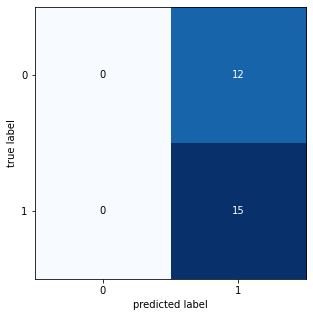

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

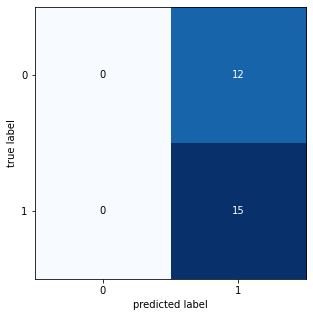

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  41.30541381900548
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


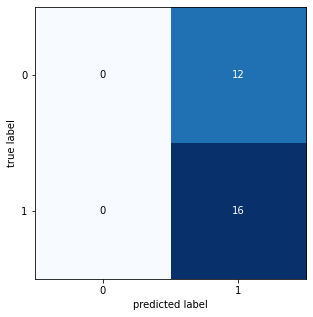

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

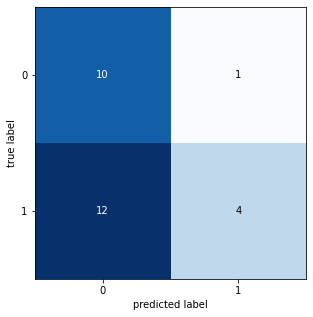

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

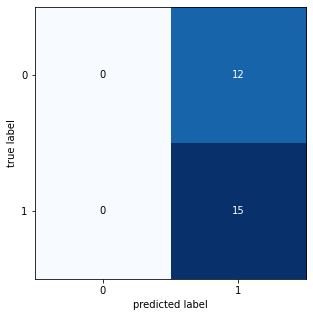

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

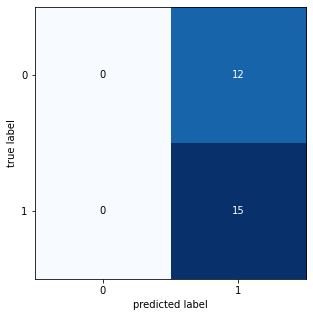

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

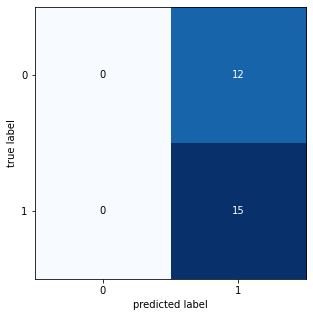

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.81252565100294
gene : [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


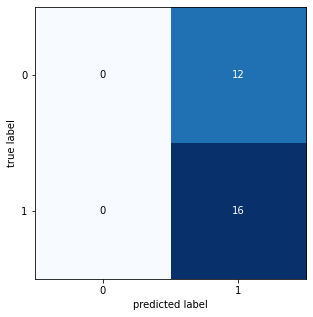

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

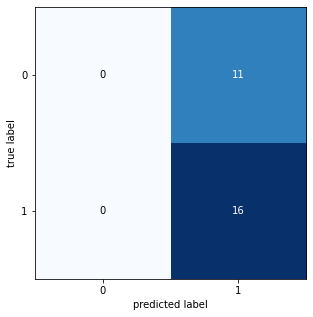

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

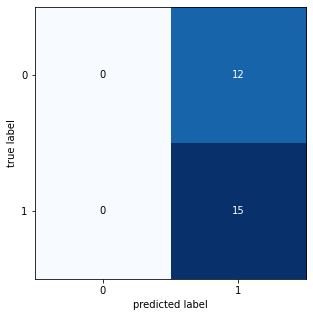

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

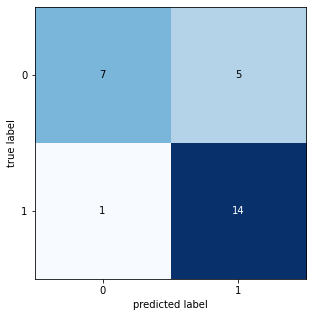

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

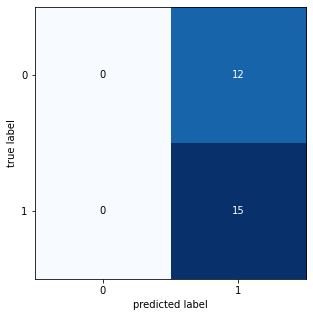

avg accuraccy Prostate Cancer =  0.6105820105820106
avg F1_Score Prostate Cancer =  0.44235596141204897
max accuraccy Prostate Cancer =  0.7777777777777778
max F1_Score Prostate Cancer =  0.7617647058823529
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.78875010699994
gene : [0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


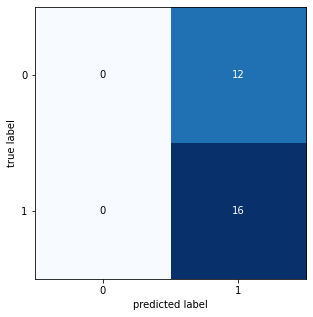

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.6296296296296297
F1_Score :  0.4642857142857143
              precision    recall  f1-score   support

           0     

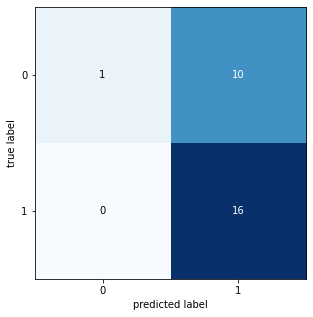

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

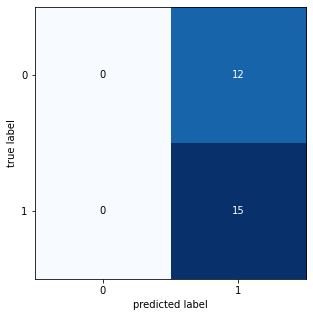

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

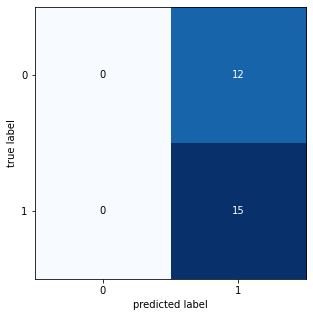

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

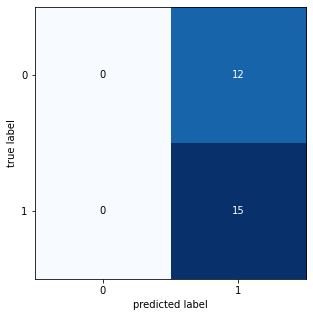

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.3798701298701299
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.4642857142857143
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.717267578002065
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


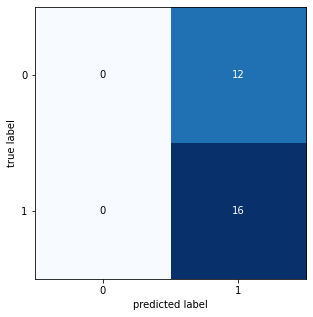

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

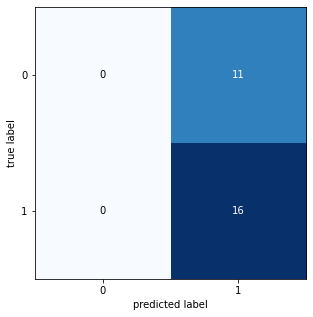

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

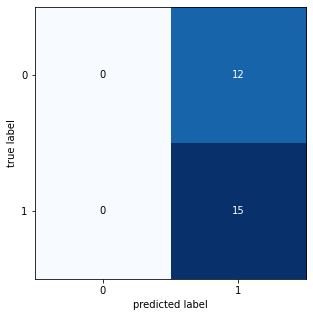

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

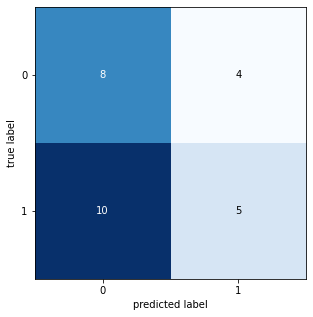

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

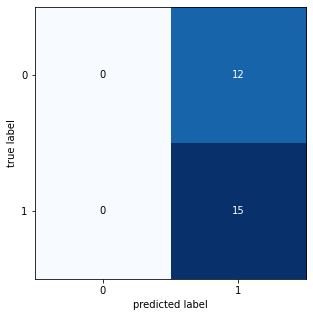

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3850030202355784
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.976689342998725
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


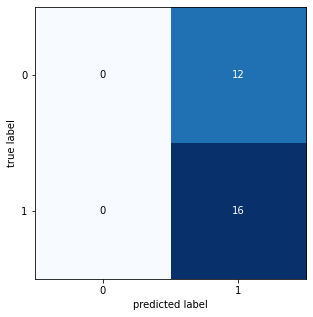

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

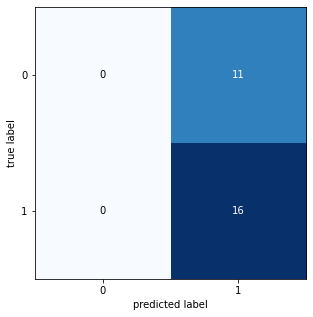

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

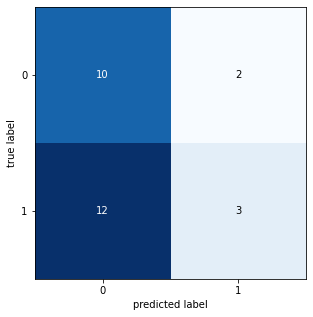

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.7
              precision    recall  f1-score   support

           0       0.67      0.6

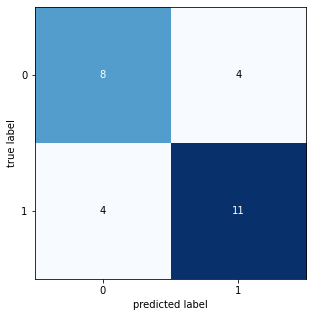

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

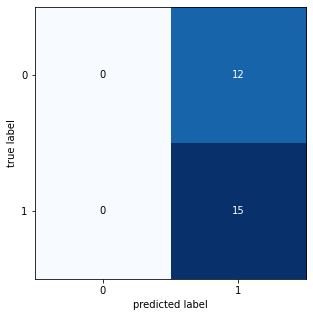

avg accuraccy Prostate Cancer =  0.5809523809523809
avg F1_Score Prostate Cancer =  0.44739797821877164
max accuraccy Prostate Cancer =  0.7037037037037037
max F1_Score Prostate Cancer =  0.7
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.46222909900098
gen terbaik : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
F-1 Score terbaik : 0.45567173748324297  || Akurasi terbaik : 0.5888888888888889  || jumlah fitur : 48

Generation : 2
gene : [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 

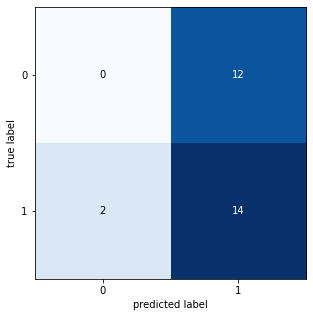

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


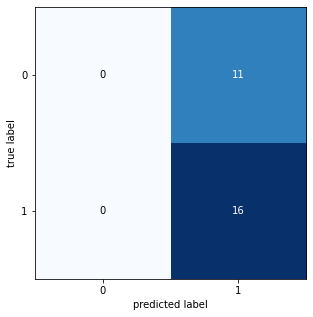

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

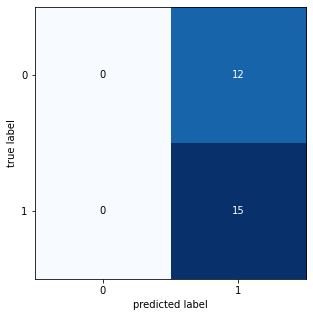

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.4074074074074074
F1_Score :  0.33333333333333337
              precision    recall  f1-score   support

           0    

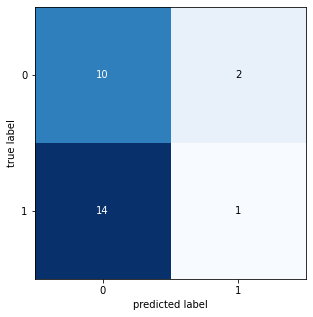

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

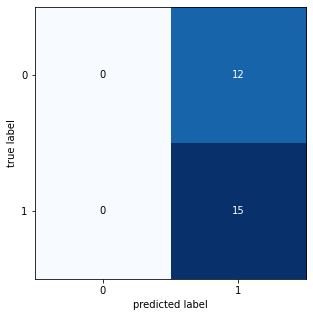

avg accuraccy Prostate Cancer =  0.5222222222222221
avg F1_Score Prostate Cancer =  0.350609080841639
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.4074074074074074
min F1_Score Prostate Cancer =  0.33333333333333337
Running Time:  37.5301745619945
gene : [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

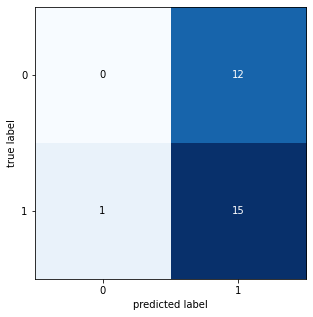

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

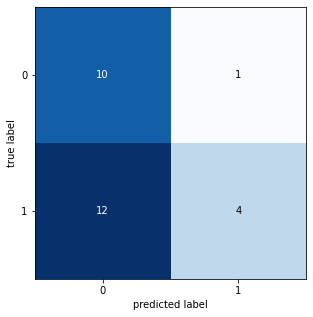

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


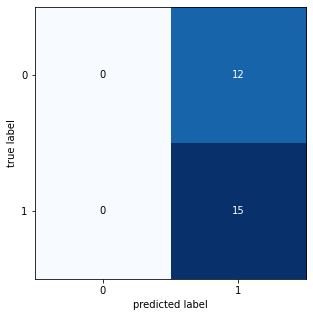

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.3414634146341463
              precision    recall  f1-score   support

           0     

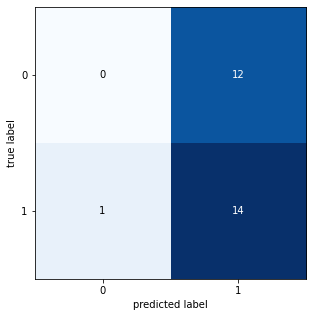

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

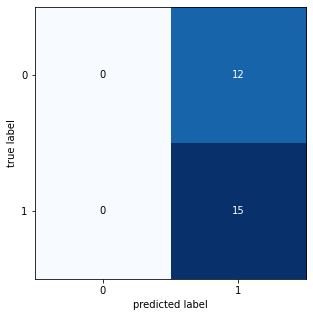

avg accuraccy Prostate Cancer =  0.5367724867724867
avg F1_Score Prostate Cancer =  0.379618566345736
max accuraccy Prostate Cancer =  0.5555555555555556
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.3414634146341463
Running Time:  39.5155452090039
gene : [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


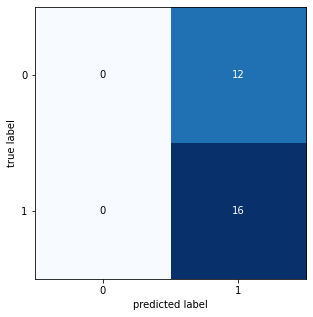

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

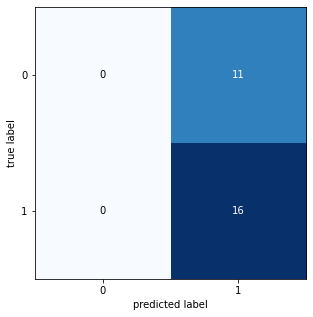

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

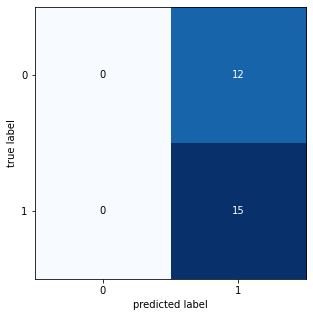

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

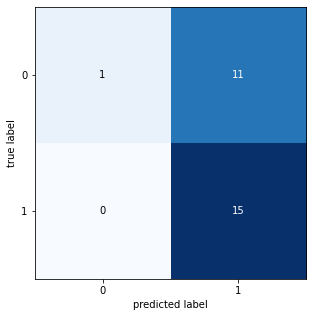

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

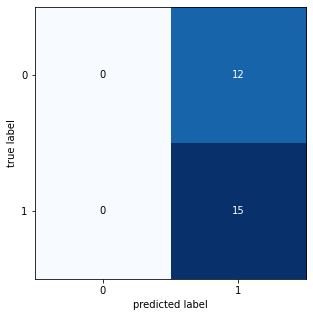

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.37855836732751086
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4427767354596623
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.57176478700421
gene : [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


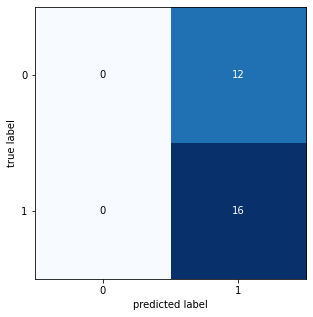

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

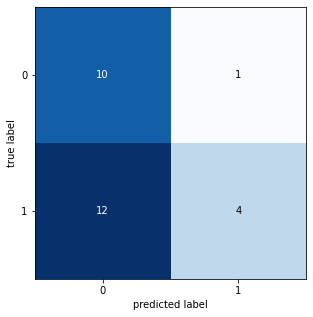

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

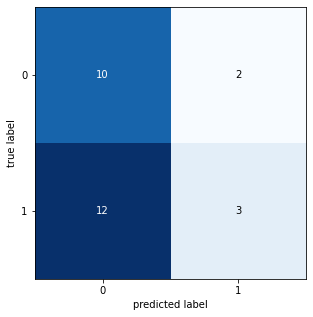

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

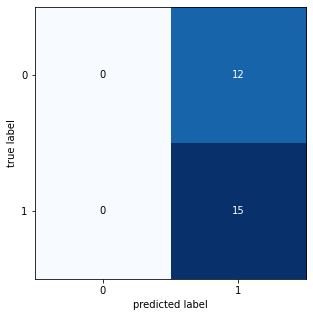

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

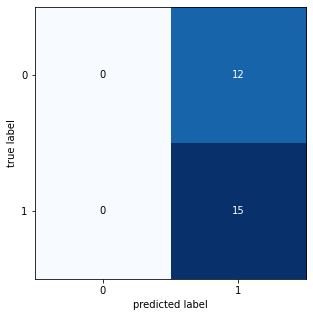

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.40310924369747897
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.75211287700222
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

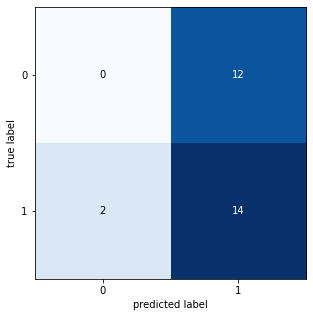

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


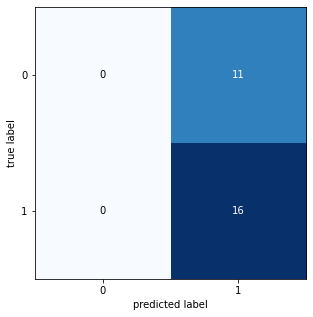

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

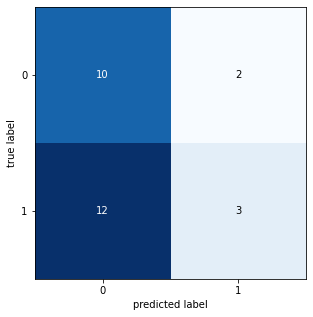

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

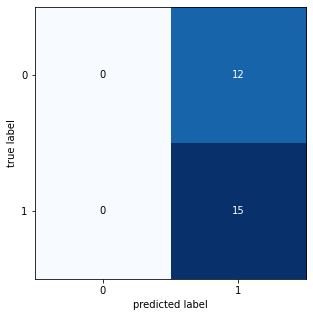

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

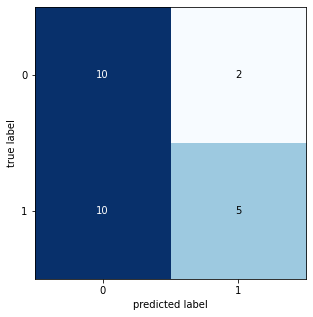

avg accuraccy Prostate Cancer =  0.537037037037037
avg F1_Score Prostate Cancer =  0.4092919176127111
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.33333333333333337
Running Time:  37.7007850259979
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


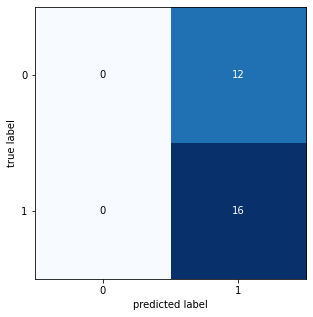

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.6296296296296297
F1_Score :  0.4642857142857143
              precision    recall  f1-score   support

           0     

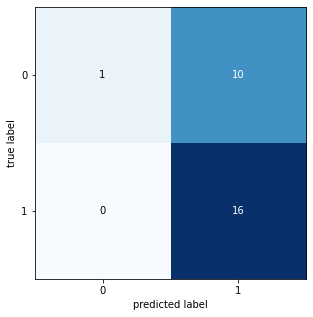

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

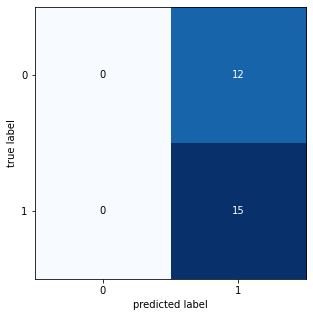

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

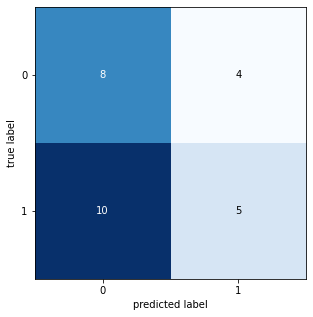

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

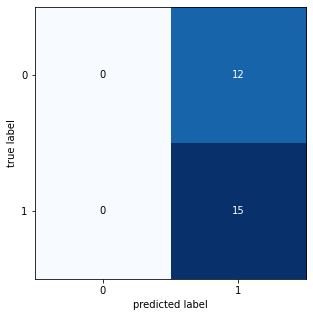

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.40344155844155843
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.38246141199488
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


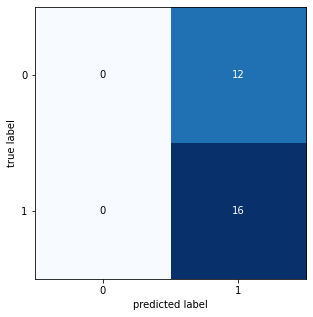

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

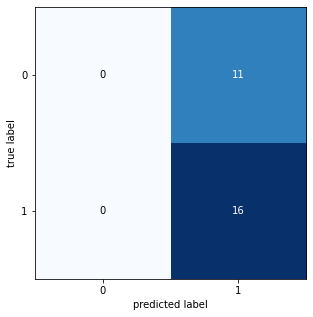

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5
              precision    recall  f1-score   support

           0       0.50      1.0

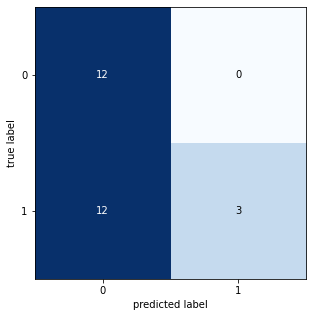

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

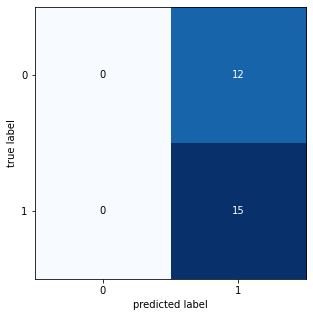

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

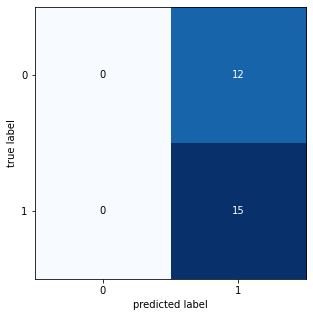

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.39000302023557837
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.33773859600478
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


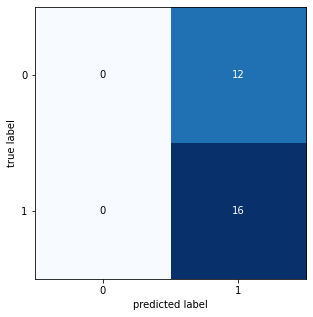

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

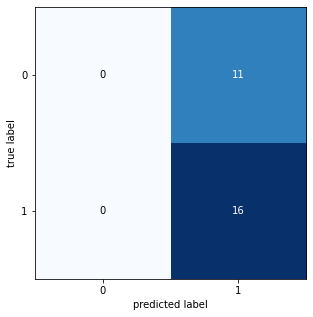

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

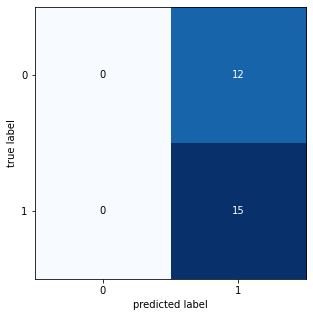

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.4214285714285715
              precision    recall  f1-score   support

           0     

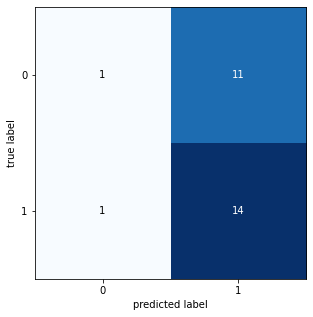

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

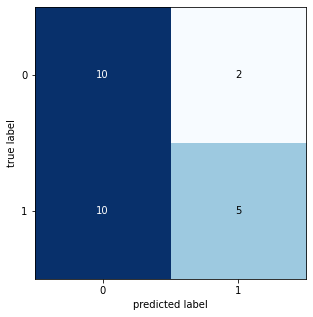

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.4108147085472667
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.243225727994286
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


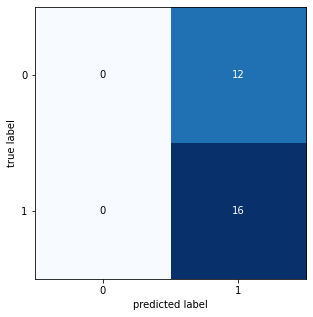

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

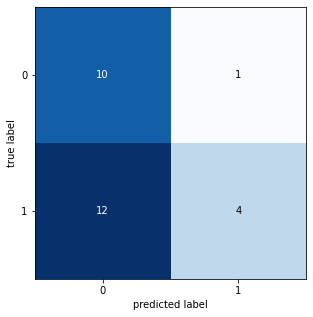

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

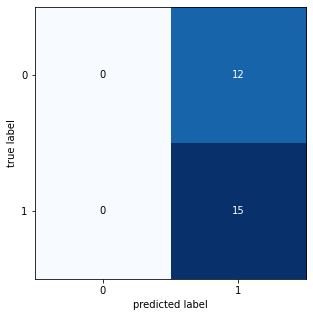

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

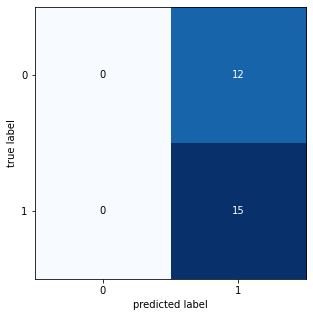

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

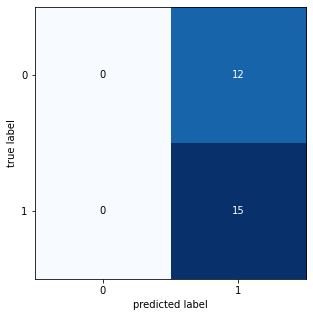

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.28418772199802
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

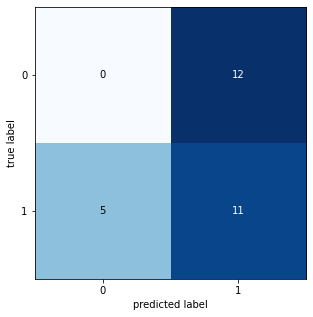

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


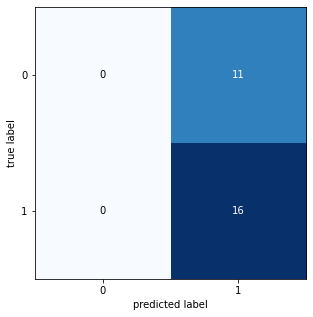

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

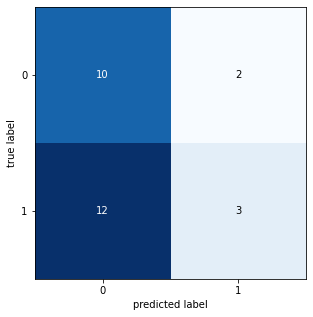

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

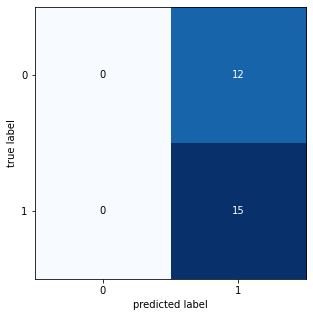

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

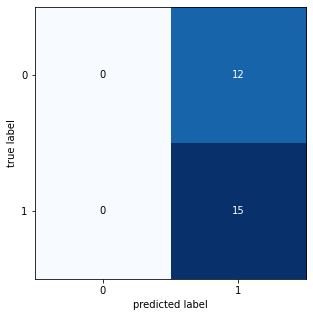

avg accuraccy Prostate Cancer =  0.5156084656084655
avg F1_Score Prostate Cancer =  0.3625095333303268
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.39285714285714285
min F1_Score Prostate Cancer =  0.2820512820512821
Running Time:  37.79009272300027
gen terbaik : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
F-1 Score terbaik : 0.45567173748324297  || Akurasi terbaik : 0.5888888888888889  || jumlah fitur : 48

Generation : 3
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

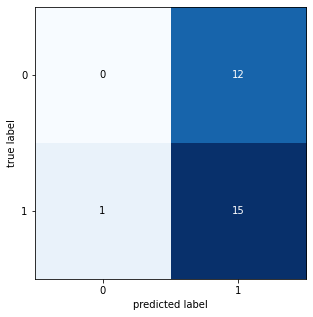

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


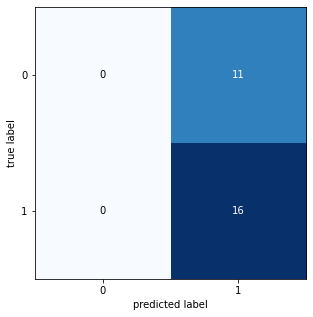

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

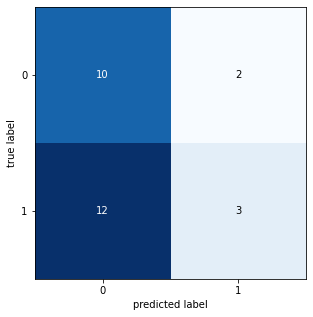

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

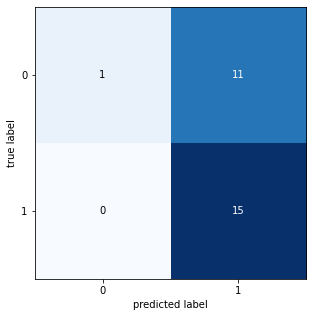

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

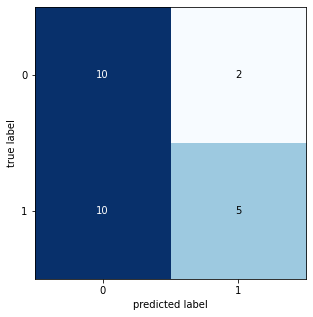

avg accuraccy Prostate Cancer =  0.5515873015873016
avg F1_Score Prostate Cancer =  0.42951946846987055
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.3488372093023256
Running Time:  36.75146640400635
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


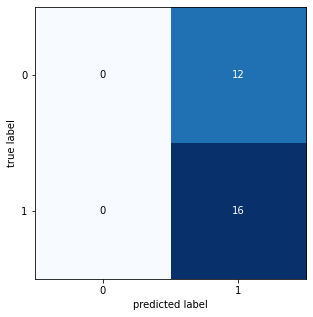

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

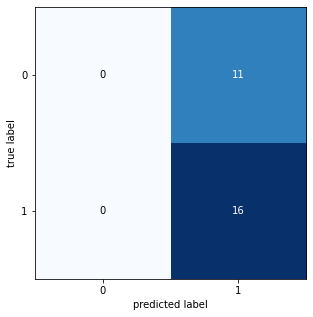

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

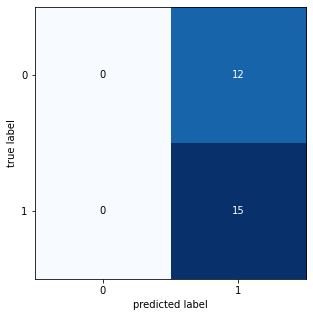

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

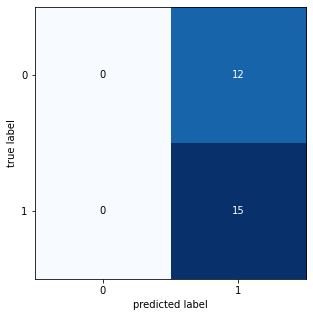

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

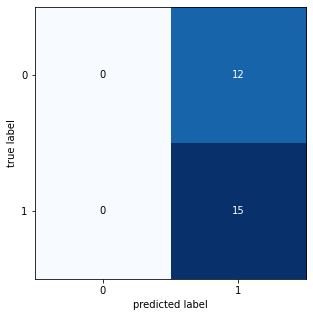

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.64113653000095
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

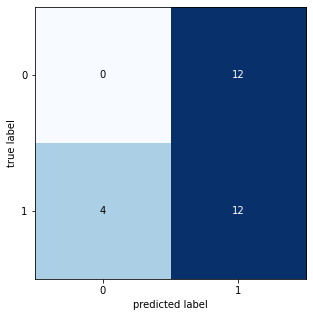

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

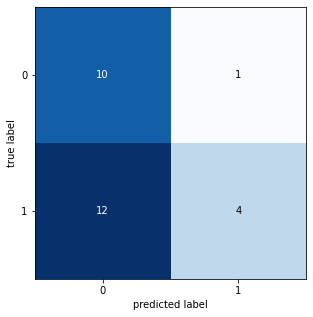

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


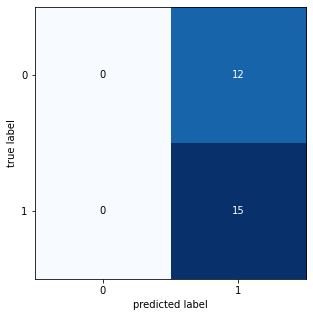

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

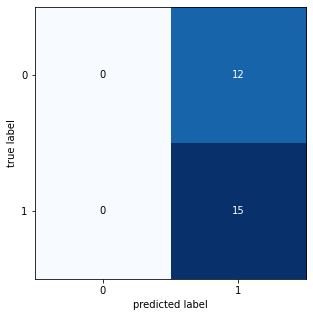

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

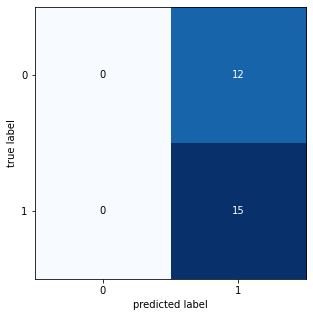

avg accuraccy Prostate Cancer =  0.5227513227513227
avg F1_Score Prostate Cancer =  0.37298701298701303
max accuraccy Prostate Cancer =  0.5555555555555556
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.42857142857142855
min F1_Score Prostate Cancer =  0.3
Running Time:  36.333565109998744
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


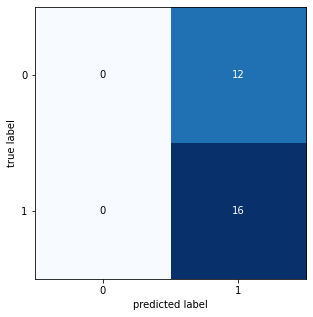

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

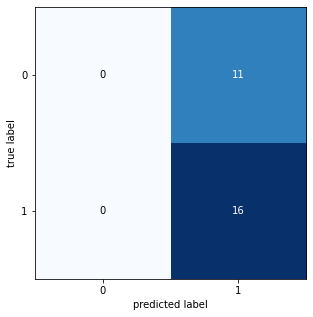

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

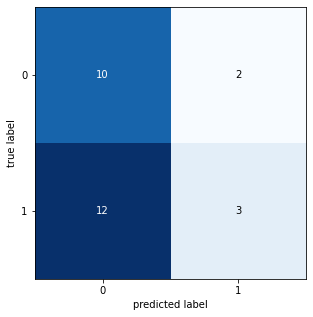

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

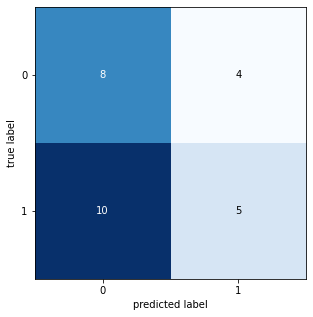

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

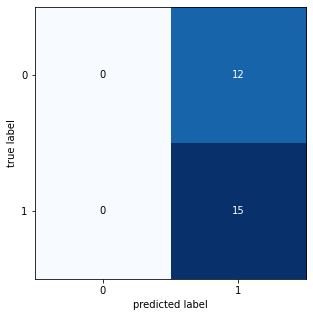

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.85727600300015
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


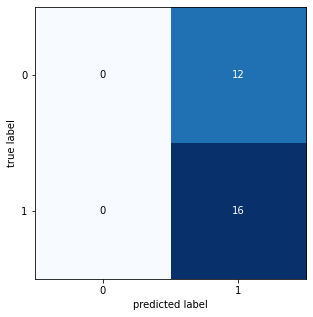

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

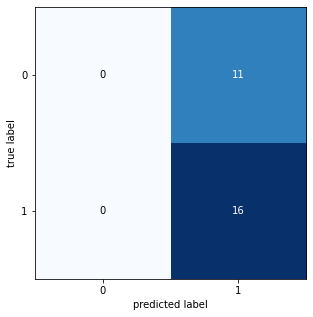

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

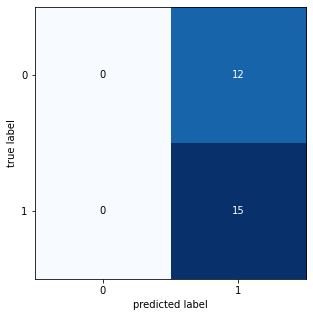

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

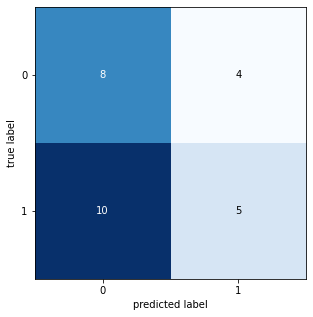

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

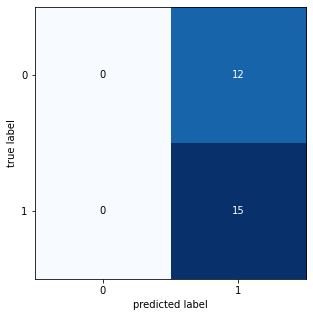

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3850030202355784
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.761493468999106
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


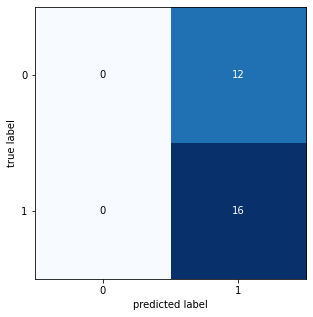

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

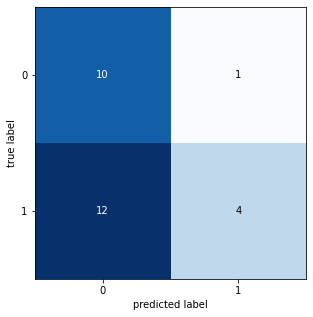

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

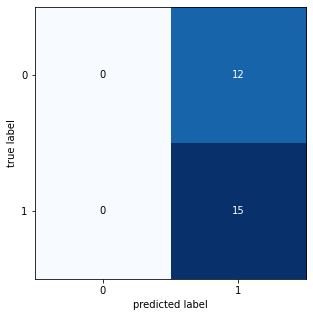

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

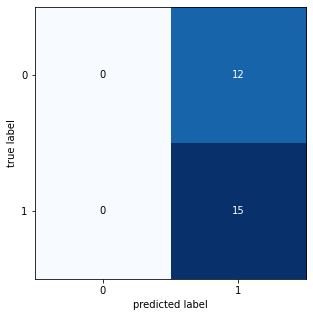

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

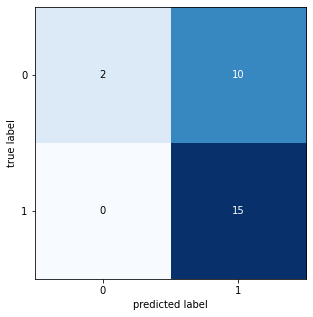

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.41785714285714287
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.46712263799418
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

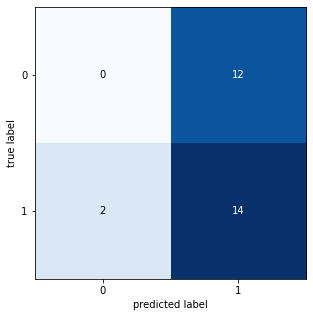

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


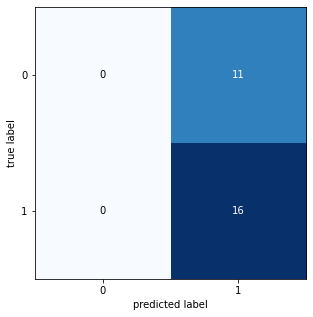

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

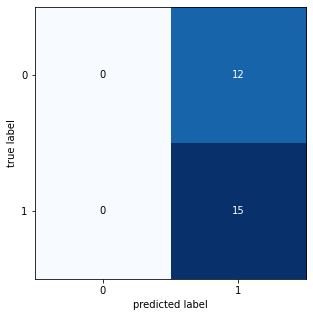

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

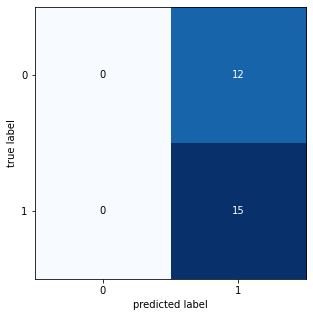

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.3414634146341463
              precision    recall  f1-score   support

           0     

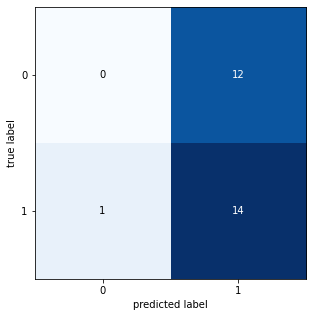

avg accuraccy Prostate Cancer =  0.5444444444444445
avg F1_Score Prostate Cancer =  0.35223509710180156
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5
min F1_Score Prostate Cancer =  0.33333333333333337
Running Time:  36.82358559400018
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


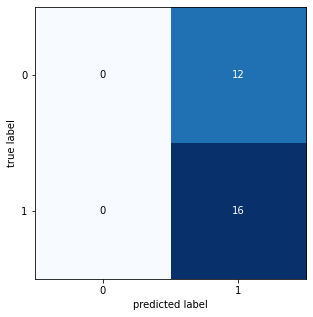

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

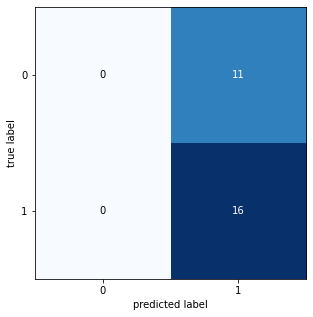

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

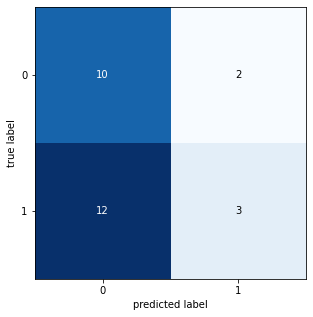

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

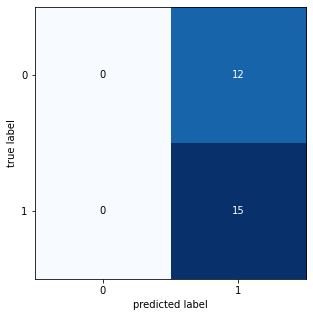

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

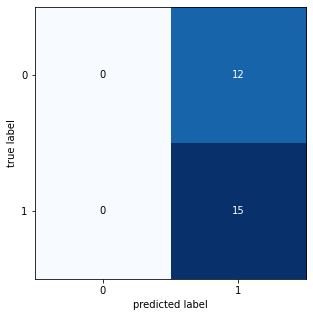

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.37882654964734314
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.23247617499874
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


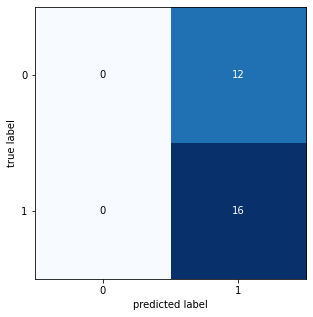

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

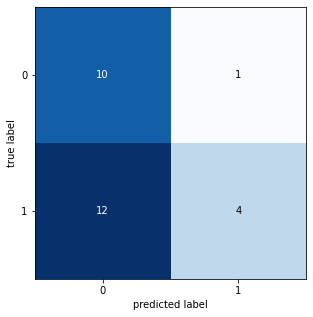

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.325
              precision    recall  f1-score   support

           0       0.00      

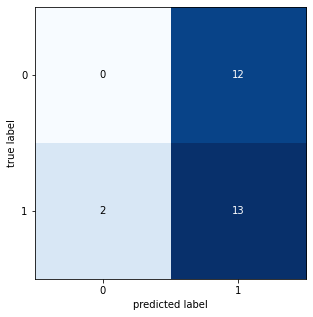

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

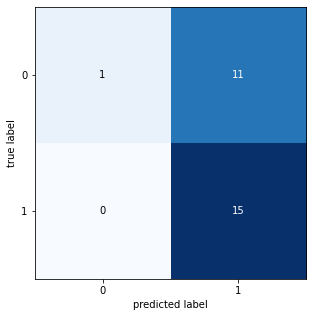

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

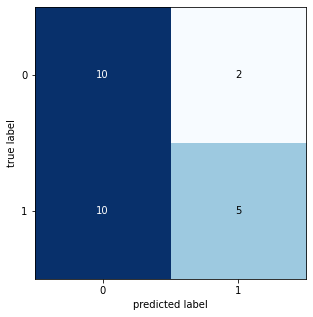

avg accuraccy Prostate Cancer =  0.5439153439153438
avg F1_Score Prostate Cancer =  0.43293846397504937
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.325
Running Time:  36.236902616001316
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


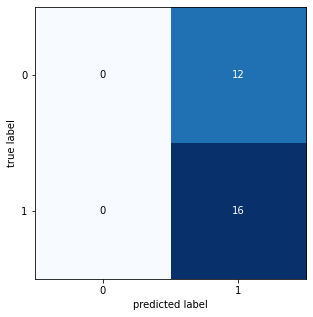

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

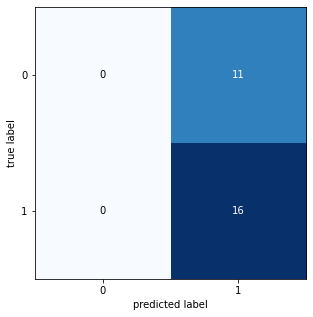

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

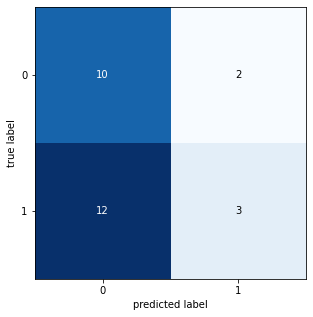

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

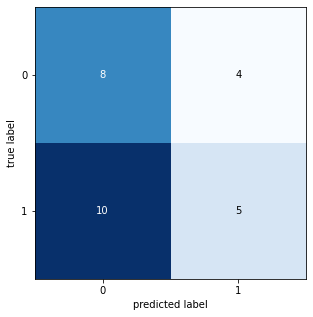

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

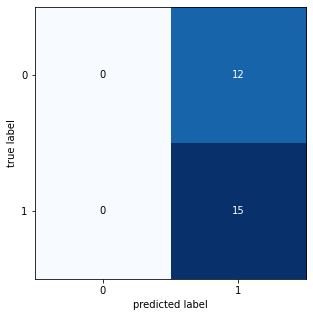

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.82465460799722
gen terbaik : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
F-1 Score terbaik : 0.45567173748324297  || Akurasi terbaik : 0.5888888888888889  || jumlah fitur : 48

Generation : 4
gene : [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


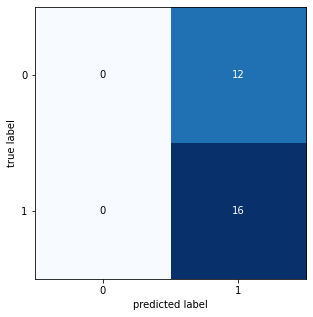

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

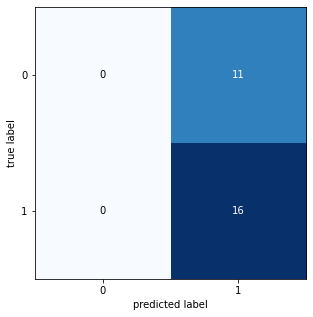

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

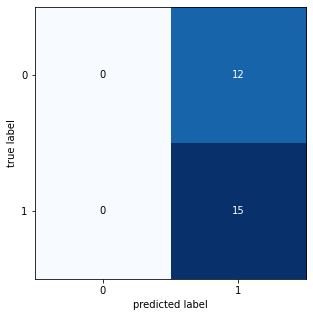

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

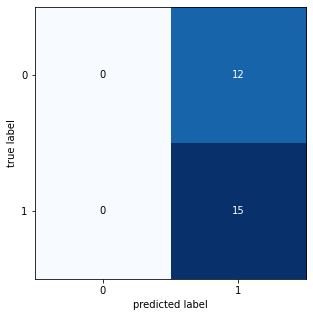

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

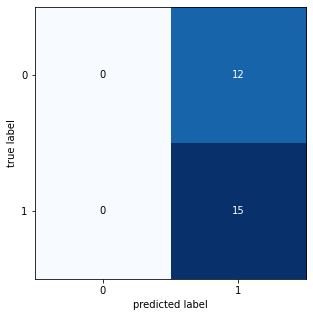

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.846963841002434
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


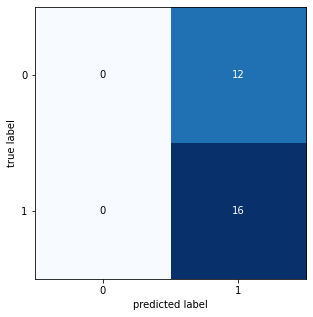

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

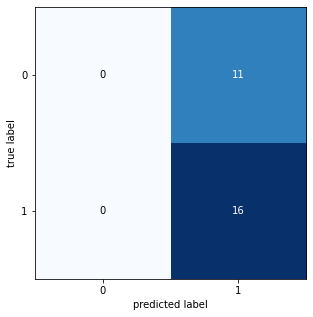

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

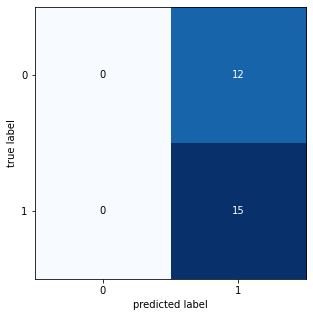

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

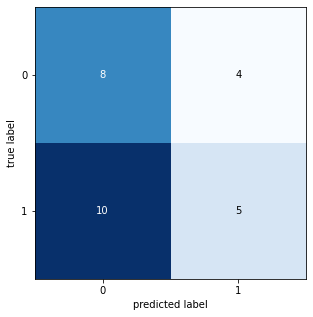

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

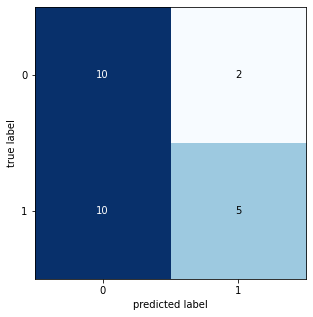

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.4215289942615524
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.215837390998786
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


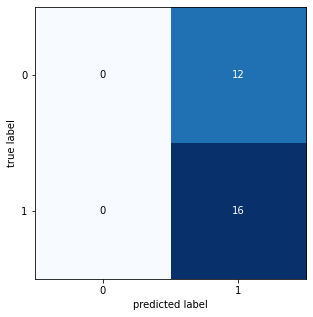

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

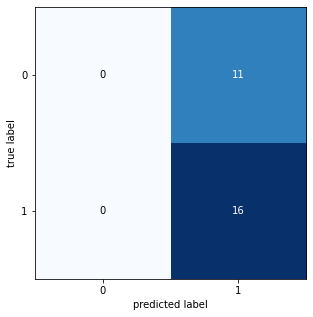

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

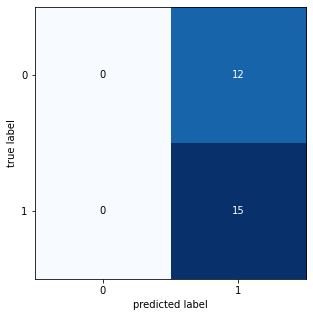

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

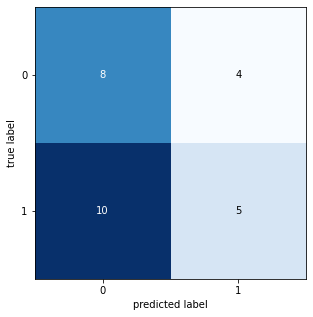

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

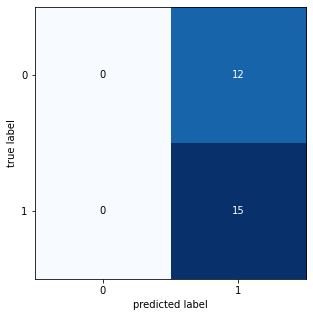

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3850030202355784
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.82491301599657
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


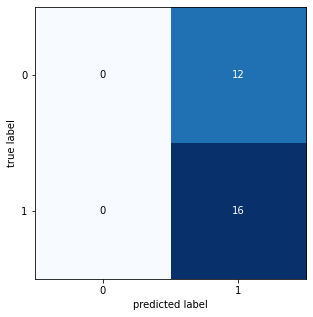

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

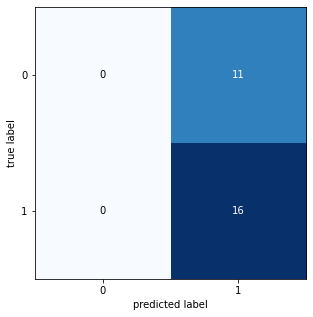

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

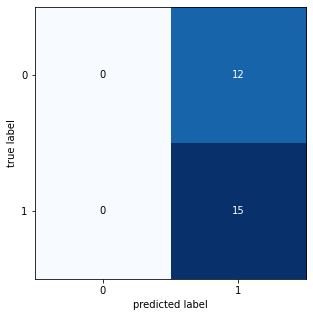

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

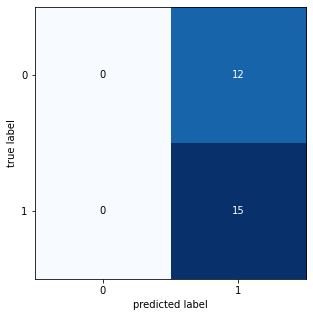

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

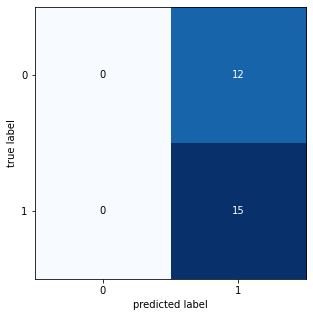

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.62603689899697
gene : [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


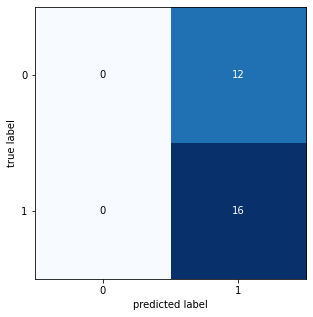

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

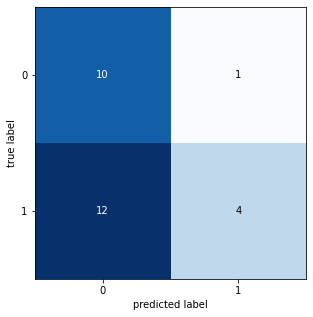

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

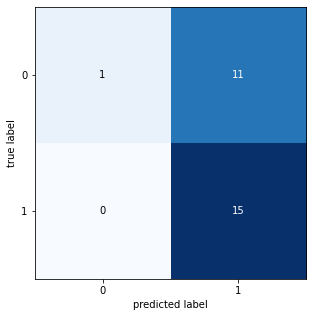

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

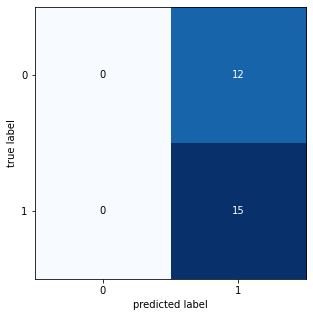

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

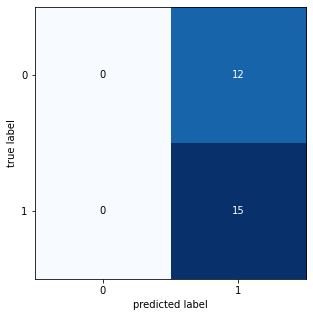

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.4028410613776468
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.6504709869987
gene : [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


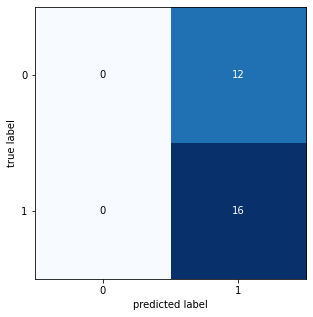

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

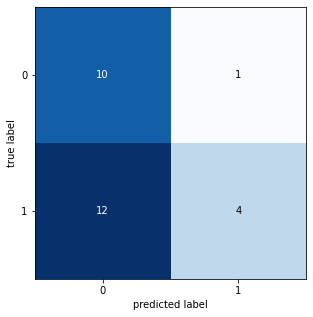

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

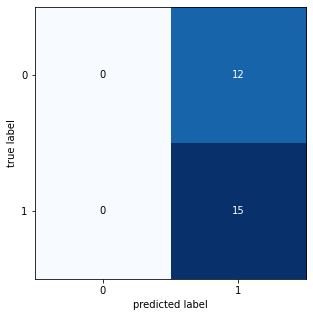

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4630681818181819
              precision    recall  f1-score   support

           0    

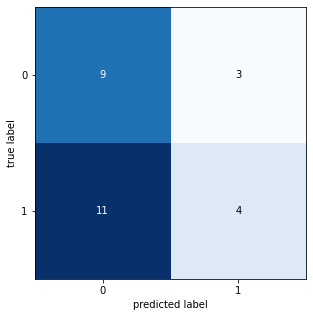

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

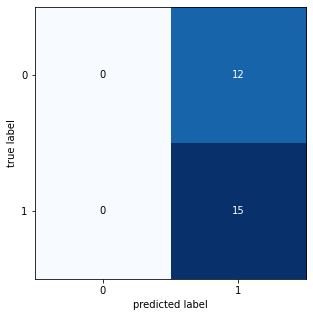

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4068993506493507
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.6967832099981
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


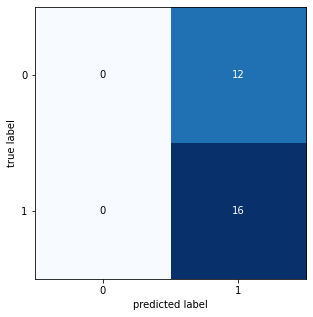

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

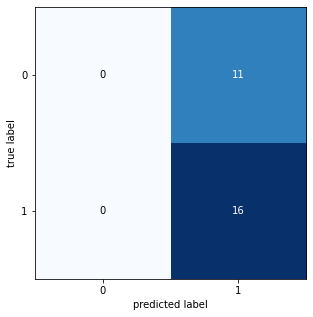

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

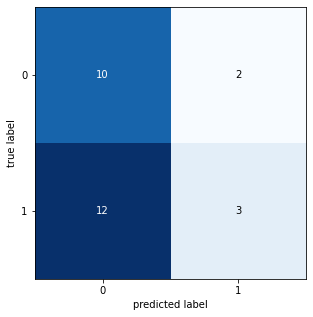

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

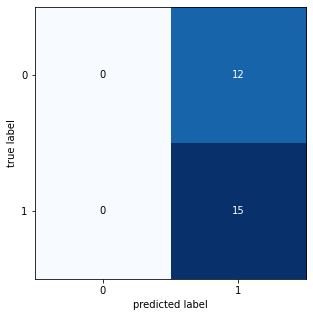

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

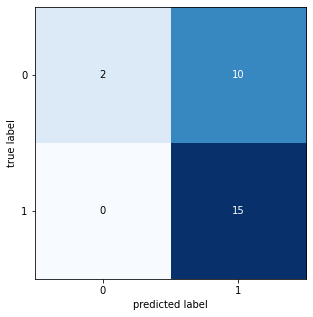

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.4109694067902002
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.657480563997524
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


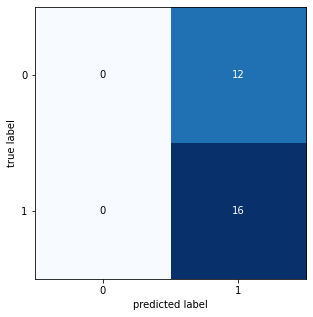

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

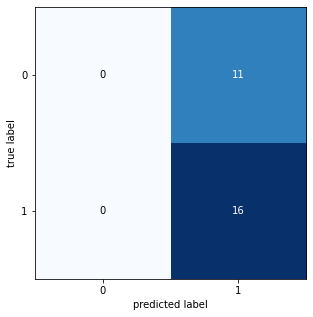

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

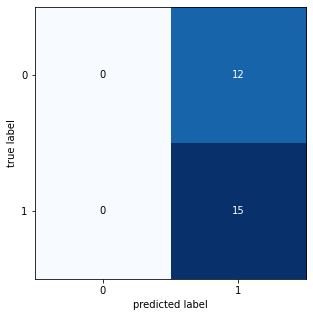

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

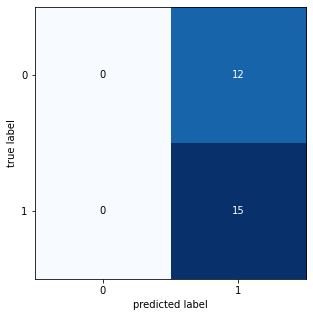

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

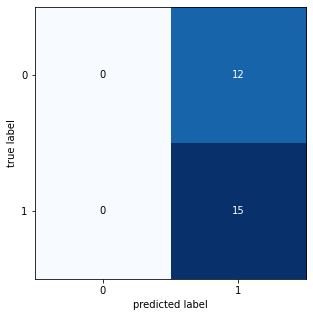

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.839732401997026
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


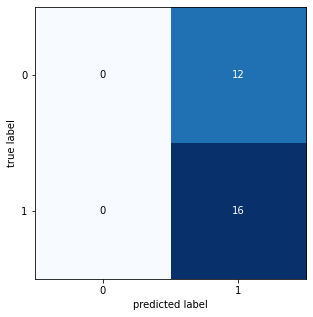

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

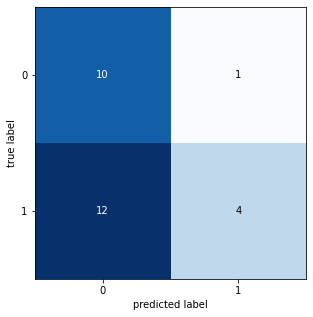

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

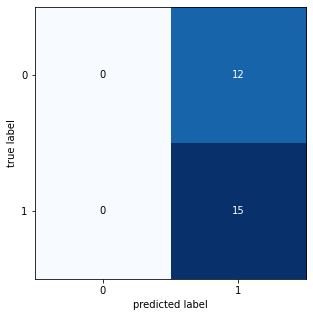

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

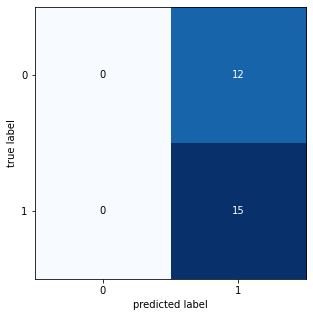

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

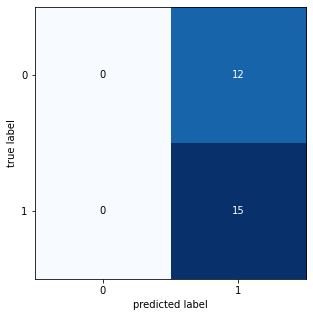

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.846584737999365
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


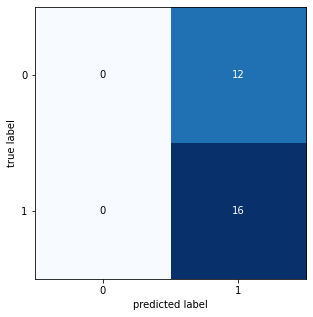

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

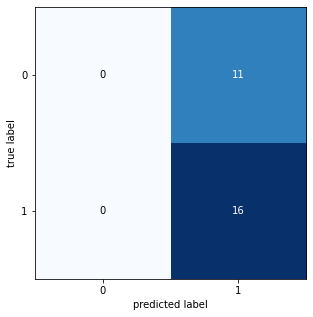

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

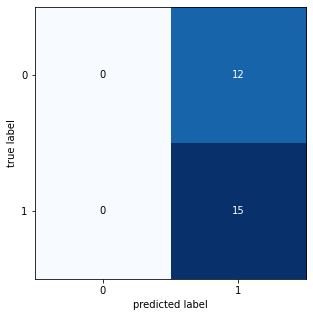

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

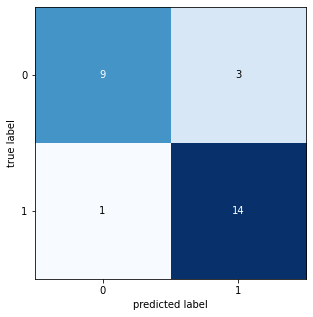

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

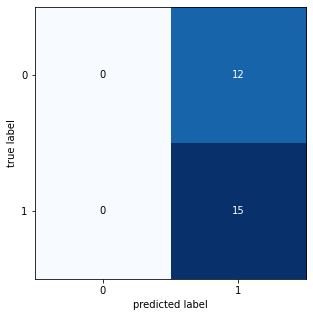

avg accuraccy Prostate Cancer =  0.6253968253968253
avg F1_Score Prostate Cancer =  0.4593212020537602
max accuraccy Prostate Cancer =  0.8518518518518519
max F1_Score Prostate Cancer =  0.8465909090909091
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.051891454000724
gen terbaik : [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.4593212020537602  || Akurasi terbaik : 0.6253968253968253  || jumlah fitur : 49

Running Time:  1917.6422151040024


In [13]:
Prostate_IG_GA = GeneticAlgorithm(Prostate_IG, 2)

Generation : 0
gene : [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 

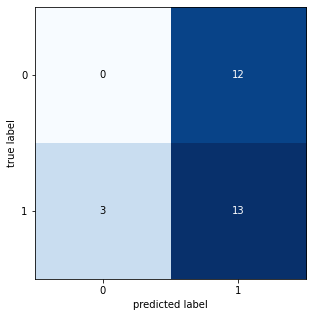

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


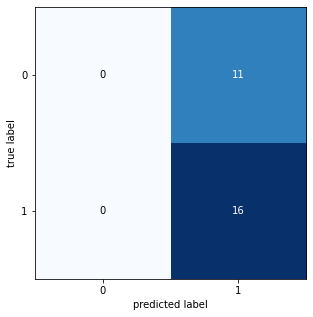

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

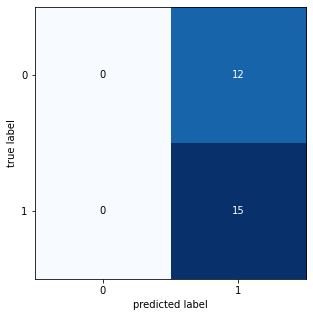

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

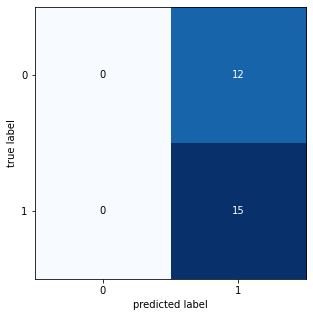

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

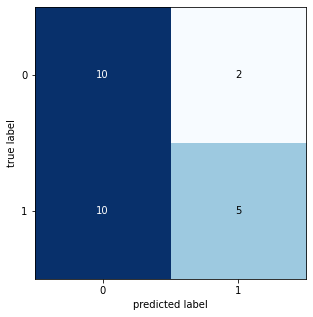

avg accuraccy Prostate Cancer =  0.5447089947089948
avg F1_Score Prostate Cancer =  0.38864492710919263
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.4642857142857143
min F1_Score Prostate Cancer =  0.3170731707317073
Running Time:  37.76312896300078
gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


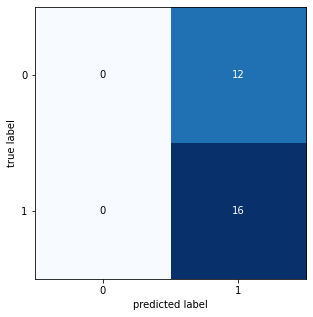

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

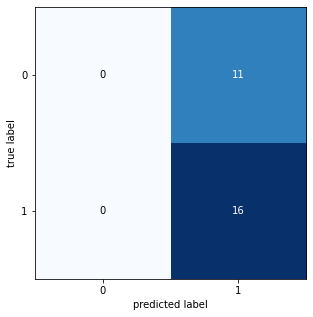

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

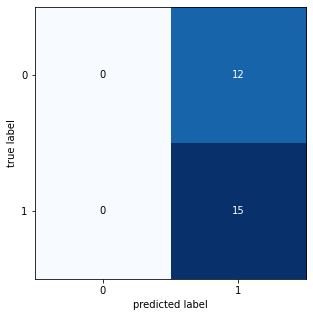

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

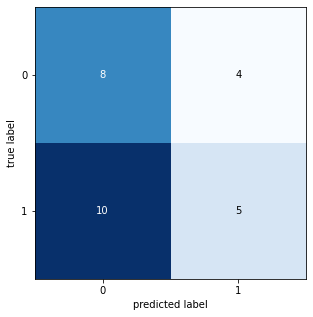

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

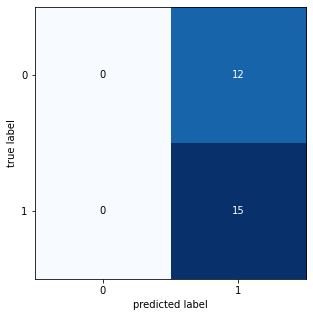

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3850030202355784
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.09633607000433
gene : [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


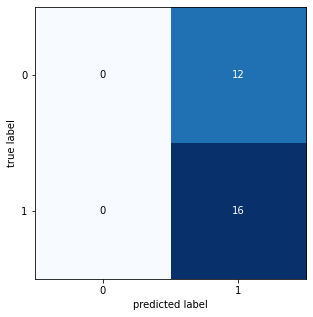

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

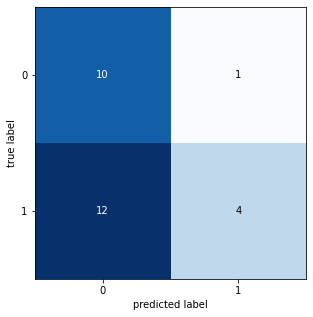

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

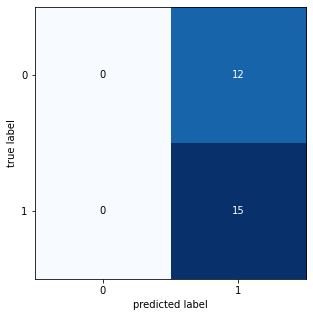

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

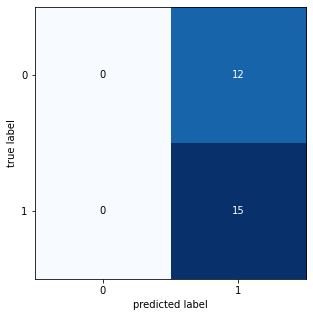

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

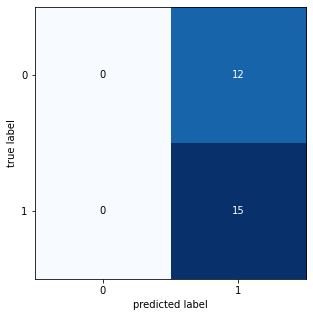

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.425884395997855
gene : [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


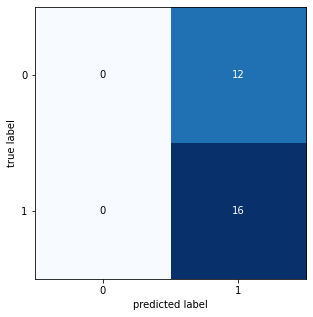

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

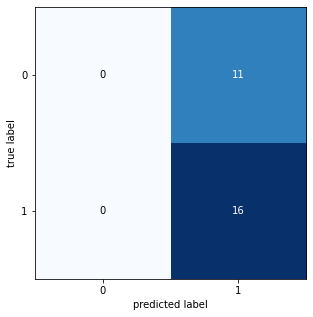

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

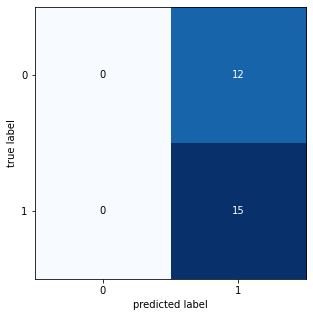

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

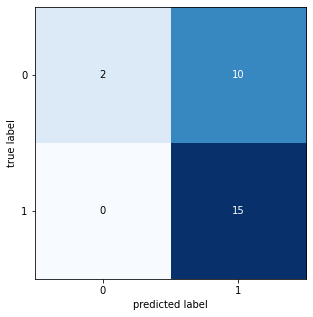

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

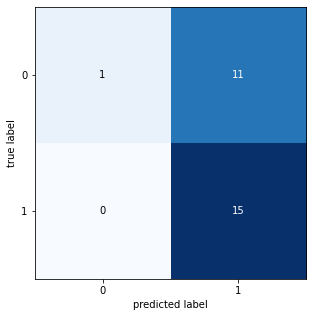

avg accuraccy Prostate Cancer =  0.5883597883597884
avg F1_Score Prostate Cancer =  0.41070122447036794
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.843992316004005
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


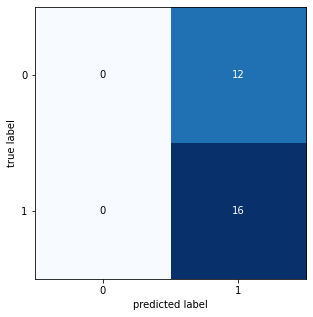

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

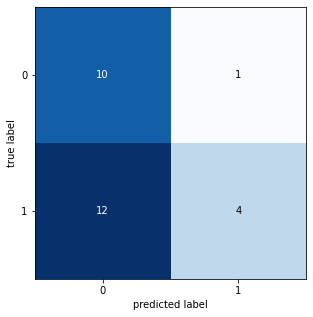

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

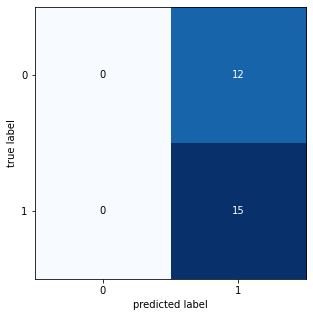

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

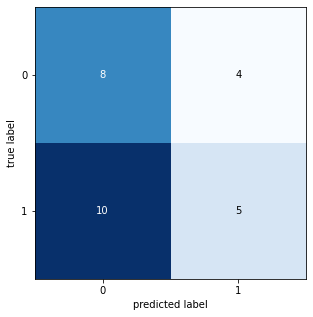

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

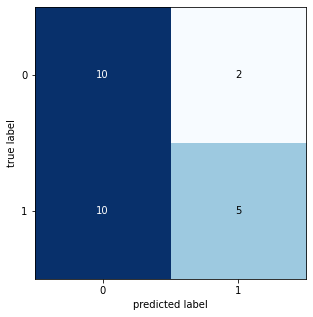

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4458116883116883
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.729489188001025
gene : [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

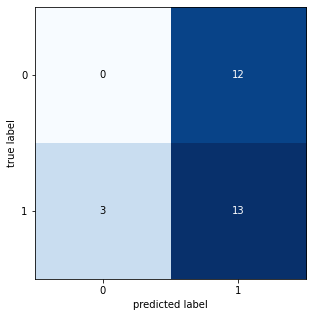

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

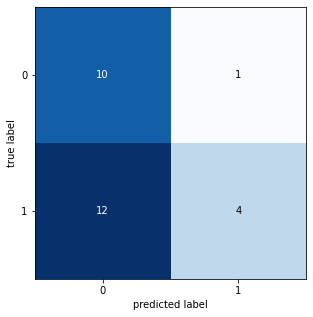

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

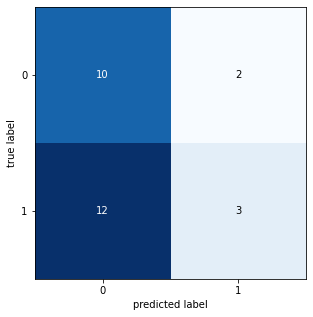

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


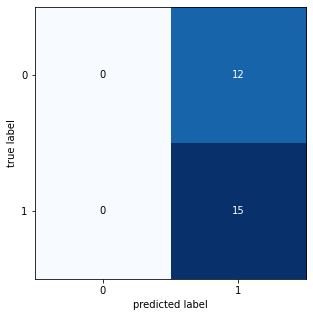

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

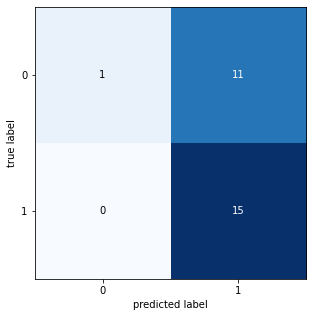

avg accuraccy Prostate Cancer =  0.5224867724867724
avg F1_Score Prostate Cancer =  0.41092338077990875
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.4642857142857143
min F1_Score Prostate Cancer =  0.3170731707317073
Running Time:  36.89513256999635
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


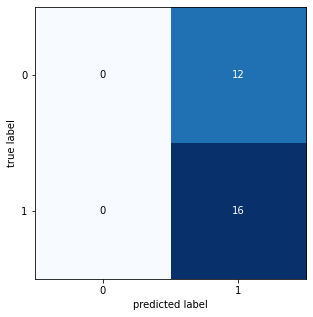

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

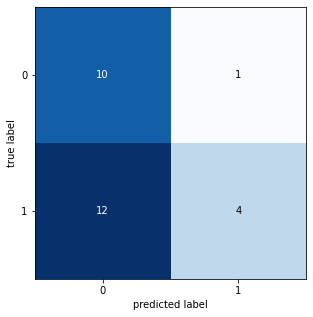

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5
              precision    recall  f1-score   support

           0       0.50      1.0

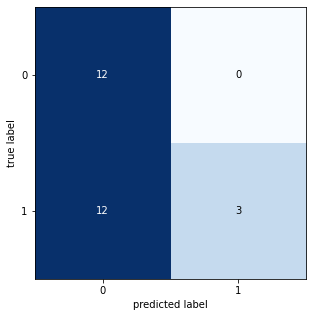

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

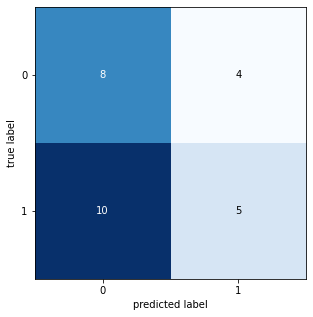

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

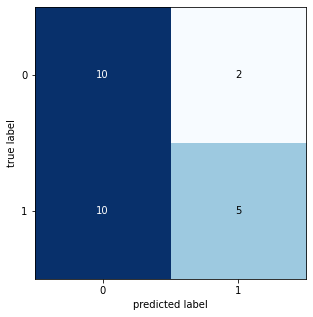

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.47438311688311696
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.36363636363636365
Running Time:  38.74529336999694
gene : [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


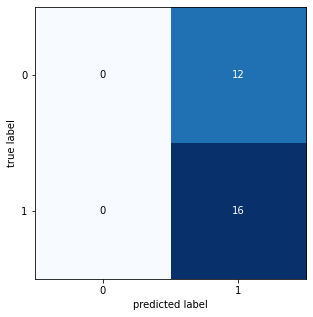

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4630681818181818
              precision    recall  f1-score   support

           0    

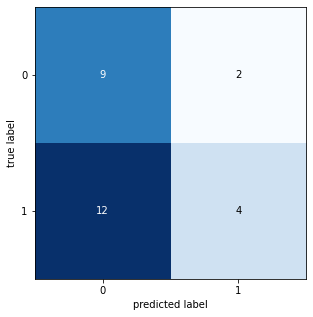

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

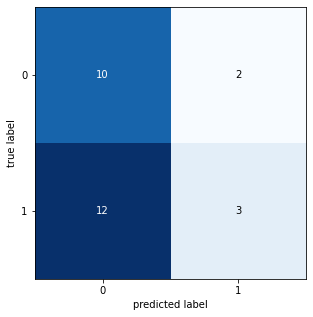

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

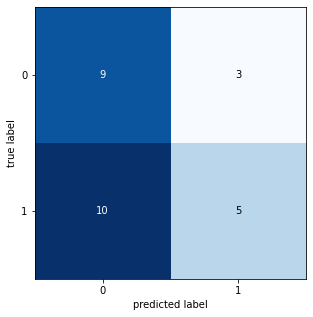

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

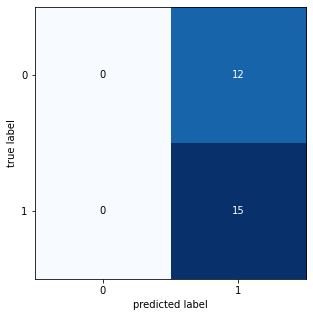

avg accuraccy Prostate Cancer =  0.5216931216931217
avg F1_Score Prostate Cancer =  0.4271357869298427
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.206465994997416
gene : [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


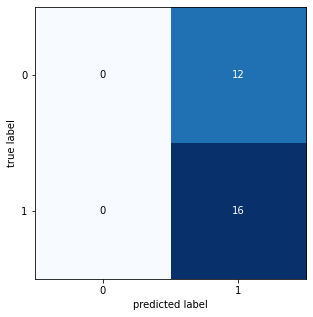

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

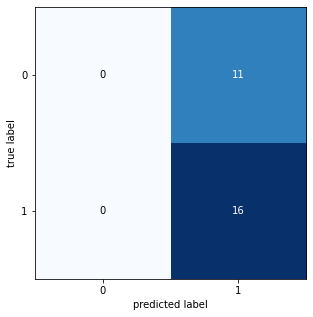

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

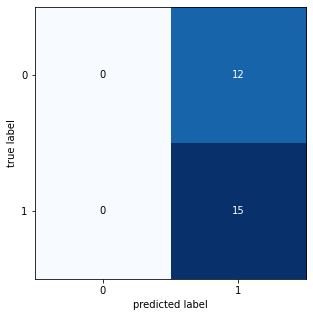

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

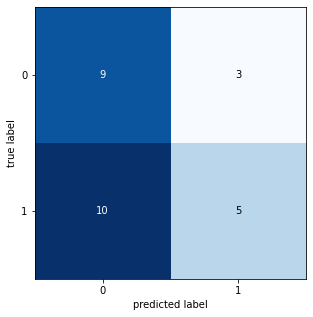

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

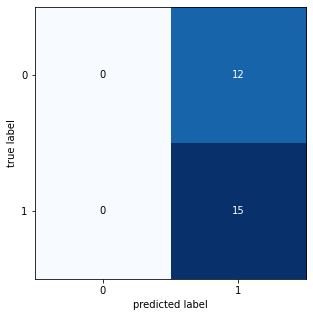

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.3915457972341759
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.862243513001886
gene : [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


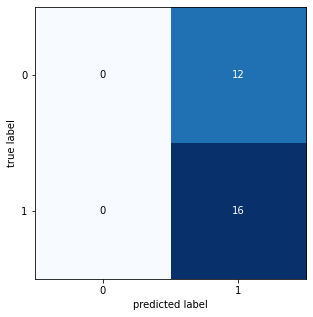

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

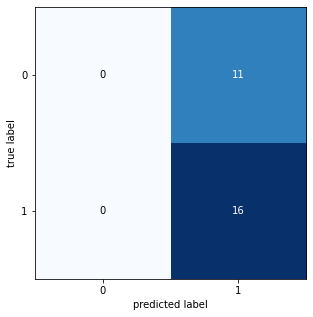

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

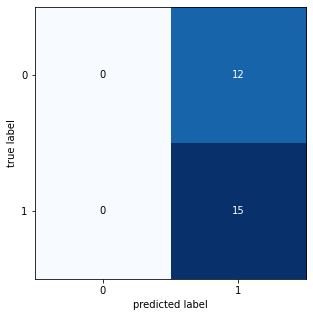

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.41666666666666663
              precision    recall  f1-score   support

           0   

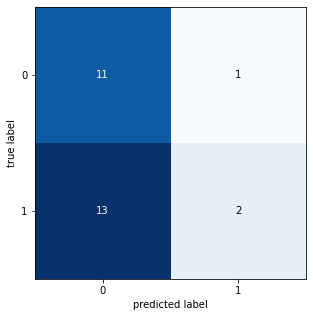

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

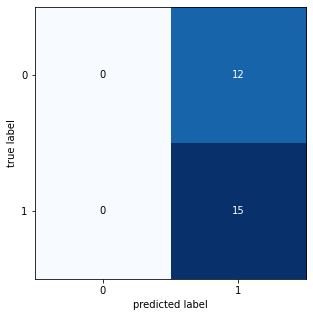

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3733363535689117
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.41666666666666663
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.44951239699731
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.47438311688311696  || Akurasi terbaik : 0.5365079365079366  || jumlah fitur : 43

Generation : 1
gene : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


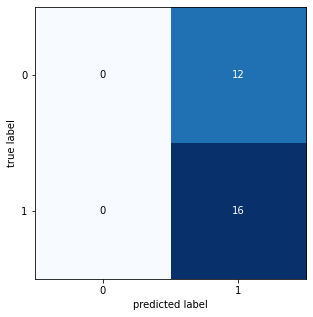

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

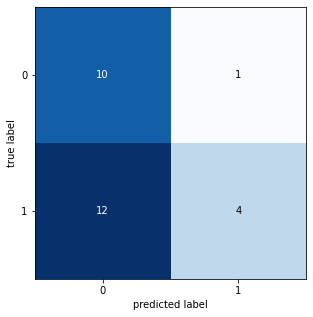

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

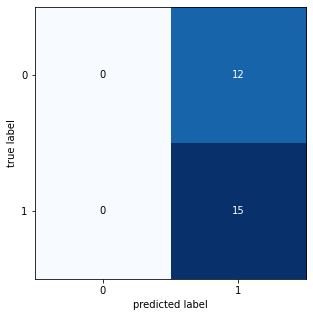

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

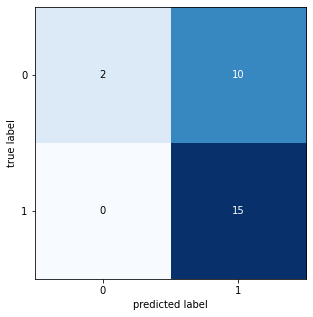

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

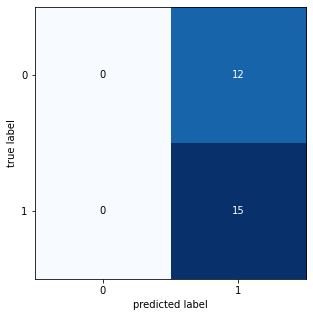

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.41785714285714287
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.540103789004206
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


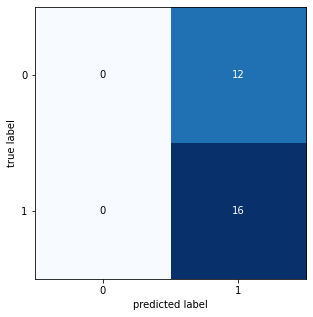

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

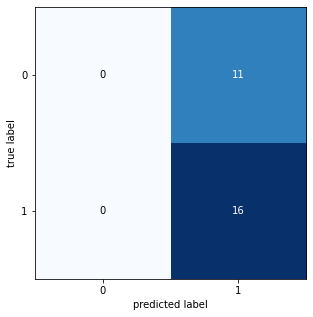

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

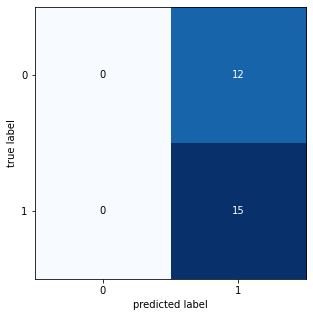

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

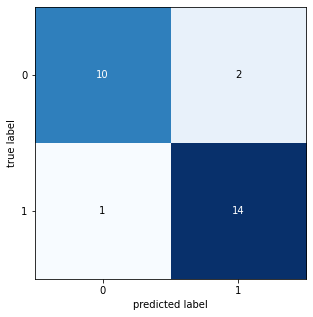

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

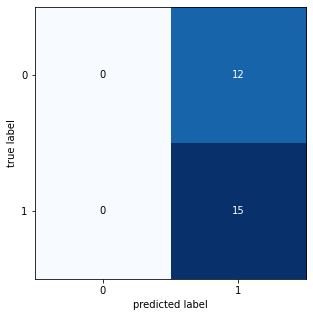

avg accuraccy Prostate Cancer =  0.6328042328042327
avg F1_Score Prostate Cancer =  0.46728212261987007
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8863955119214586
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.767402712997864
gene : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


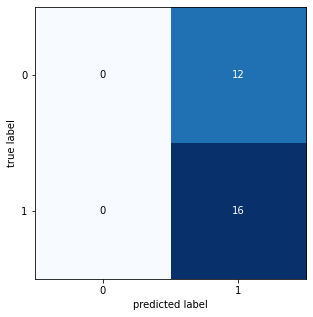

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

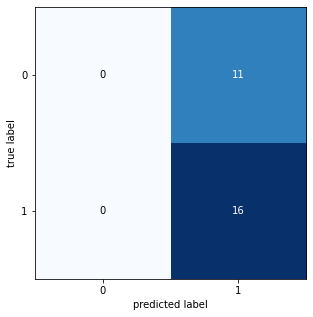

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

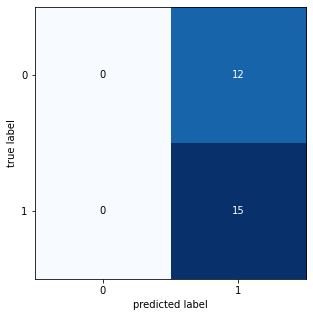

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

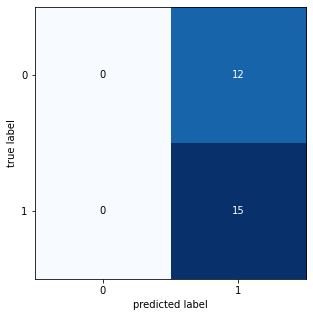

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

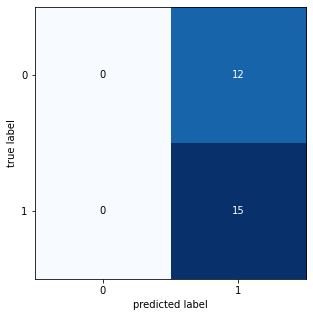

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.59370322399627
gene : [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


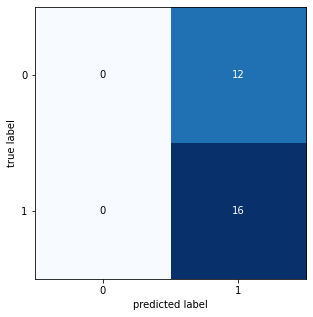

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

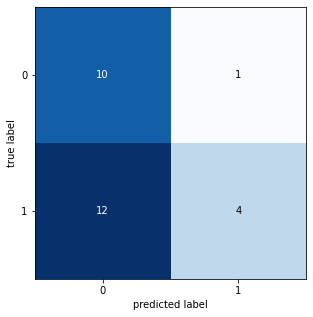

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

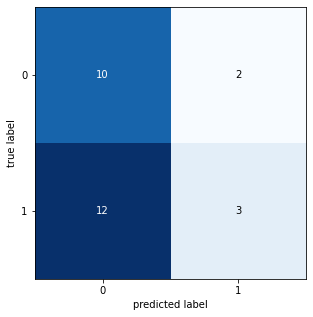

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

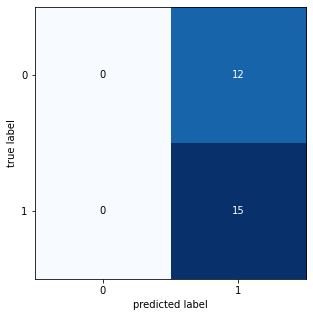

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

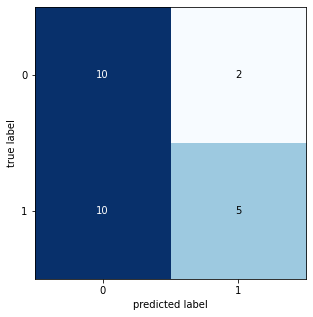

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.43963521772345304
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.47065396599646
gene : [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


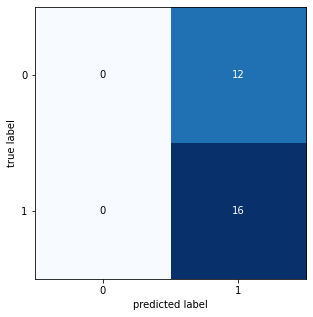

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

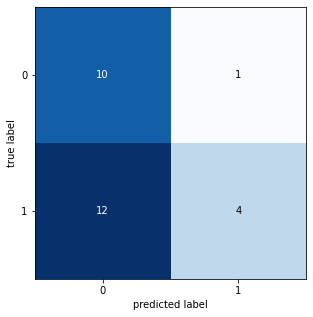

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

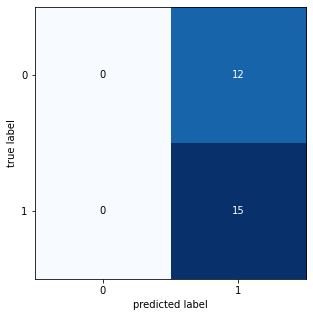

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

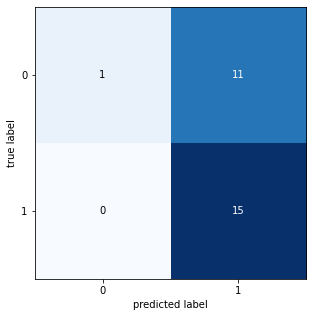

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

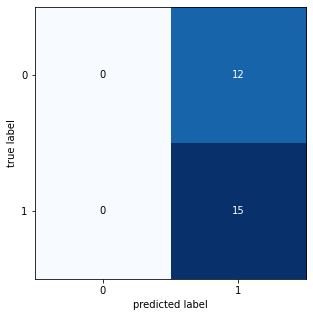

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.4028410613776468
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.37352579100116
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

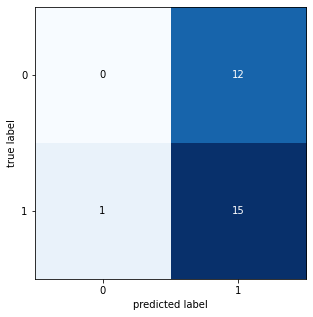

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


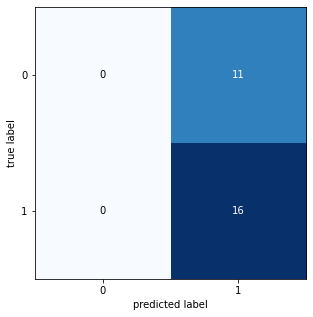

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

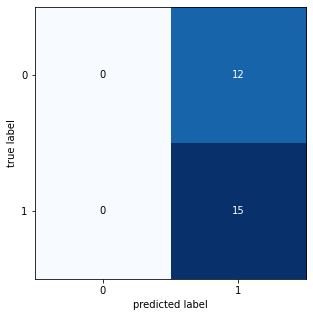

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

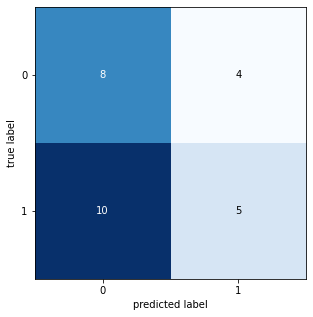

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

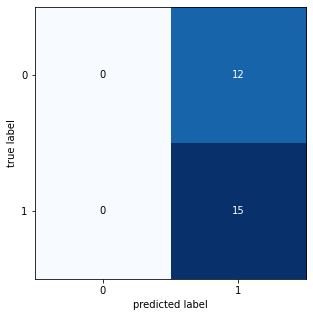

avg accuraccy Prostate Cancer =  0.5441798941798941
avg F1_Score Prostate Cancer =  0.3820431893687708
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.3488372093023256
Running Time:  38.566245846996026
gene : [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


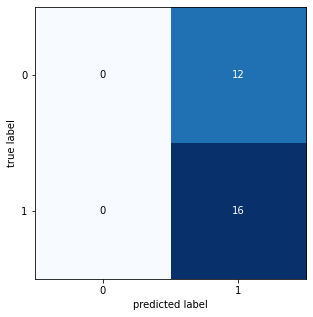

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5235294117647059
              precision    recall  f1-score   support

           0     

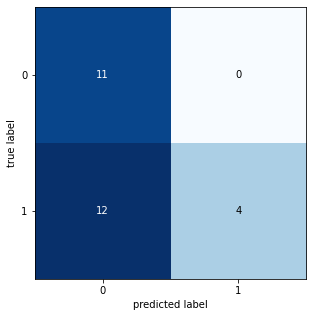

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

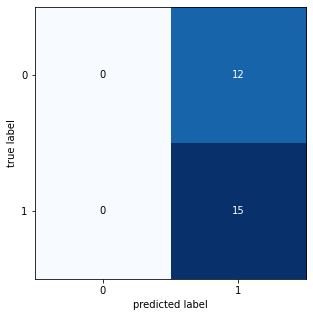

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

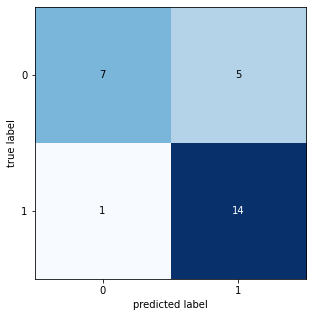

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

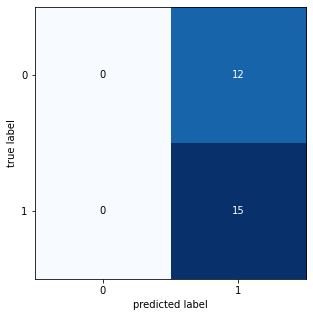

avg accuraccy Prostate Cancer =  0.6031746031746031
avg F1_Score Prostate Cancer =  0.4726432391138274
max accuraccy Prostate Cancer =  0.7777777777777778
max F1_Score Prostate Cancer =  0.7617647058823529
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.48163239900168
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


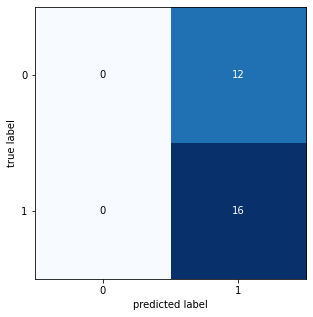

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

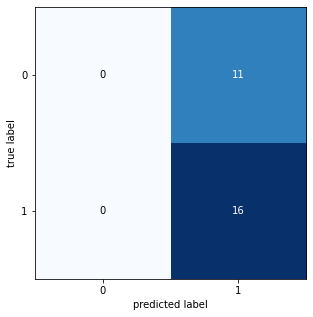

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

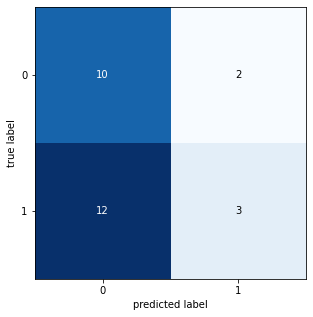

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

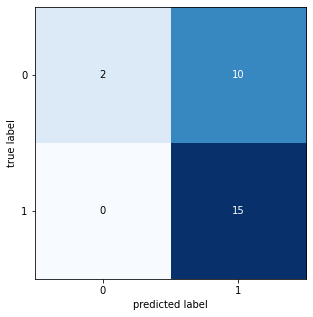

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

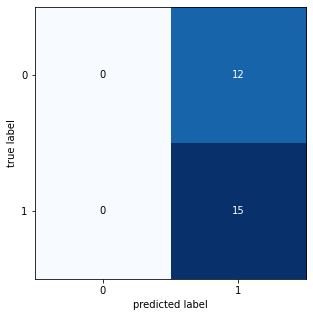

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.4109694067902002
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.53717196400248
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


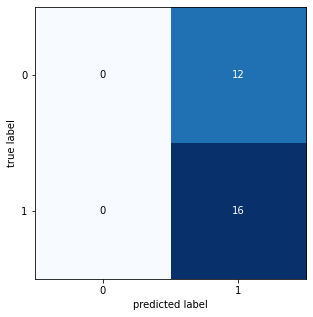

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

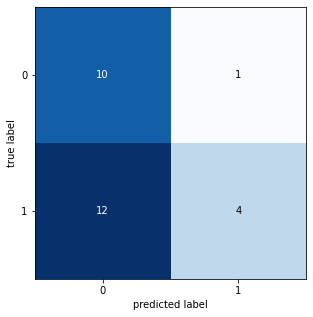

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

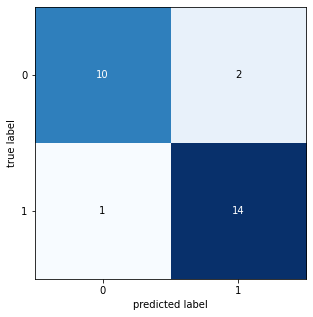

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.37037037037037035
F1_Score :  0.2702702702702703
              precision    recall  f1-score   support

           0    

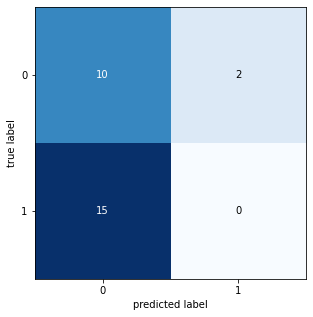

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

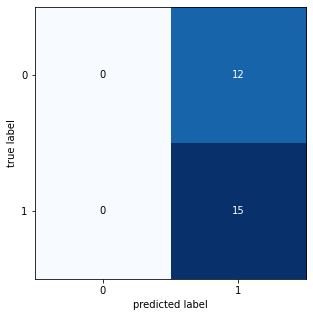

avg accuraccy Prostate Cancer =  0.5809523809523809
avg F1_Score Prostate Cancer =  0.47419029929548867
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8863955119214586
min accuraccy Prostate Cancer =  0.37037037037037035
min F1_Score Prostate Cancer =  0.2702702702702703
Running Time:  36.0900620839966
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


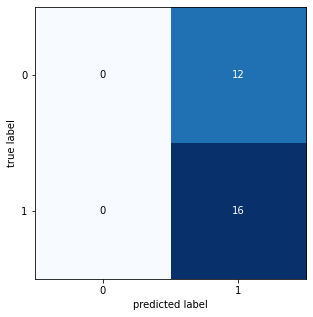

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

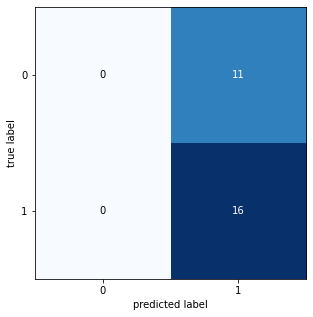

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

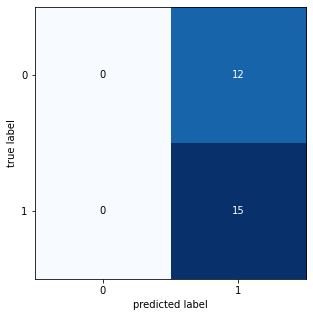

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

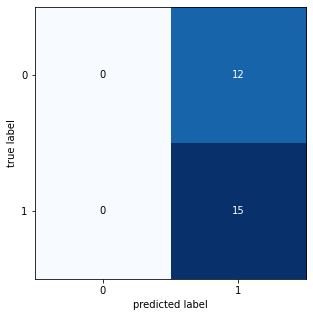

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

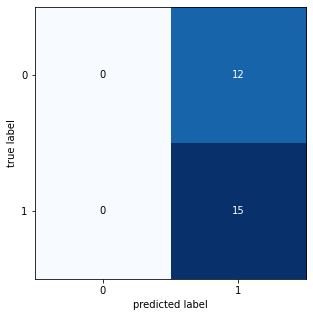

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.27623210100137
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.47438311688311696  || Akurasi terbaik : 0.5365079365079366  || jumlah fitur : 43

Generation : 2
gene : [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 

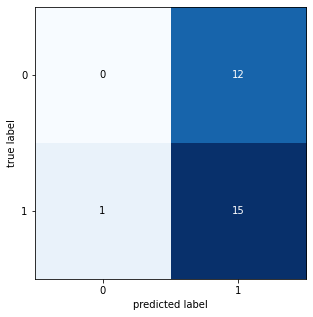

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

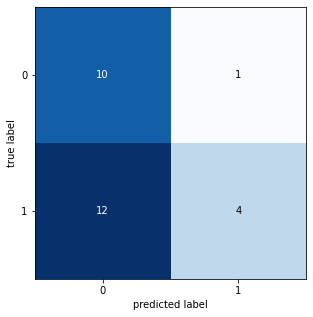

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


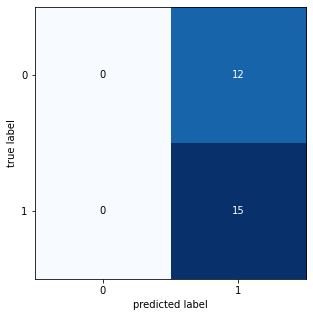

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

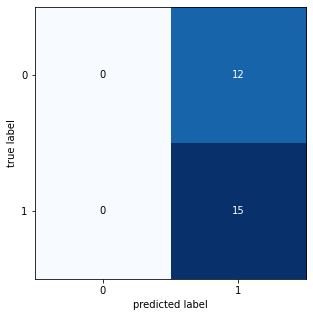

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

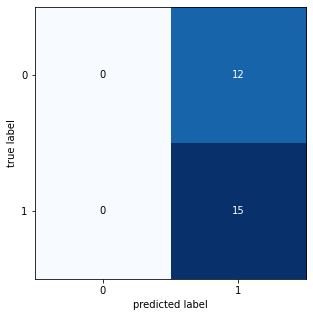

avg accuraccy Prostate Cancer =  0.5441798941798941
avg F1_Score Prostate Cancer =  0.3827544548474781
max accuraccy Prostate Cancer =  0.5555555555555556
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.3488372093023256
Running Time:  36.717458310995426
gene : [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


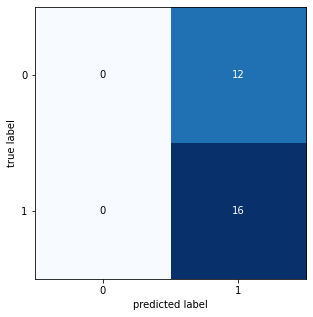

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

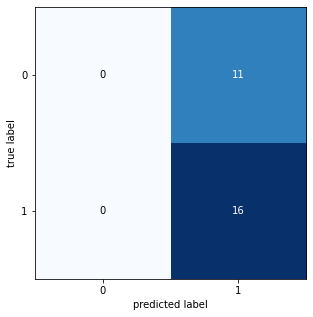

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

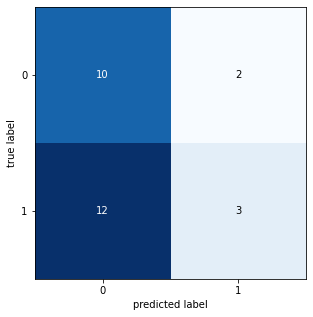

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

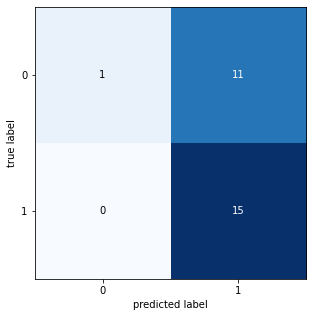

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

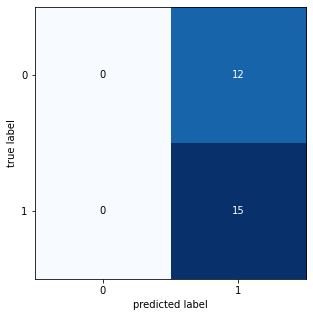

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.39595332531070415
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.29141560300195
gene : [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


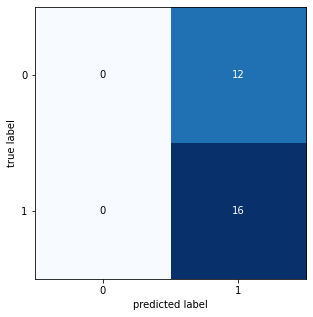

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

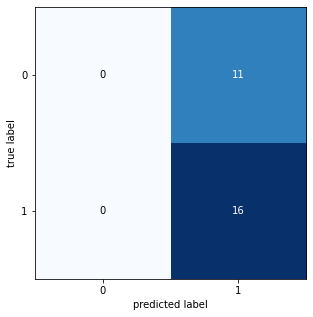

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

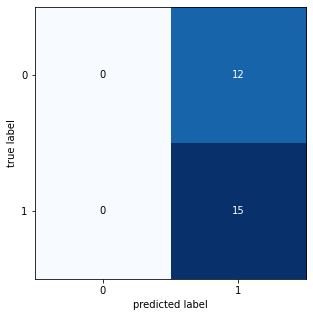

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

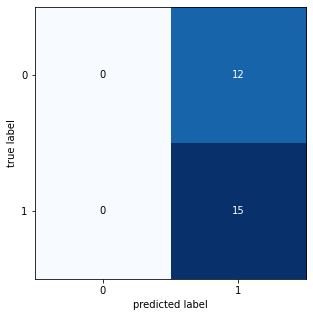

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

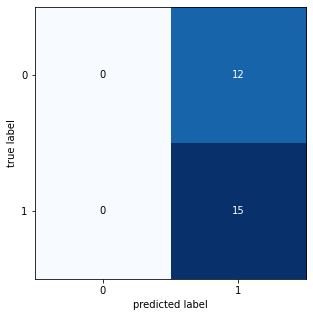

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.20312545199704
gene : [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


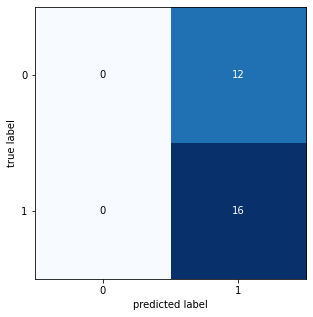

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

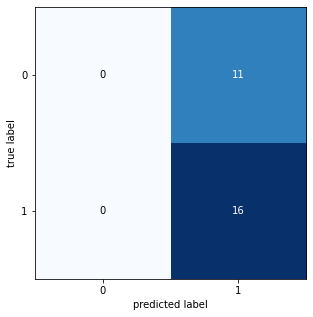

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

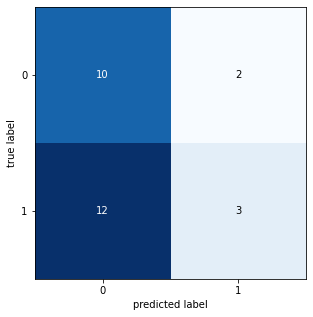

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

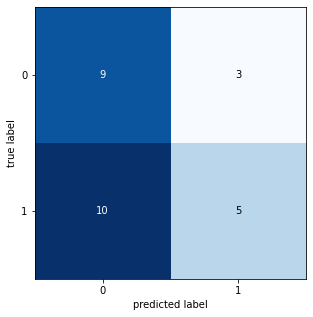

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

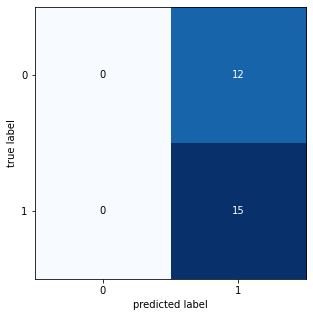

avg accuraccy Prostate Cancer =  0.5439153439153438
avg F1_Score Prostate Cancer =  0.4089407552173691
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.50033563499892
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


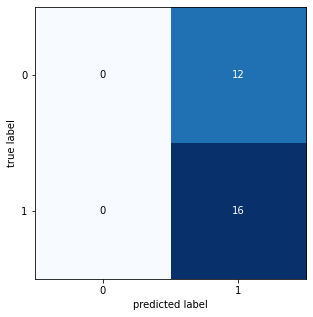

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

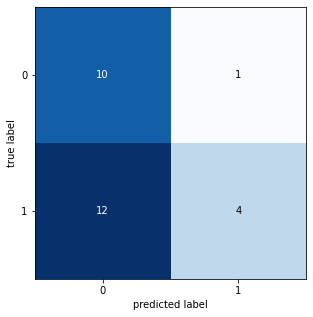

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

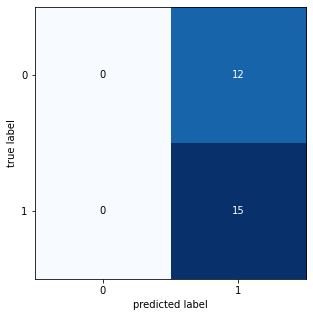

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

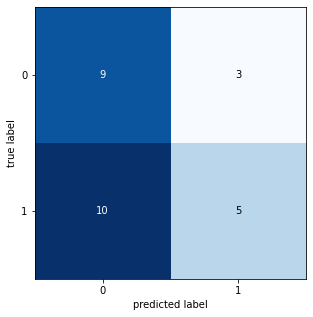

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

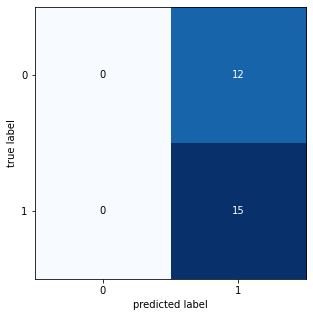

avg accuraccy Prostate Cancer =  0.5439153439153438
avg F1_Score Prostate Cancer =  0.41582849128431176
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.720204129000194
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


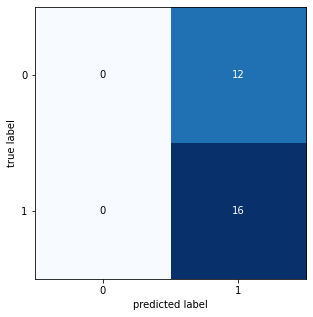

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

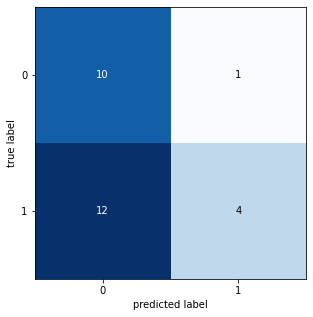

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

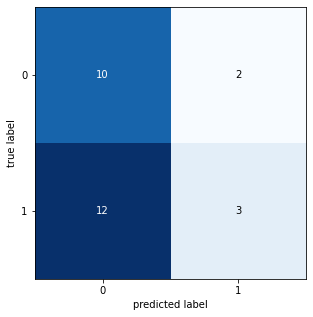

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.4444444444444444
F1_Score :  0.4319775596072932
              precision    recall  f1-score   support

           0     

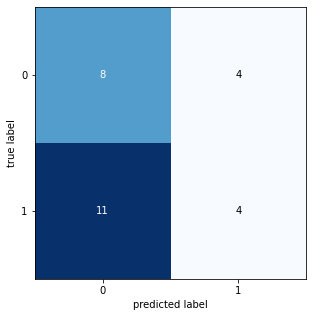

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

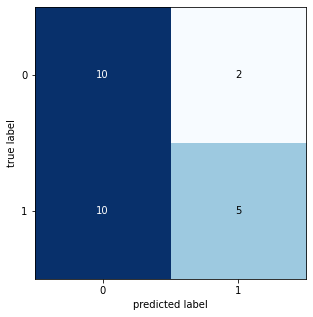

avg accuraccy Prostate Cancer =  0.5142857142857142
avg F1_Score Prostate Cancer =  0.45460215821634026
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.4444444444444444
min F1_Score Prostate Cancer =  0.36363636363636365
Running Time:  38.28931740400003
gene : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


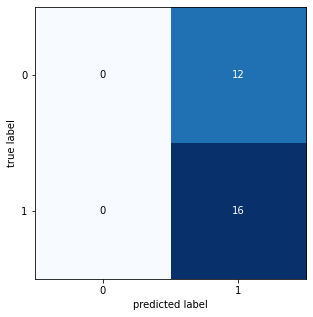

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

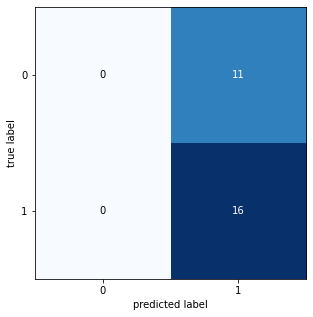

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

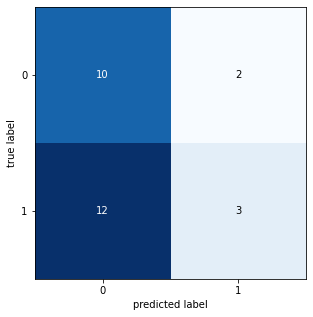

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

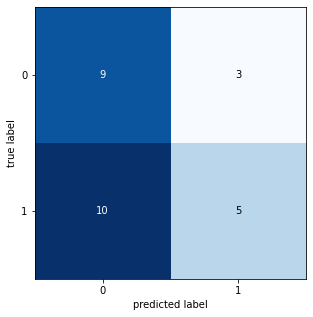

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

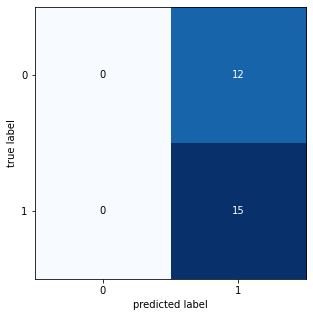

avg accuraccy Prostate Cancer =  0.5439153439153438
avg F1_Score Prostate Cancer =  0.4089407552173691
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.75043448799988
gene : [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


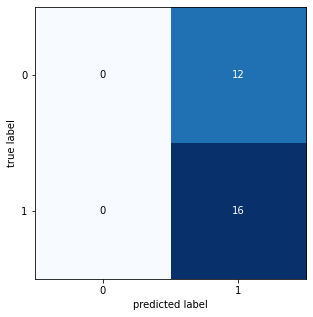

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

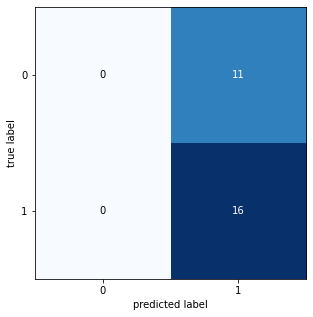

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

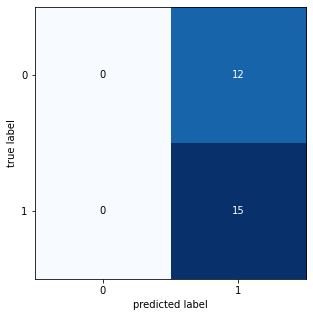

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.4444444444444444
F1_Score :  0.4155844155844156
              precision    recall  f1-score   support

           0     

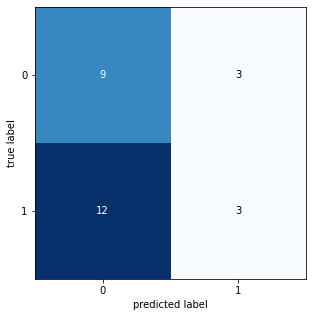

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

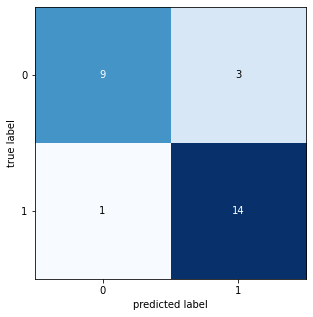

avg accuraccy Prostate Cancer =  0.6031746031746031
avg F1_Score Prostate Cancer =  0.4710095137420719
max accuraccy Prostate Cancer =  0.8518518518518519
max F1_Score Prostate Cancer =  0.8465909090909091
min accuraccy Prostate Cancer =  0.4444444444444444
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.175951154997165
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


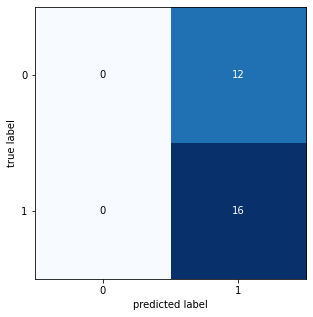

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

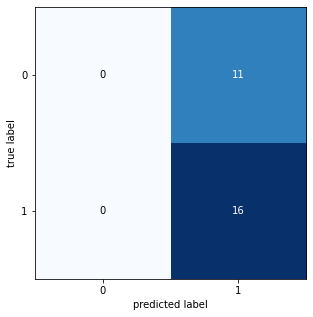

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.3414634146341463
              precision    recall  f1-score   support

           0     

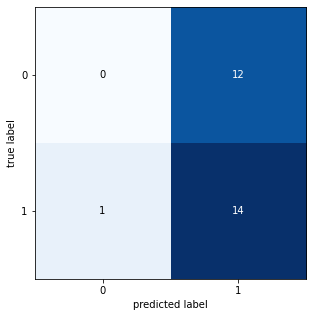

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

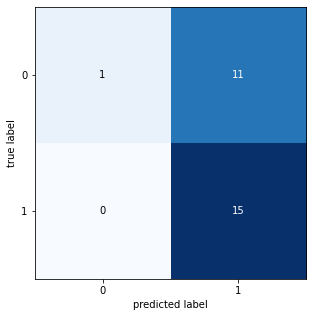

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

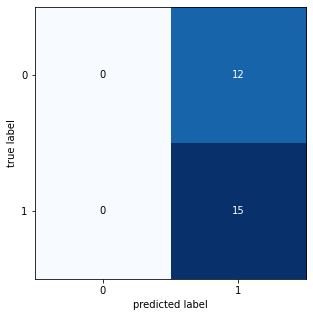

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.3754224788257687
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4427767354596623
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.3414634146341463
Running Time:  36.634398390997376
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


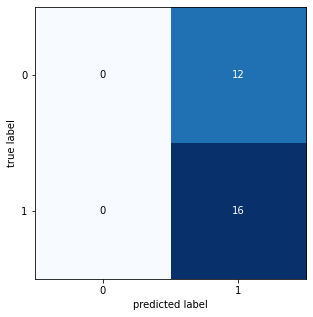

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

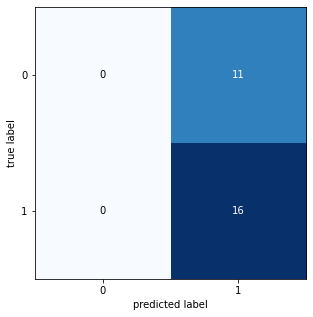

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

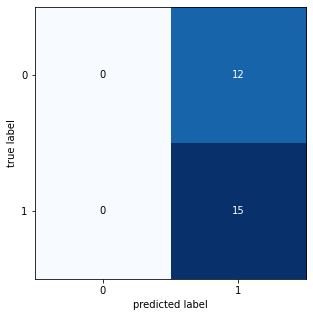

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.6447368421052632
              precision    recall  f1-score   support

           0     

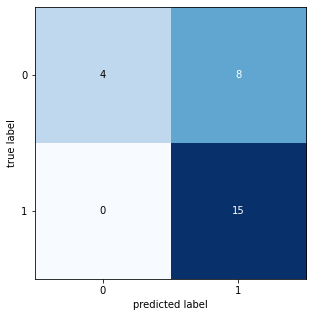

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

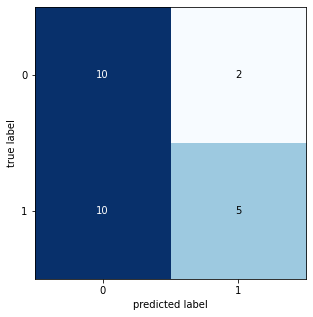

avg accuraccy Prostate Cancer =  0.5957671957671957
avg F1_Score Prostate Cancer =  0.455476362682605
max accuraccy Prostate Cancer =  0.7037037037037037
max F1_Score Prostate Cancer =  0.6447368421052632
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.23982058800175
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.47438311688311696  || Akurasi terbaik : 0.5365079365079366  || jumlah fitur : 43

Generation : 3
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


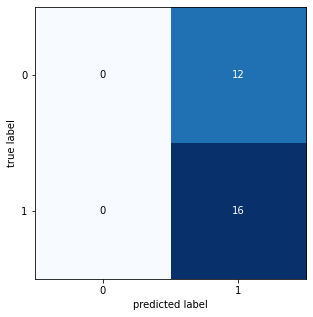

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

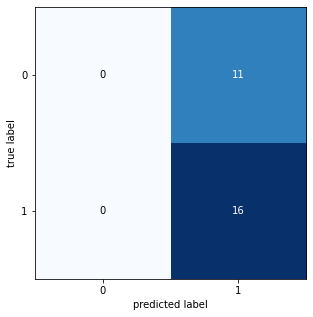

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

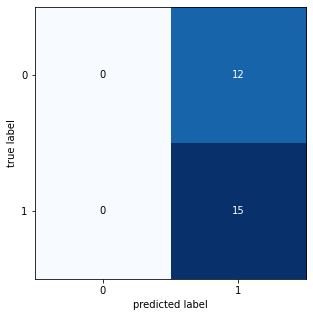

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

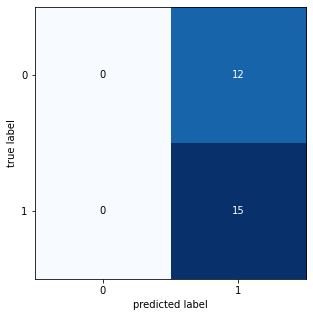

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

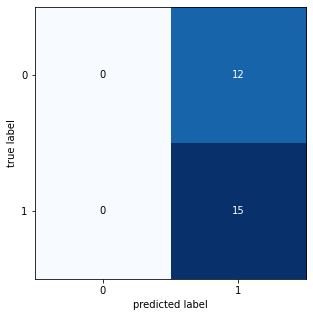

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.85432856400439
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


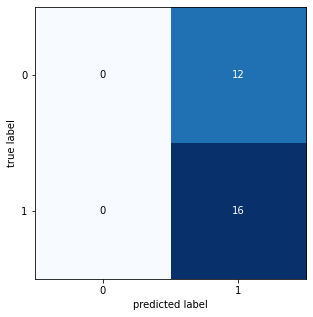

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

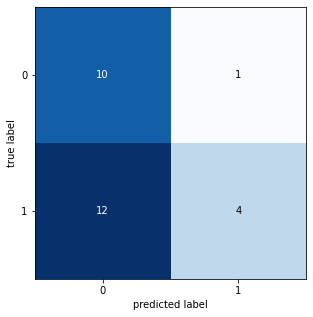

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

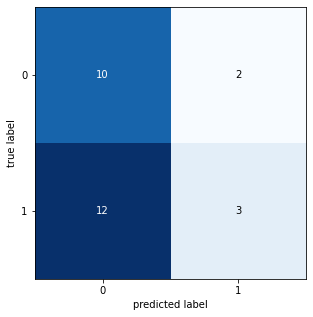

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

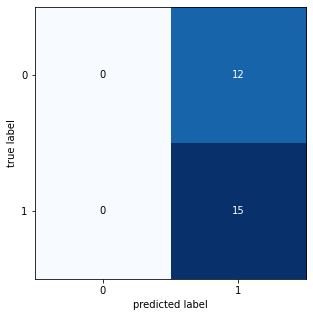

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

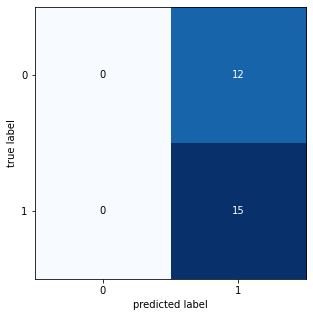

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.40310924369747897
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.03739294999832
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


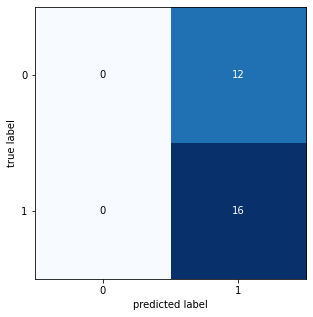

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

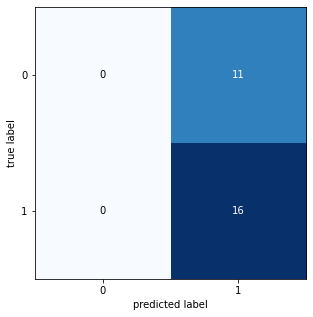

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

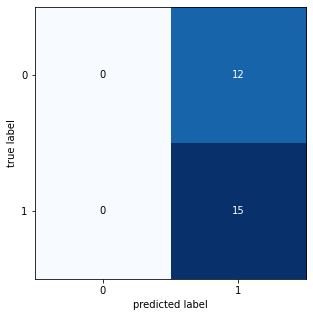

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

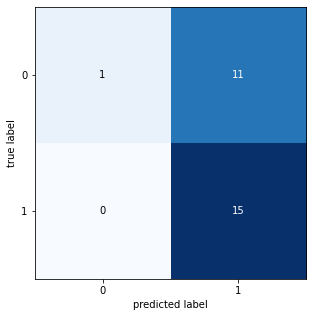

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

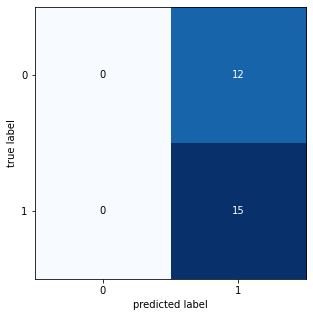

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.37855836732751086
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4427767354596623
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.55393004100188
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


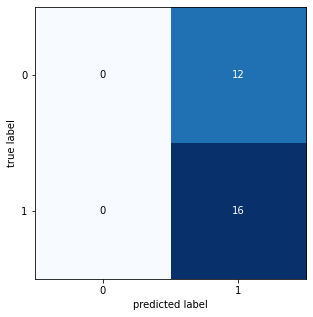

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

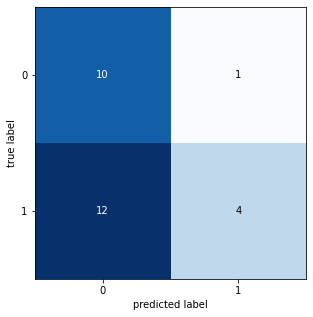

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

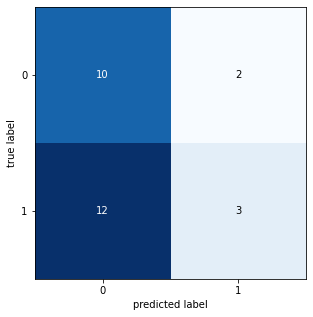

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

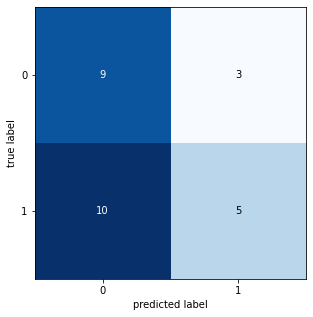

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

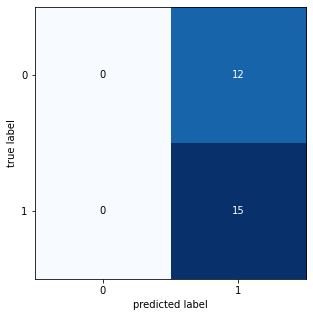

avg accuraccy Prostate Cancer =  0.5291005291005291
avg F1_Score Prostate Cancer =  0.43322344926750506
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.26277812599437
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

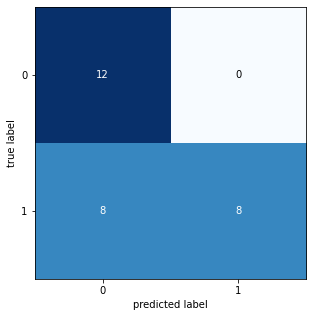

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

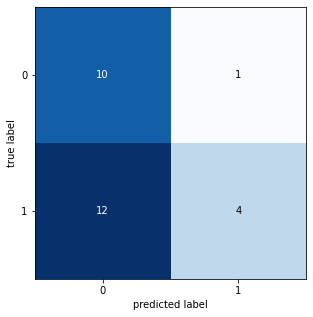

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


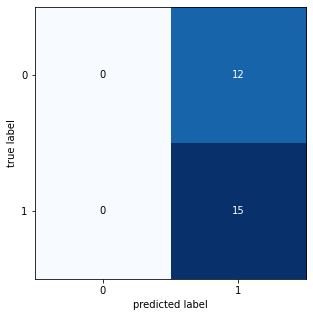

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

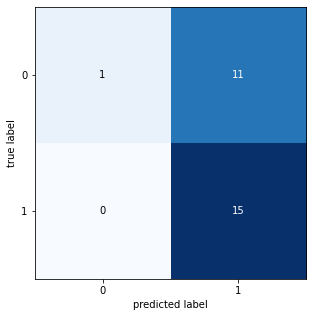

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

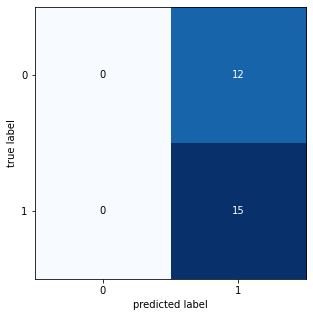

avg accuraccy Prostate Cancer =  0.5873015873015873
avg F1_Score Prostate Cancer =  0.47178045531704066
max accuraccy Prostate Cancer =  0.7142857142857143
max F1_Score Prostate Cancer =  0.7083333333333333
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.49035286399885
gene : [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


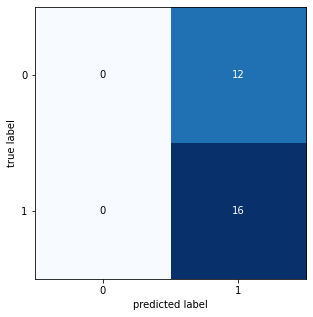

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

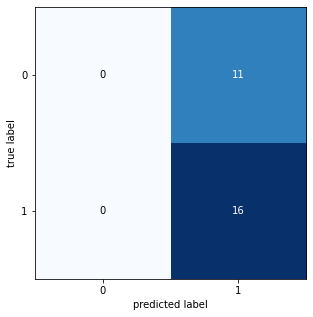

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

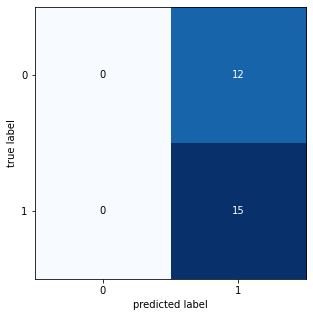

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

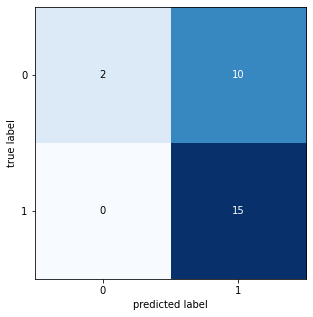

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

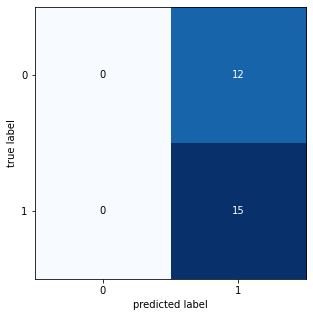

avg accuraccy Prostate Cancer =  0.580952380952381
avg F1_Score Prostate Cancer =  0.3935744488070069
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.65818197000044
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


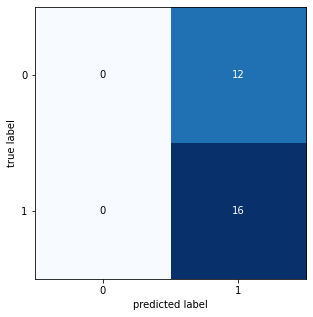

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

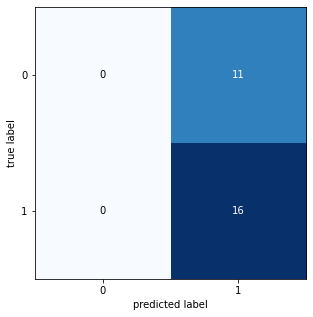

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

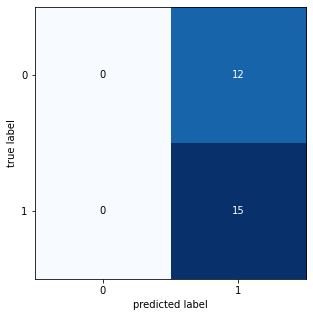

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

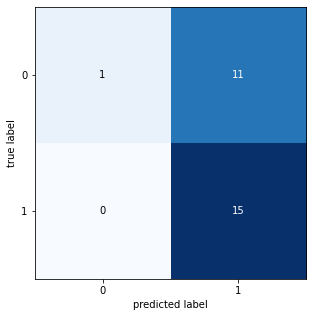

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

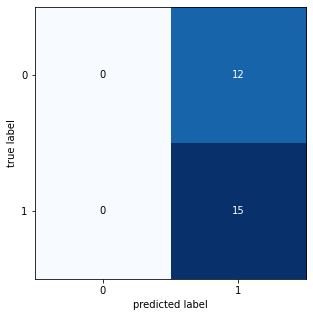

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.37855836732751086
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4427767354596623
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.87000418700336
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


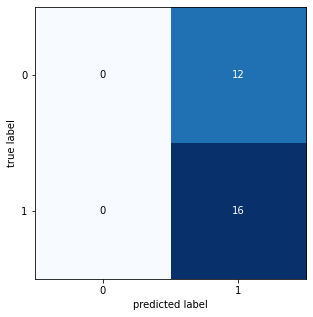

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

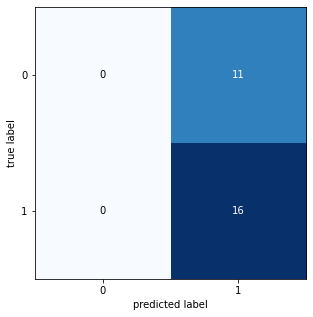

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

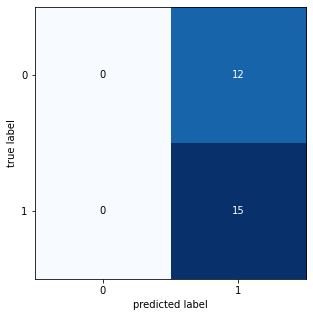

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

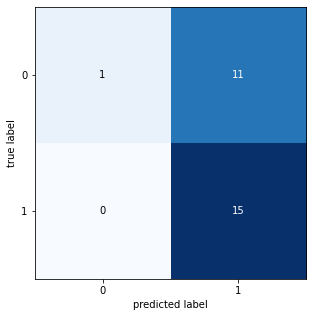

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

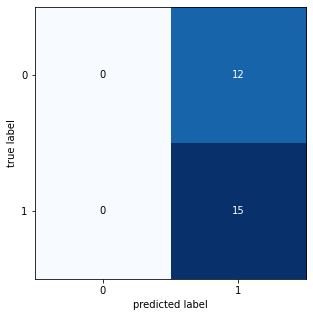

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.37855836732751086
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4427767354596623
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.048365681002906
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


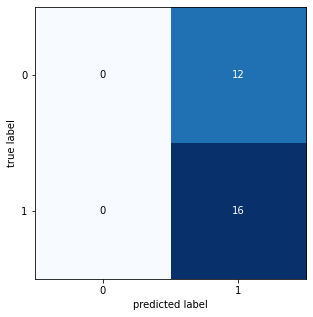

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

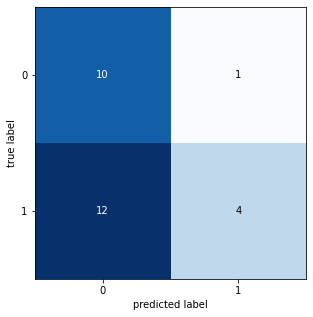

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

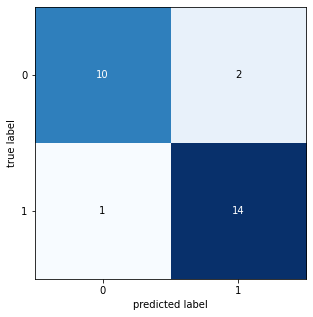

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

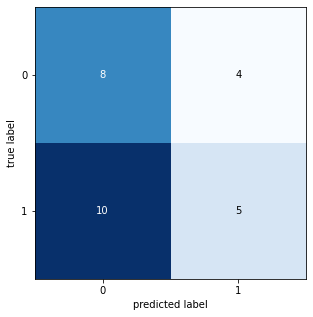

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

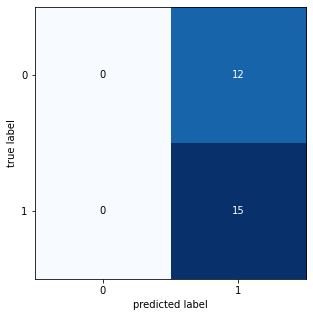

avg accuraccy Prostate Cancer =  0.6031746031746031
avg F1_Score Prostate Cancer =  0.5151362452414345
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8863955119214586
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.784260640000866
gene : [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


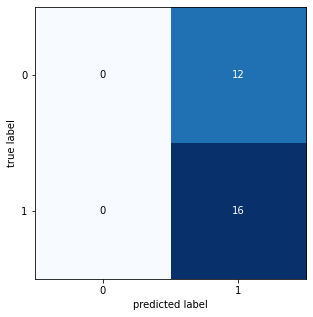

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

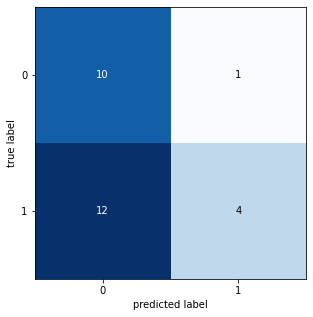

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

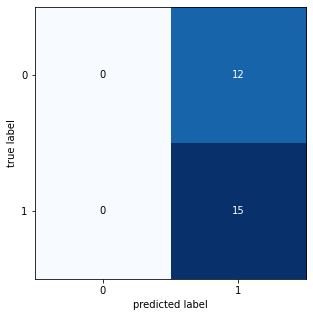

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

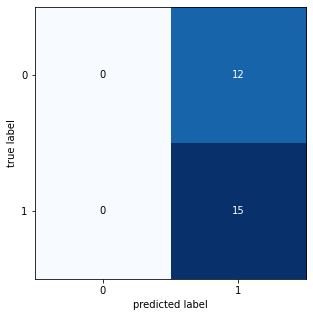

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

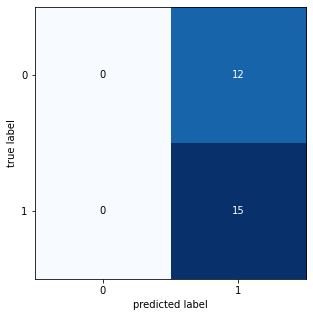

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.693646577994514
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.5151362452414345  || Akurasi terbaik : 0.6031746031746031  || jumlah fitur : 43

Generation : 4
gene : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


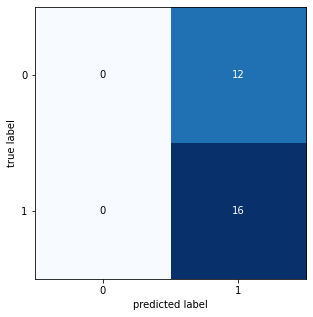

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

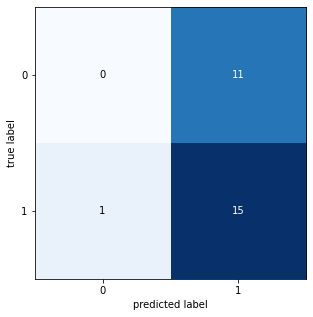

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

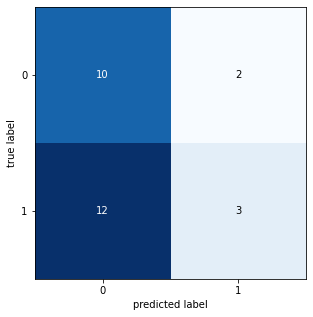

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

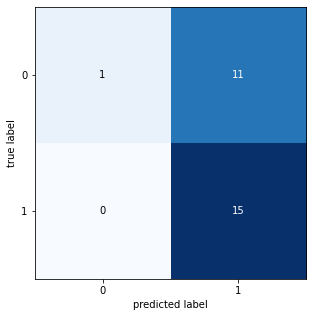

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

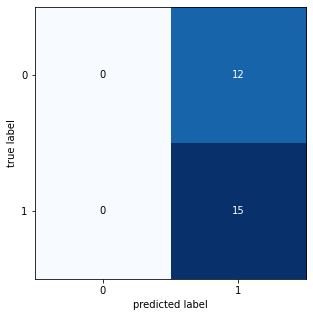

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.39296329208811276
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.72361299399927
gene : [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


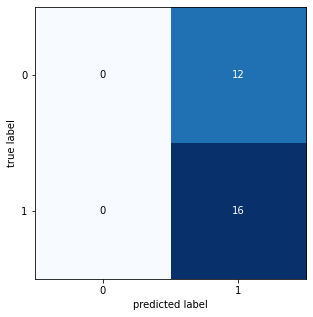

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

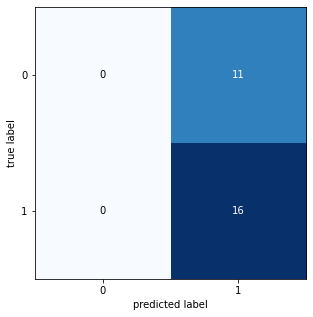

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

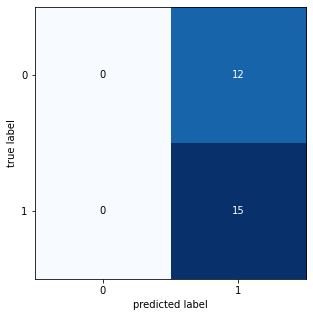

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

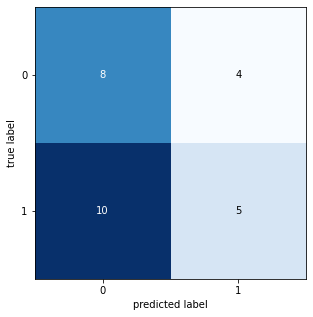

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

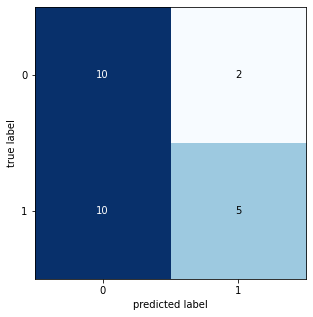

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.4215289942615524
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.05610508999962
gene : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


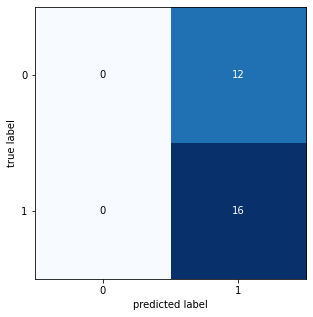

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

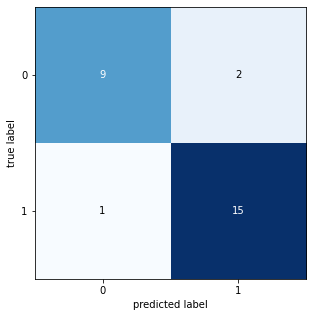

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

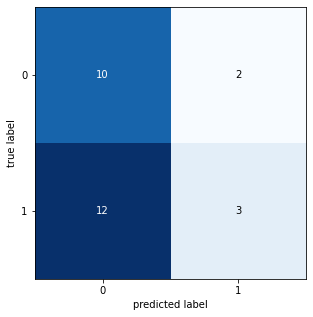

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

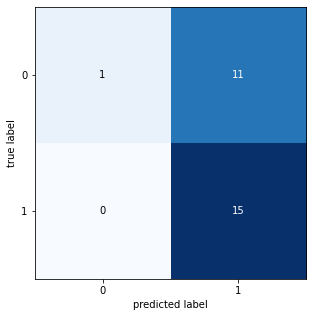

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

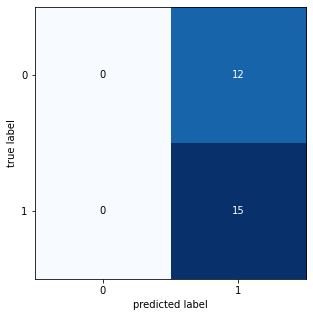

avg accuraccy Prostate Cancer =  0.6179894179894179
avg F1_Score Prostate Cancer =  0.49815809728291793
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8831168831168832
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.238571800997306
gene : [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


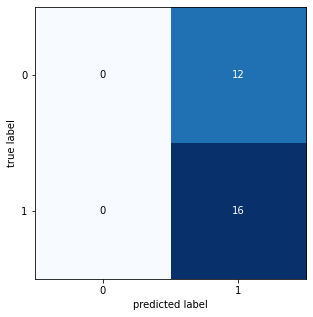

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

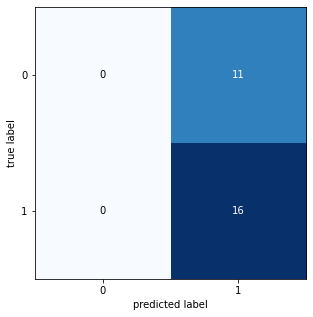

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

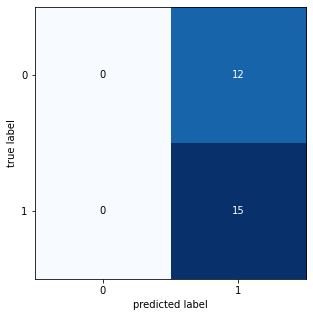

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

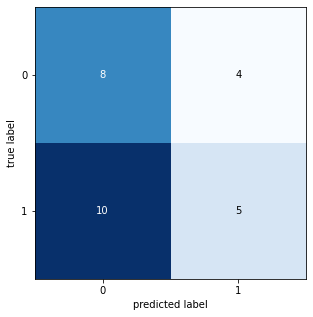

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

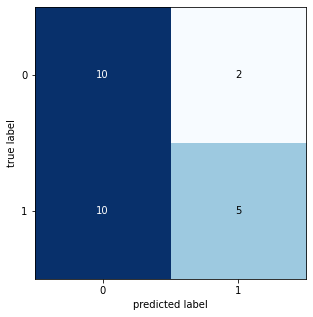

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.4215289942615524
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.11019140199642
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


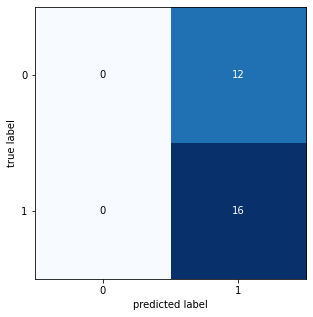

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

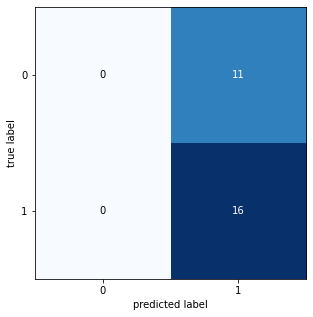

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

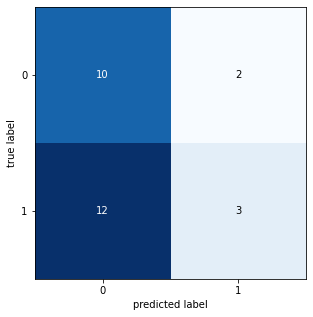

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

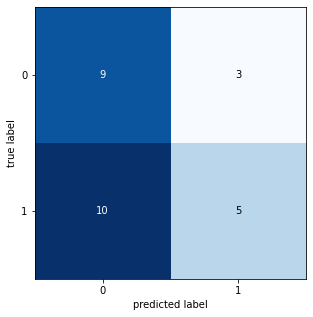

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

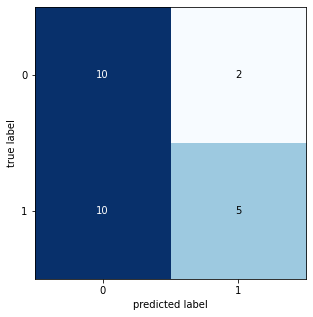

avg accuraccy Prostate Cancer =  0.5439153439153438
avg F1_Score Prostate Cancer =  0.4454667292433432
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.36363636363636365
Running Time:  35.99930870699609
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

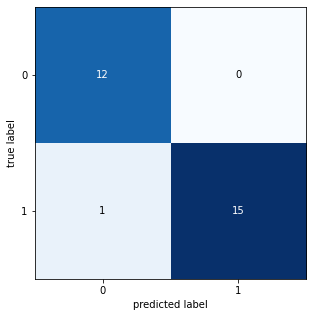

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


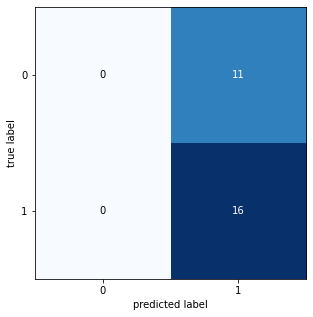

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

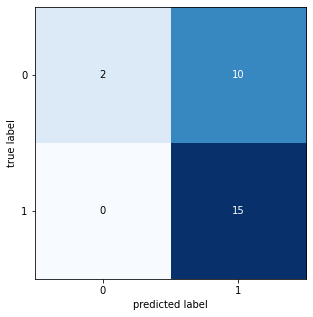

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.49230769230769234
              precision    recall  f1-score   support

           0    

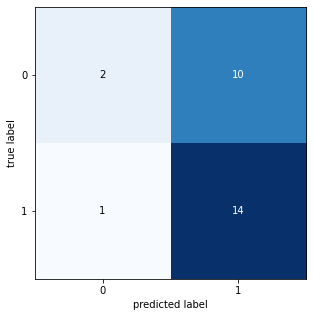

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

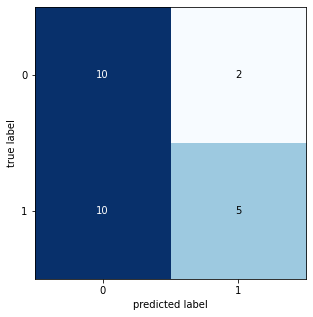

avg accuraccy Prostate Cancer =  0.6669312169312169
avg F1_Score Prostate Cancer =  0.5771803106870624
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.37209302325581395
Running Time:  37.86295383900142
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


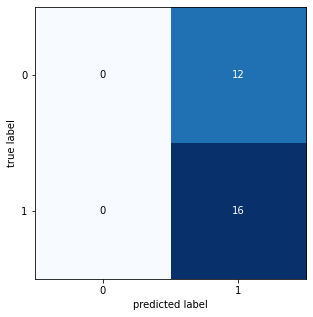

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

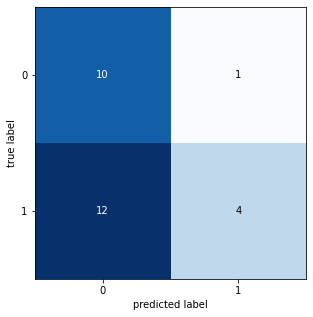

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

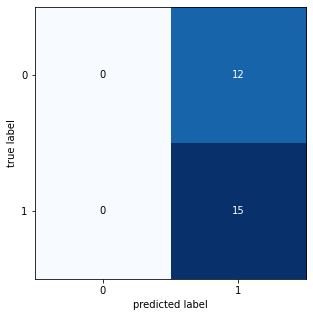

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

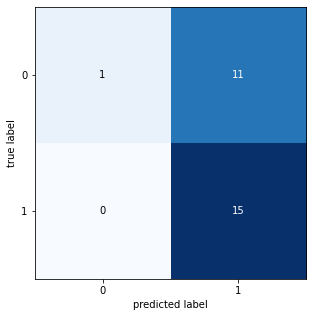

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.3414634146341463
              precision    recall  f1-score   support

           0     

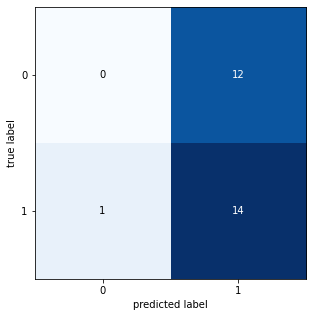

avg accuraccy Prostate Cancer =  0.5513227513227513
avg F1_Score Prostate Cancer =  0.39970517287590457
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.3414634146341463
Running Time:  37.24737893800193
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


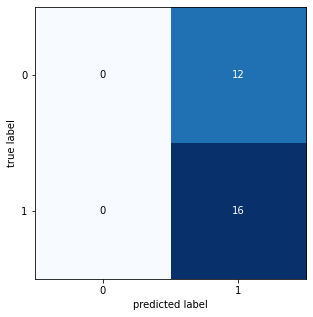

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

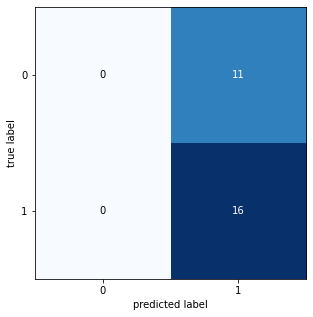

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

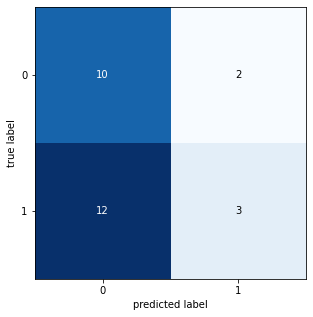

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

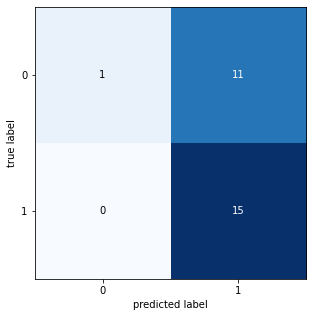

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

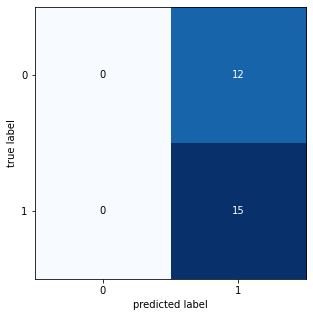

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.39595332531070415
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.03836963199865
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


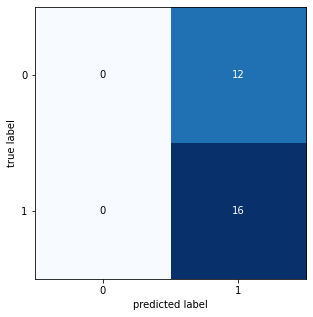

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

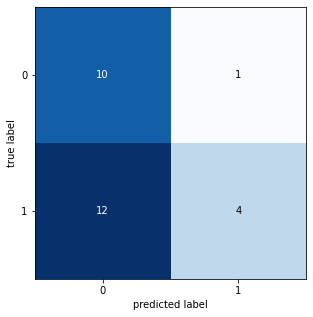

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

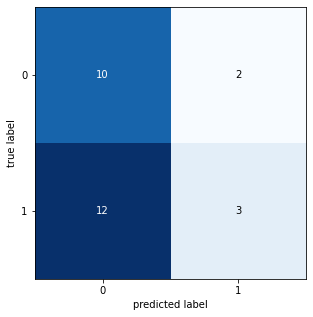

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

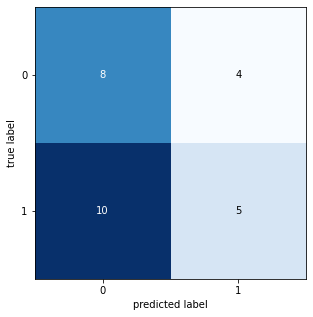

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

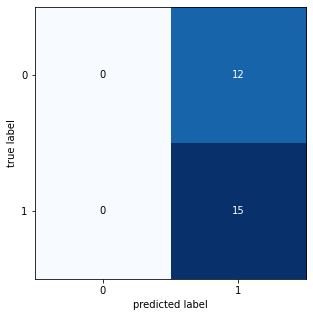

avg accuraccy Prostate Cancer =  0.5216931216931217
avg F1_Score Prostate Cancer =  0.42668067226890755
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.40419775400369
gene : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


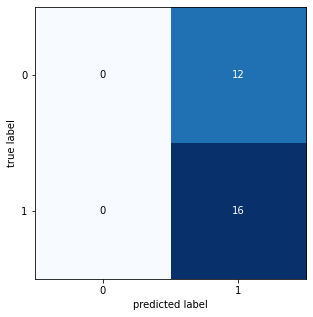

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

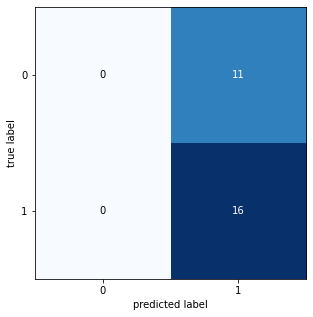

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

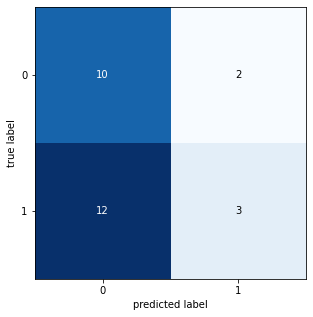

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6666666666666666
F1_Score :  0.6136724960254372
              precision    recall  f1-score   support

           0     

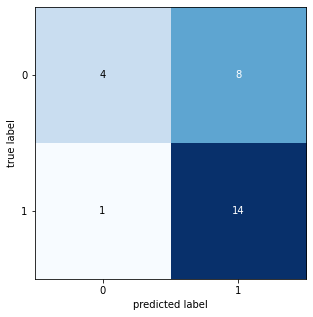

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

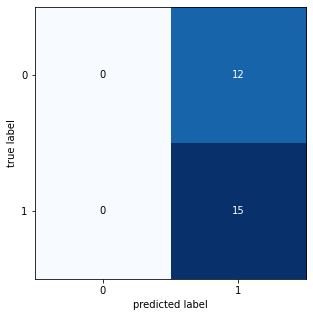

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.43013247742385907
max accuraccy Prostate Cancer =  0.6666666666666666
max F1_Score Prostate Cancer =  0.6136724960254372
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.5460115829992
gen terbaik : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.5771803106870624  || Akurasi terbaik : 0.6669312169312169  || jumlah fitur : 55

Running Time:  1846.5035289279986


In [14]:
Prostate_IG_GA = GeneticAlgorithm(Prostate_IG, 3)

Generation : 0
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


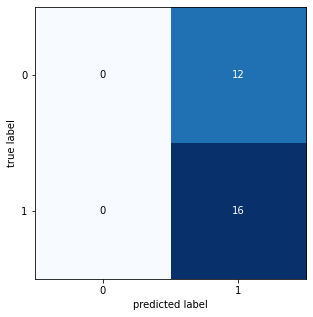

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

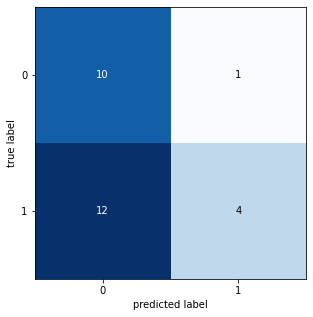

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

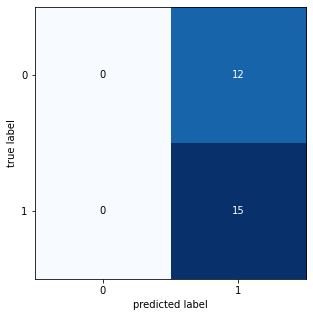

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.555921052631579
              precision    recall  f1-score   support

           0      

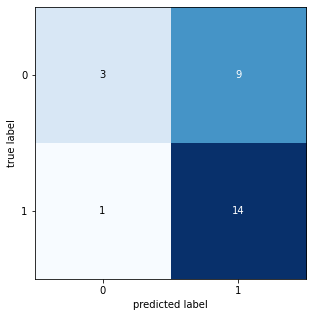

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

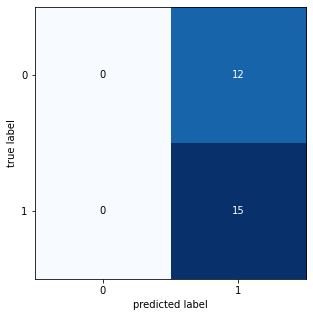

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.42546992481203005
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.555921052631579
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.2607109429955
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


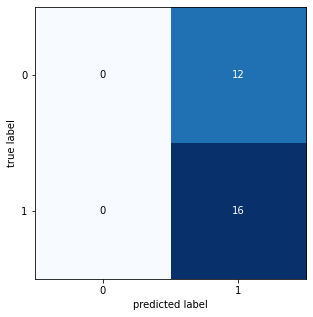

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

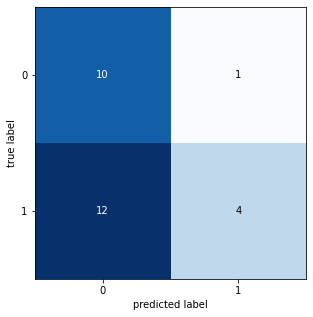

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

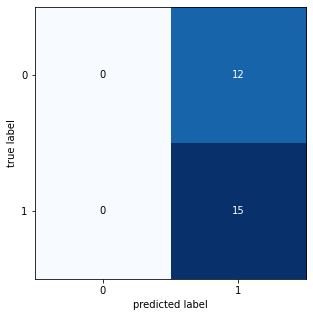

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

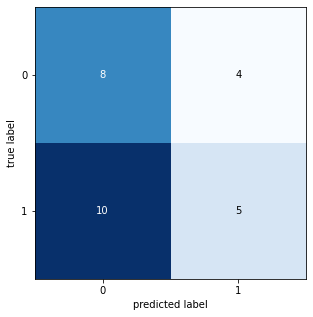

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

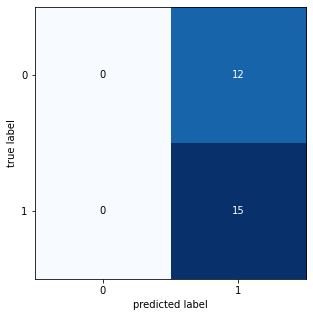

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.916277711003204
gene : [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


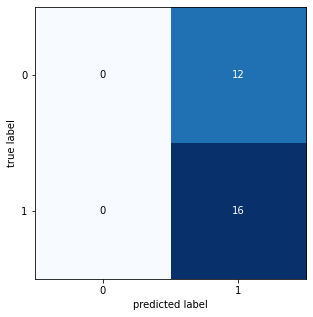

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

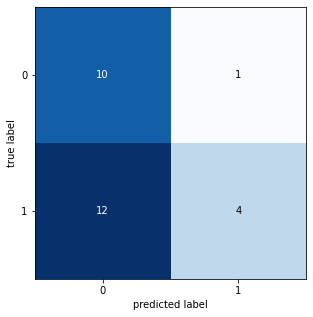

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

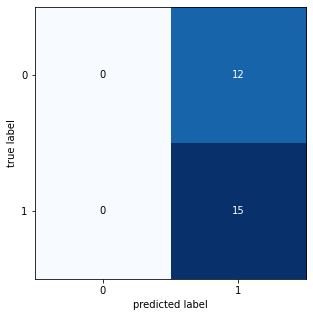

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

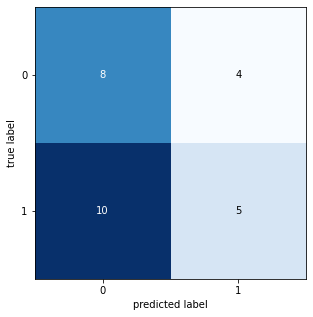

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

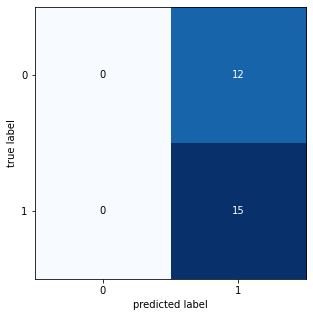

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.10098721499526
gene : [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

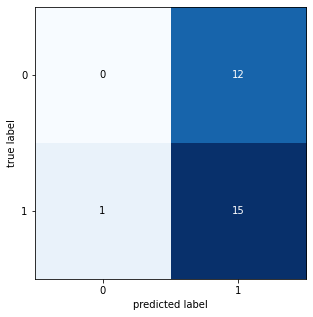

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


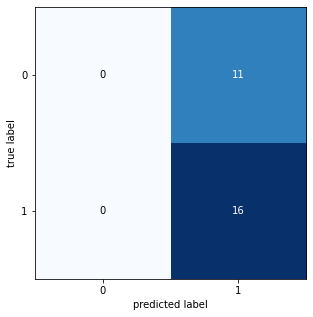

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

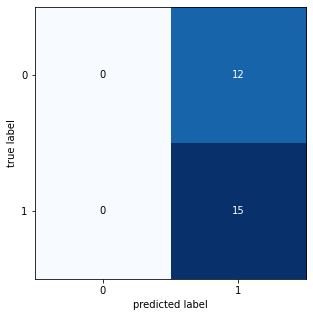

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

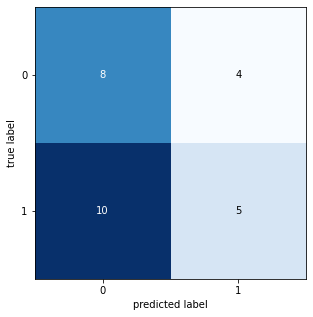

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

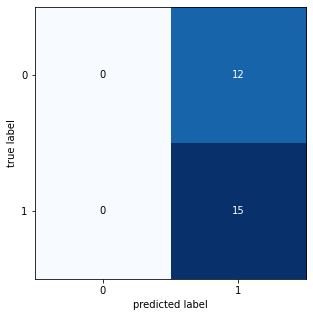

avg accuraccy Prostate Cancer =  0.5441798941798941
avg F1_Score Prostate Cancer =  0.3820431893687708
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.3488372093023256
Running Time:  38.88604311000381
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


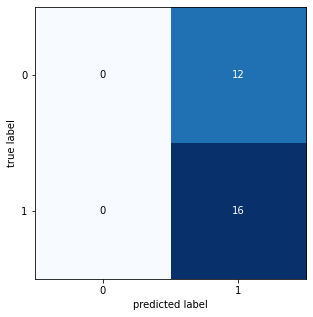

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

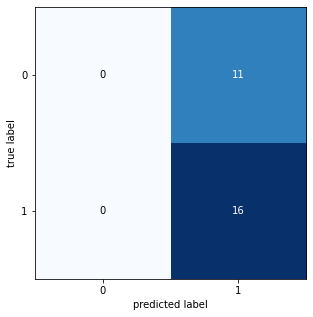

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

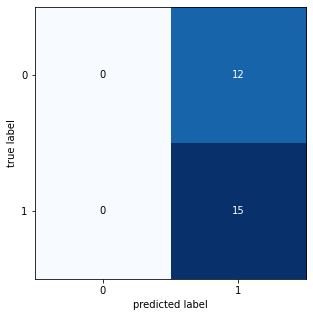

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

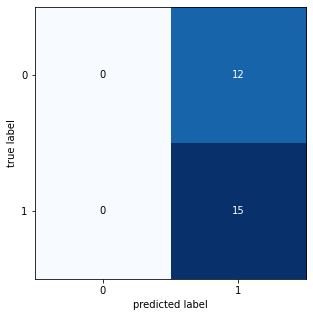

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

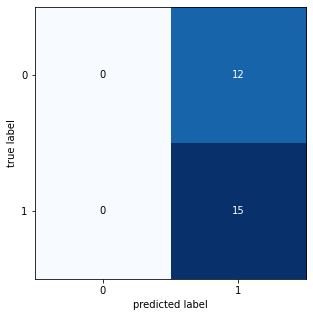

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.27053539700137
gene : [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


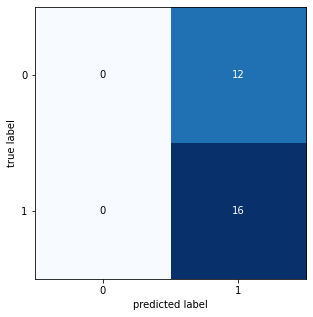

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

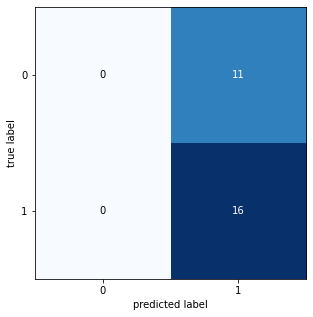

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

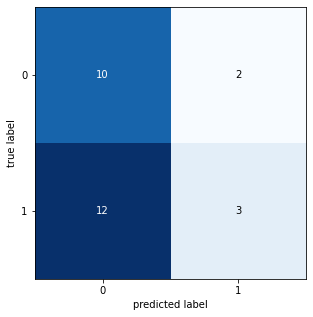

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

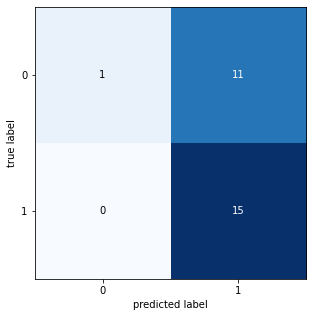

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

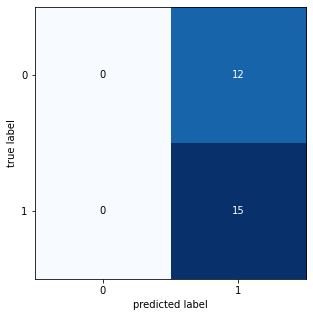

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.39595332531070415
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.4696725649992
gene : [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


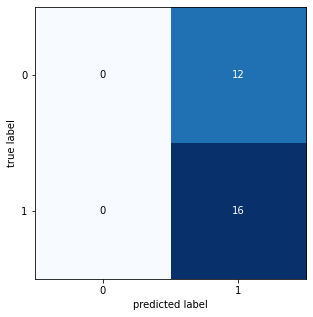

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

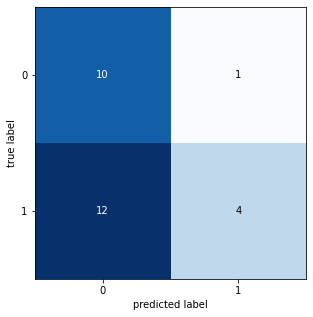

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

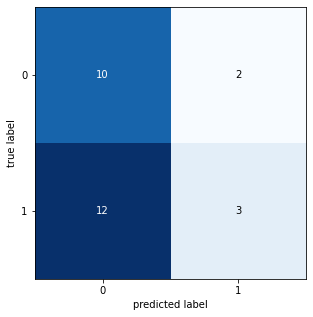

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

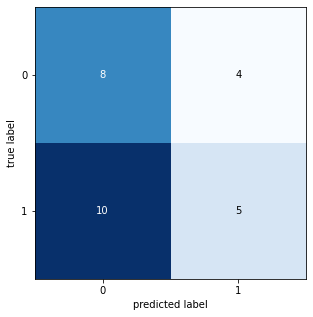

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

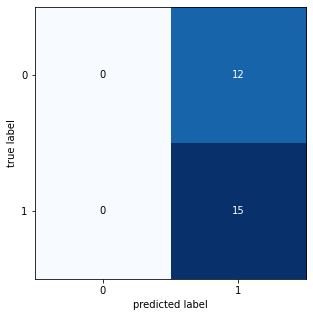

avg accuraccy Prostate Cancer =  0.5216931216931217
avg F1_Score Prostate Cancer =  0.42668067226890755
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.42557057100203
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


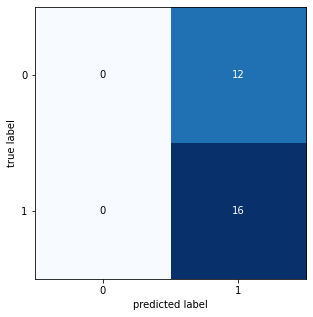

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

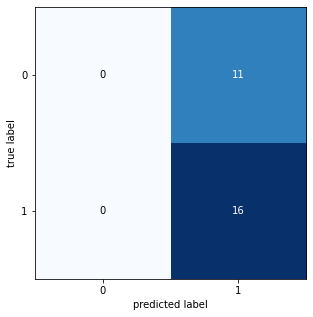

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

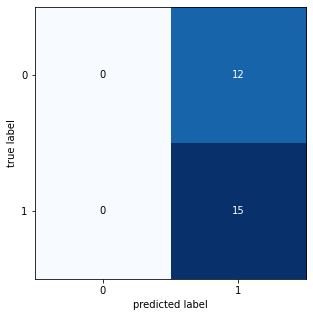

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

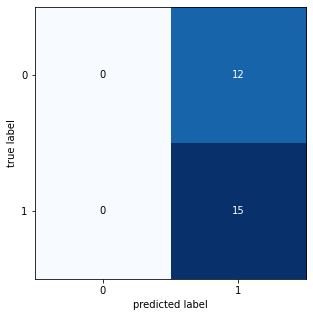

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

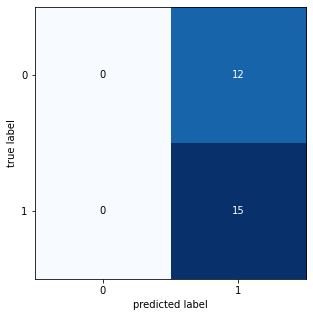

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.25151726700278
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


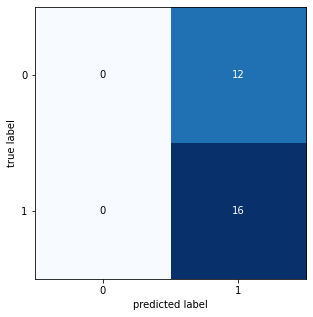

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

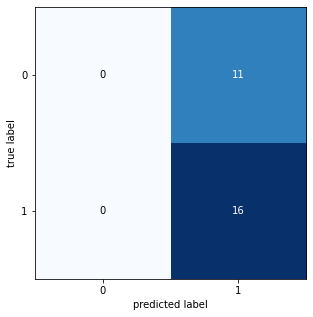

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

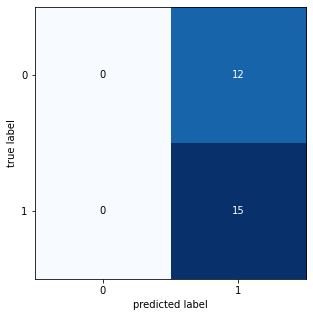

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

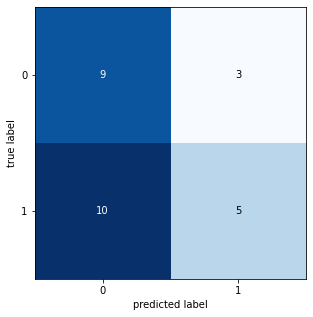

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

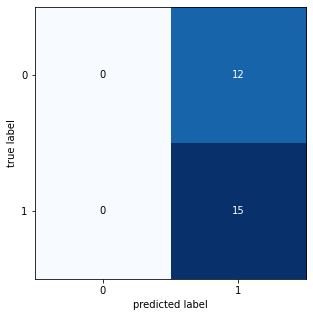

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.3915457972341759
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.01783603399963
gene : [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


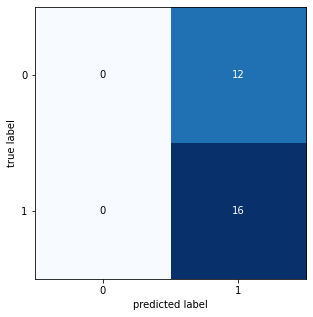

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

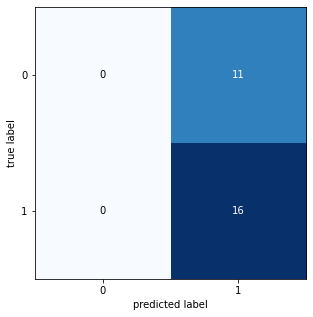

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

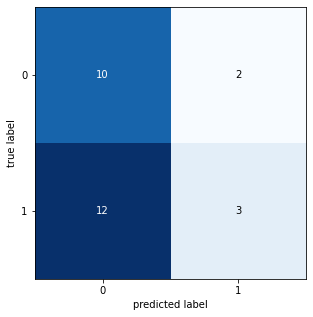

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

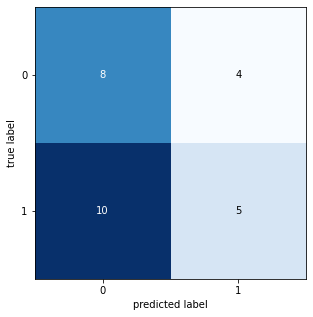

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

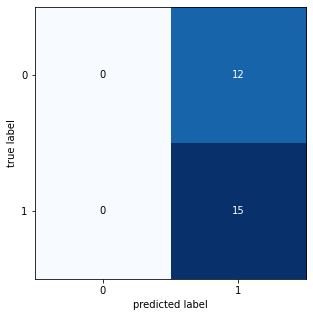

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.51746470200305
gen terbaik : [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.42668067226890755  || Akurasi terbaik : 0.5216931216931217  || jumlah fitur : 56

Generation : 1
gene : [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


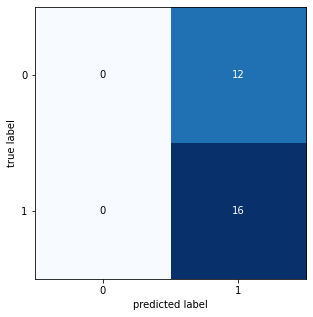

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

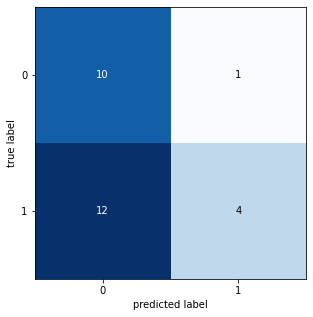

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

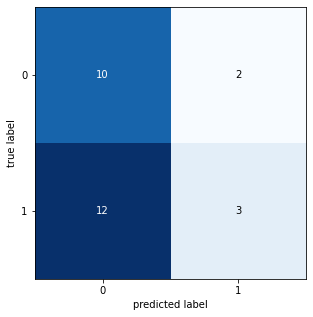

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

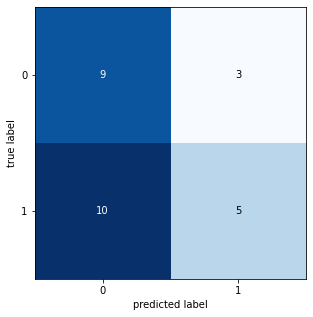

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

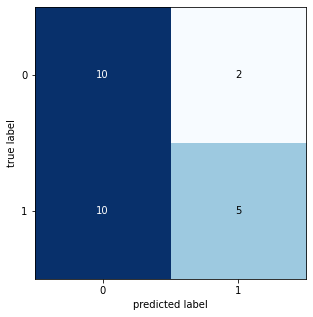

avg accuraccy Prostate Cancer =  0.5291005291005291
avg F1_Score Prostate Cancer =  0.469749423293479
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.36363636363636365
Running Time:  38.569588985003065
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


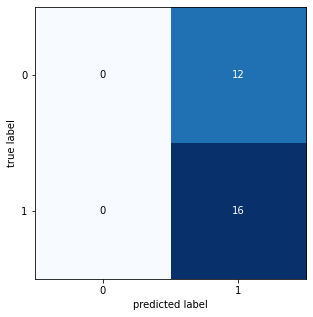

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

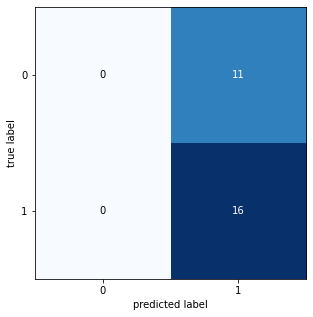

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

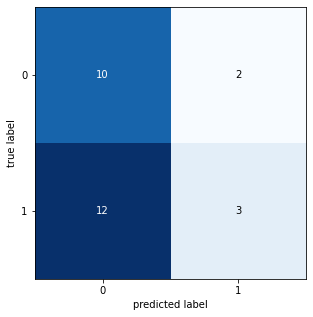

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

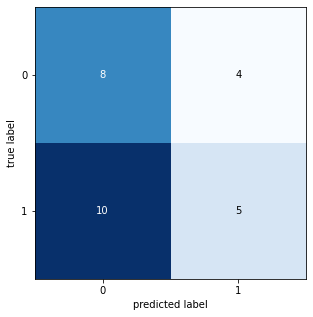

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

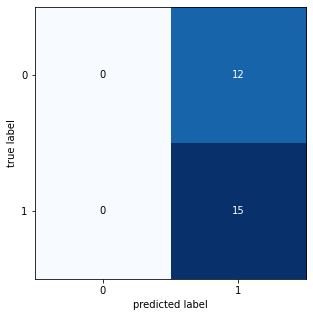

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  40.29021661700244
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


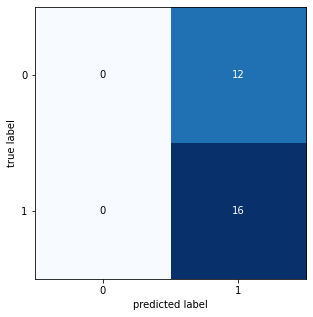

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

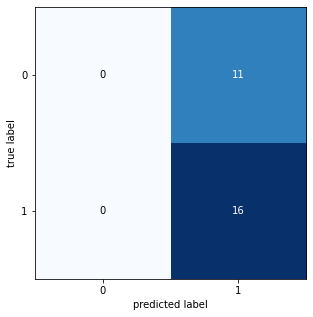

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

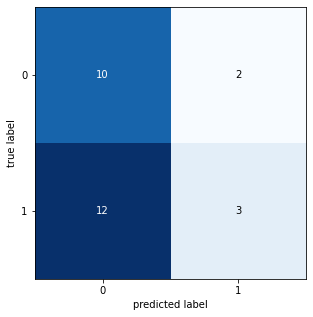

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

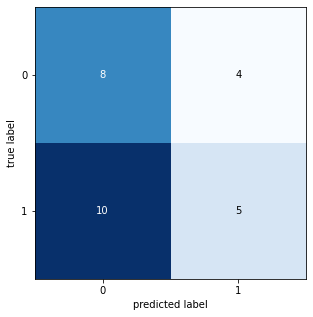

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

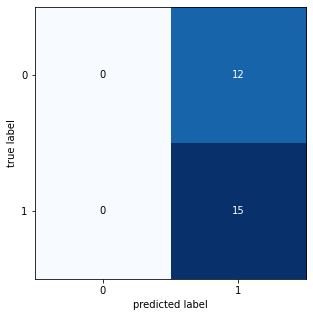

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.996500193999964
gene : [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


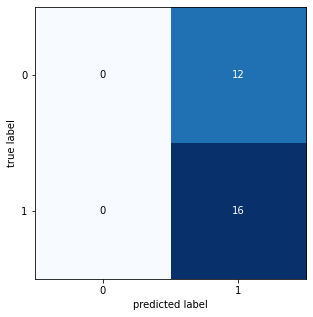

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

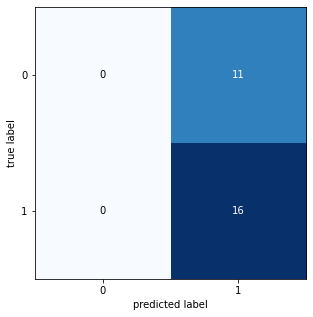

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

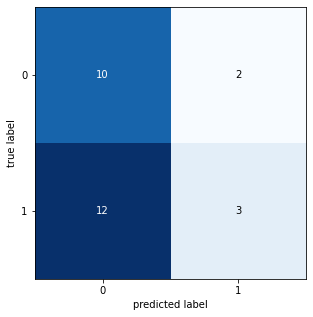

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

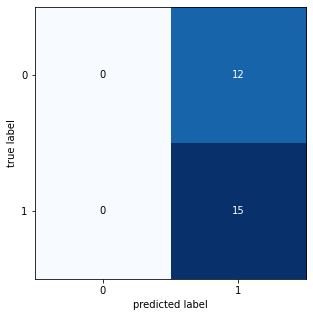

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

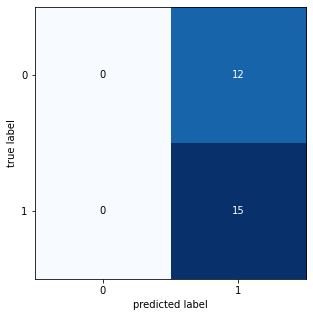

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.37882654964734314
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.20581456000218
gene : [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


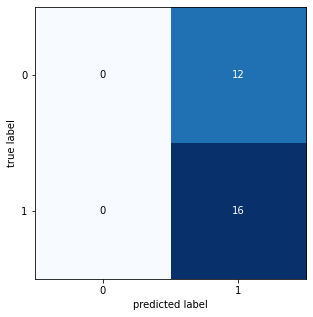

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

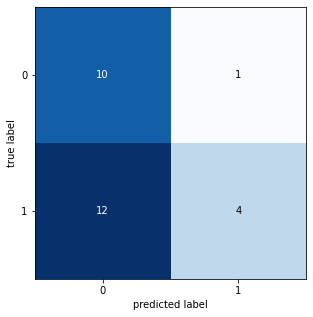

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

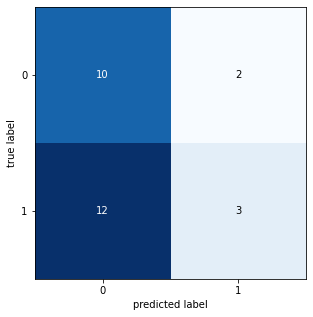

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

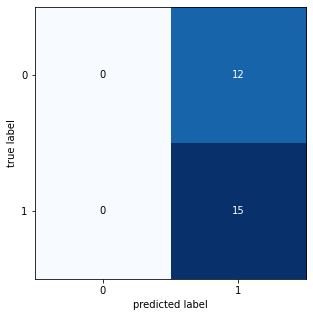

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

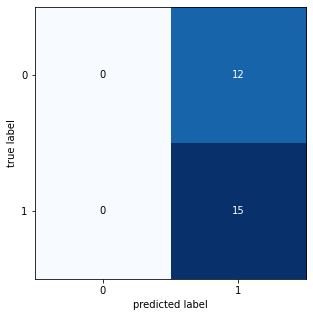

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.40310924369747897
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.80706199199631
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


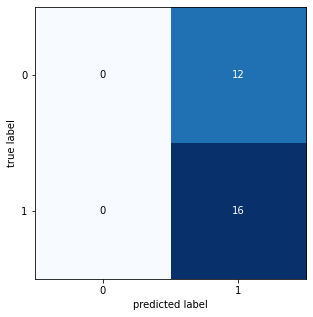

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.6666666666666666
F1_Score :  0.5440900562851783
              precision    recall  f1-score   support

           0     

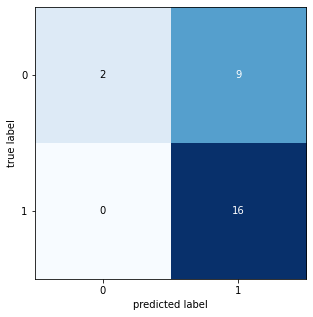

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

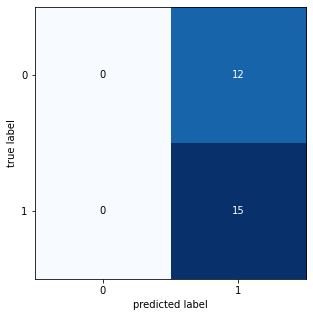

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

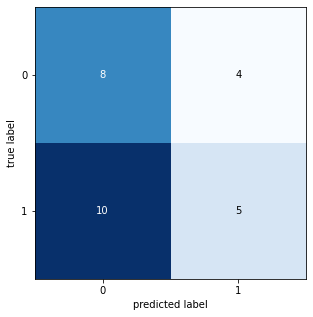

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

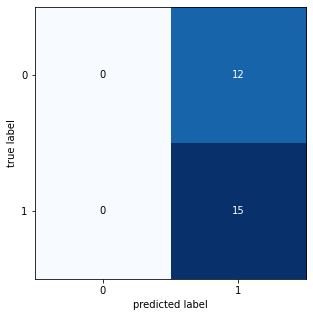

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.41940242684145124
max accuraccy Prostate Cancer =  0.6666666666666666
max F1_Score Prostate Cancer =  0.5440900562851783
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.228048388999014
gene : [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


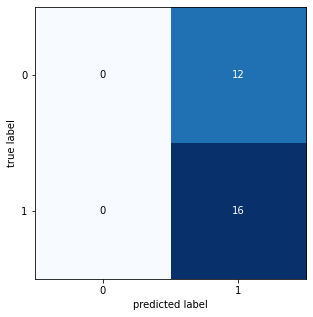

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

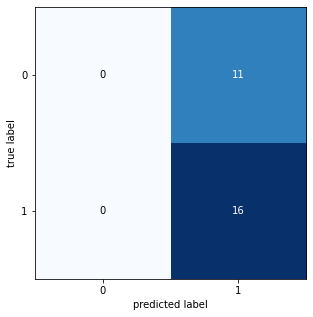

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

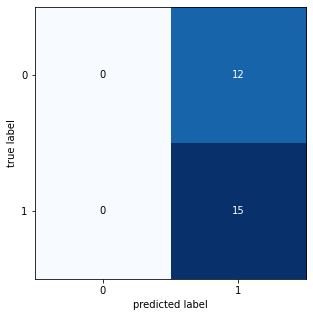

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

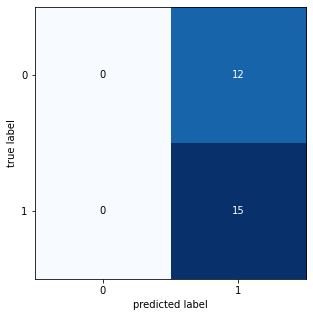

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

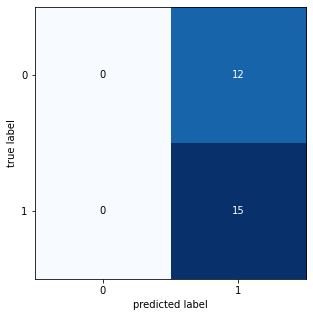

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.1777913459955
gene : [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


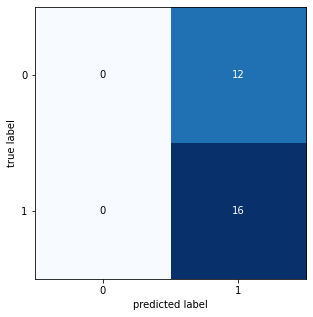

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

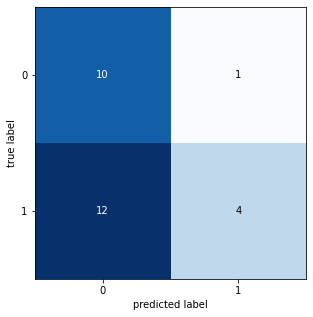

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

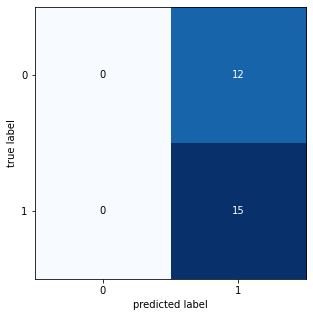

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

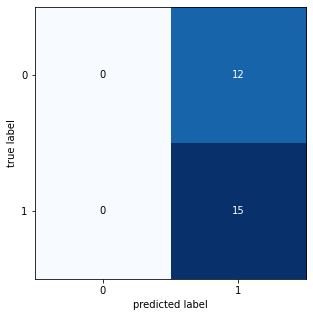

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

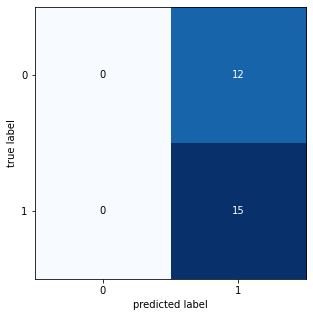

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.03209927599528
gene : [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


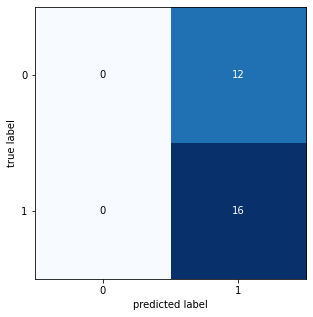

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

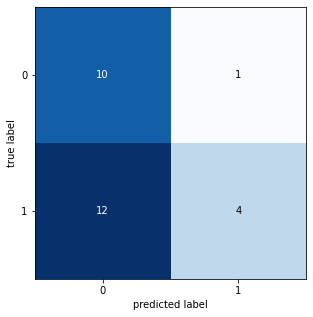

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

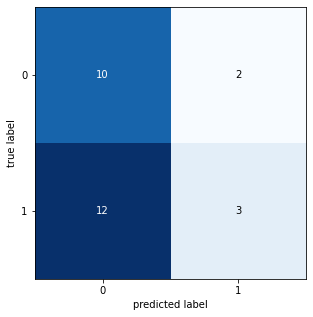

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6296296296296297
F1_Score :  0.5178571428571428
              precision    recall  f1-score   support

           0     

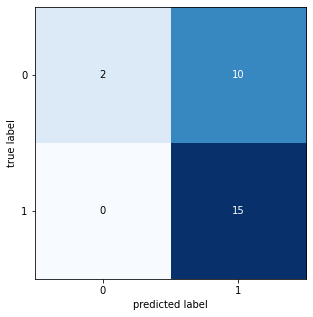

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

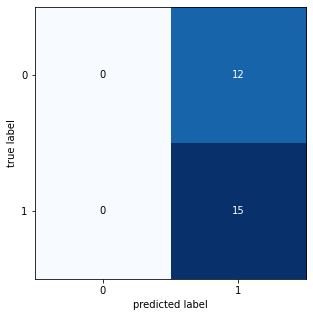

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.4352521008403361
max accuraccy Prostate Cancer =  0.6296296296296297
max F1_Score Prostate Cancer =  0.5178571428571428
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.825291618995834
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


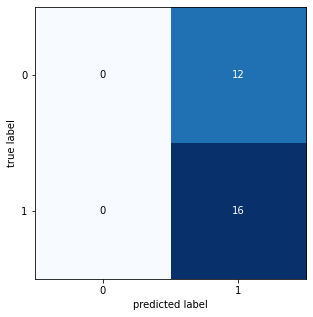

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

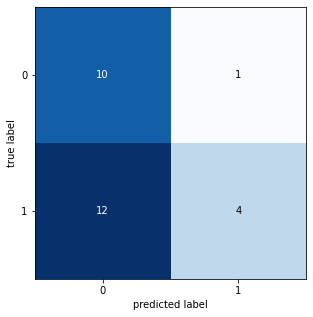

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

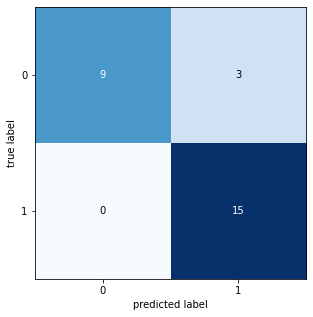

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.4214285714285715
              precision    recall  f1-score   support

           0     

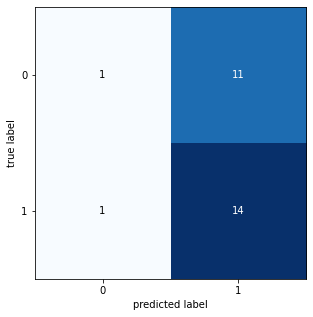

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

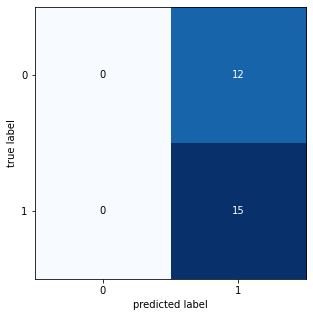

avg accuraccy Prostate Cancer =  0.6179894179894179
avg F1_Score Prostate Cancer =  0.5037662337662338
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8831168831168831
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.728057766005804
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.5037662337662338  || Akurasi terbaik : 0.6179894179894179  || jumlah fitur : 50

Generation : 2
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


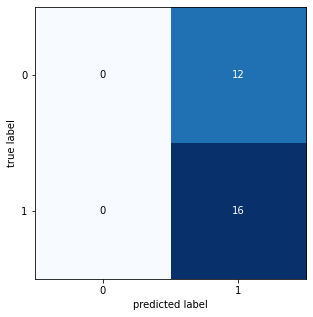

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

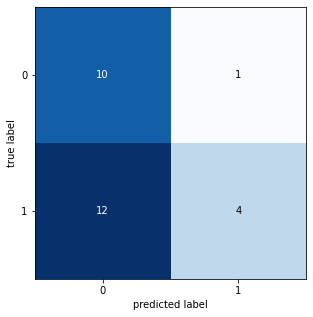

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

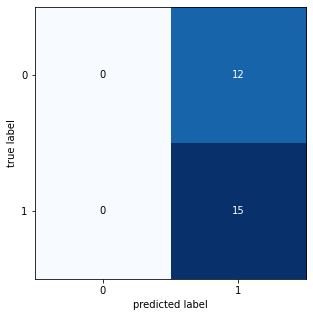

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

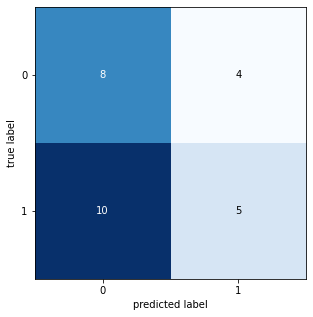

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

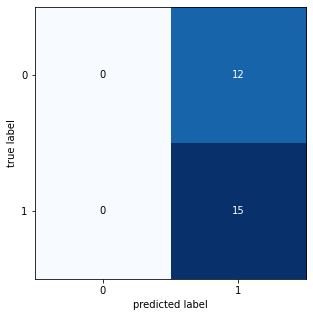

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.92290075200435
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


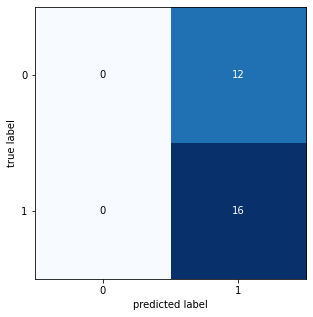

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

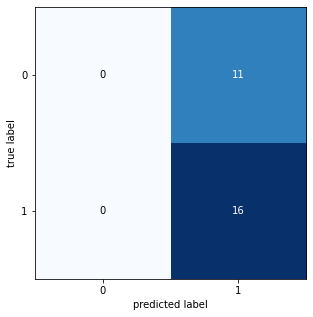

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

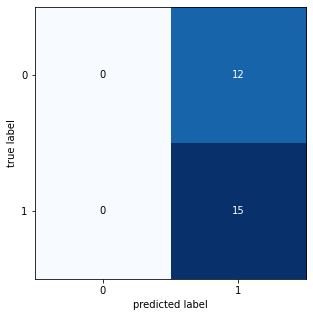

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

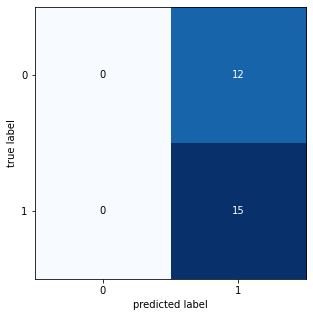

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

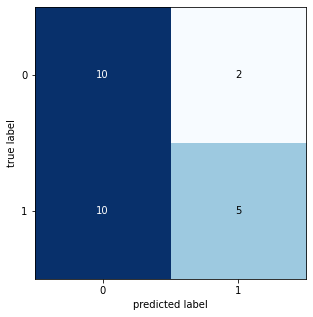

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.39795756569012386
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.70033396499639
gene : [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


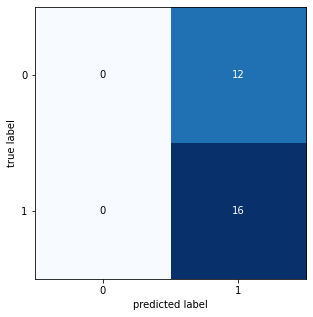

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

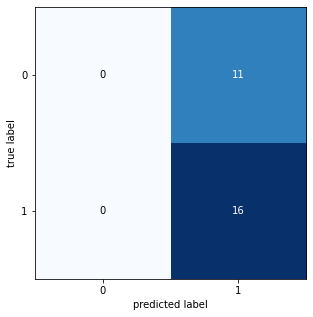

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

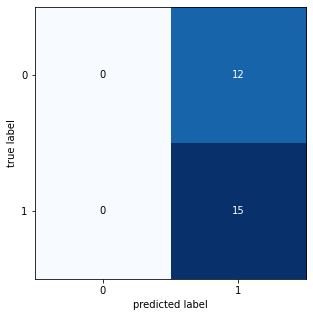

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5185185185185185
F1_Score :  0.5077138849929874
              precision    recall  f1-score   support

           0     

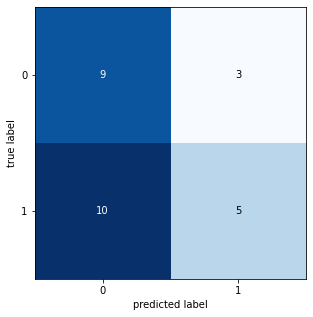

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

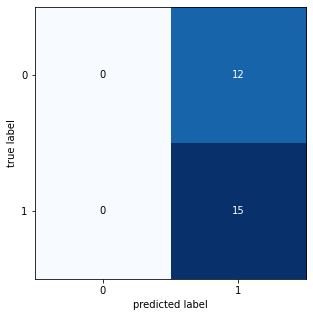

avg accuraccy Prostate Cancer =  0.5587301587301587
avg F1_Score Prostate Cancer =  0.3915457972341759
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5077138849929874
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.129129207001824
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


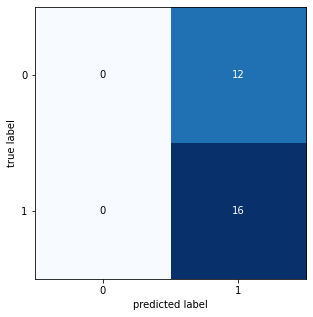

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

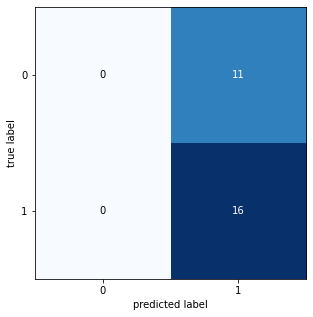

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

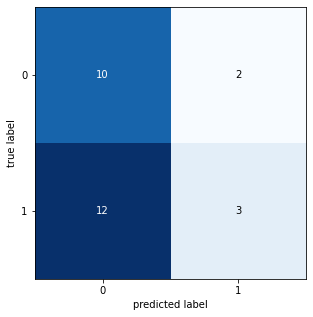

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.6666666666666666
F1_Score :  0.5846153846153846
              precision    recall  f1-score   support

           0     

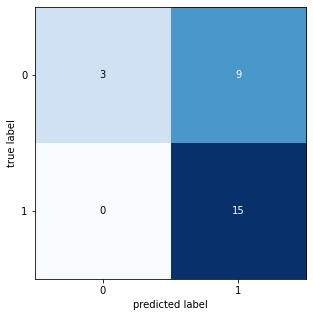

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

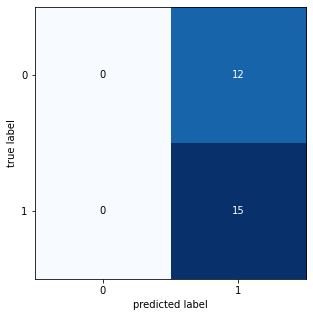

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.42432105514184865
max accuraccy Prostate Cancer =  0.6666666666666666
max F1_Score Prostate Cancer =  0.5846153846153846
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.7095069240022
gene : [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


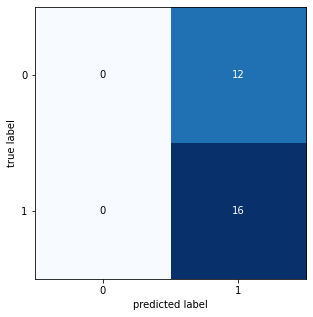

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

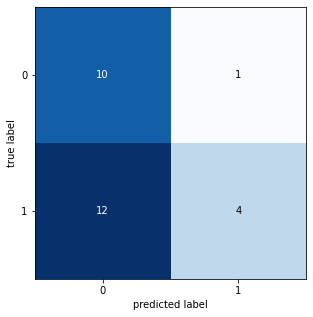

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

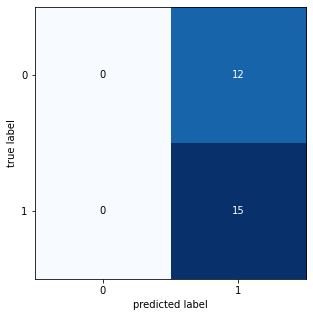

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

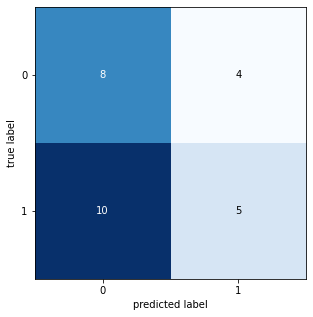

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

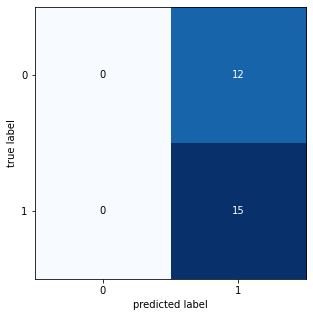

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.32959271299478
gene : [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


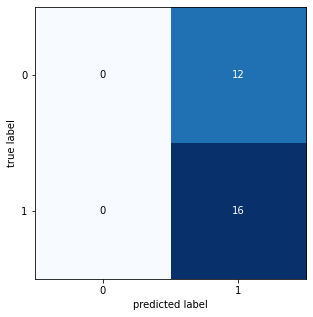

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

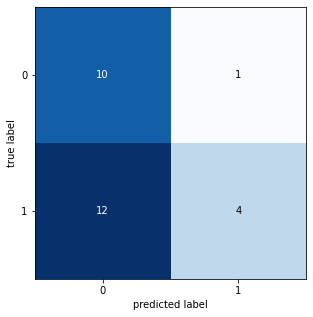

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

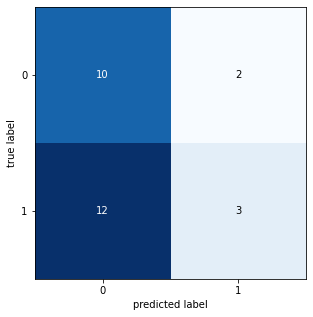

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

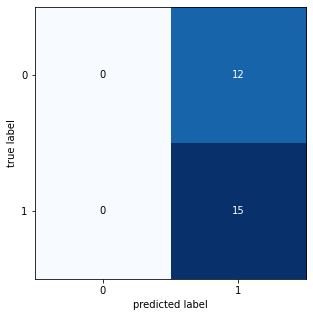

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

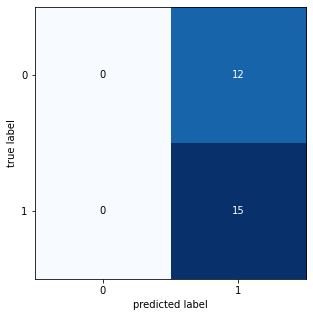

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.40310924369747897
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.8676468190024
gene : [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


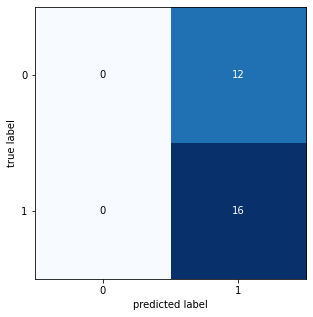

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

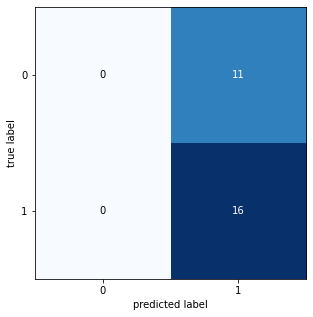

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

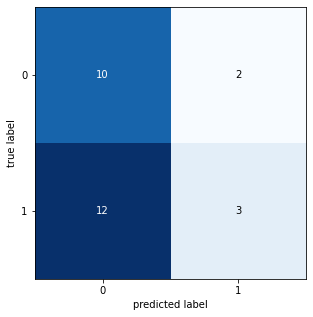

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

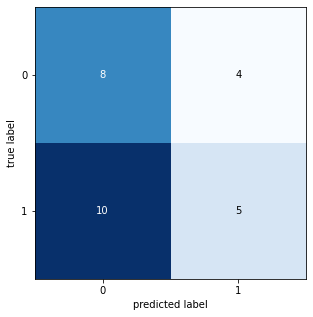

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

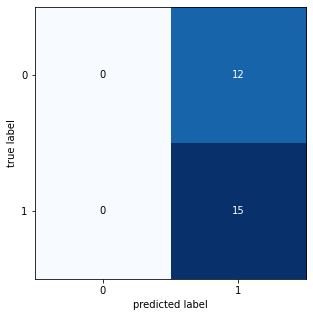

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.6741660290063
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


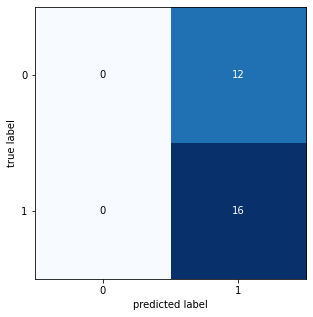

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

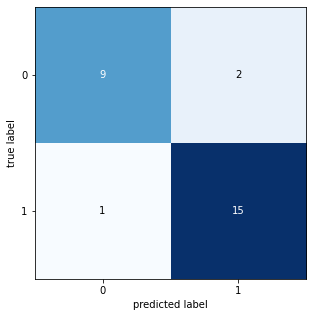

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

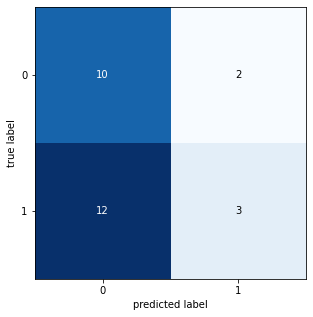

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

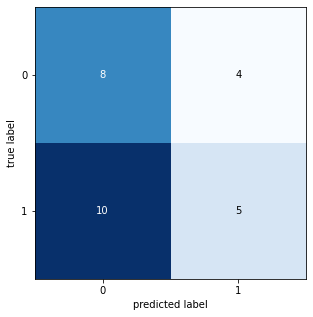

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

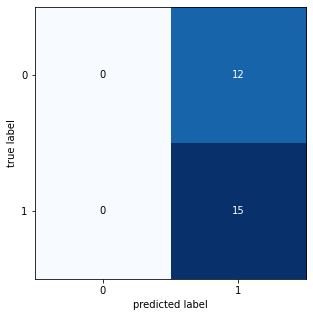

avg accuraccy Prostate Cancer =  0.5957671957671957
avg F1_Score Prostate Cancer =  0.5046027501909854
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8831168831168832
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.586431488001836
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


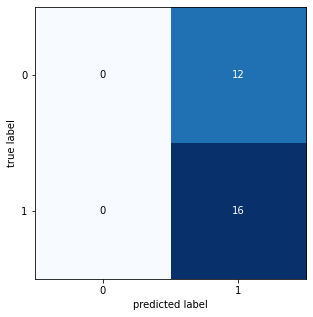

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

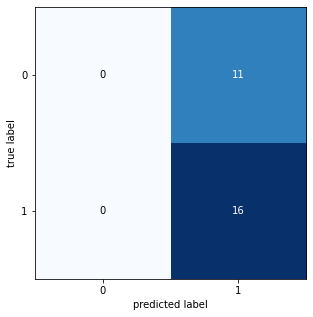

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

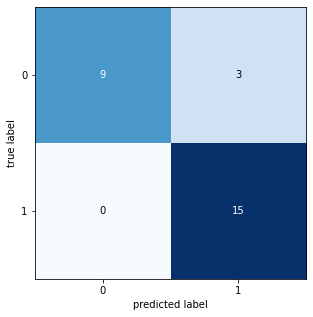

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

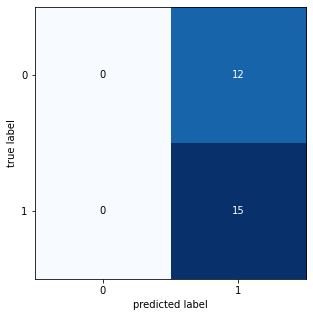

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

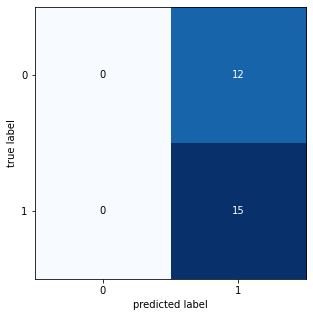

avg accuraccy Prostate Cancer =  0.6328042328042327
avg F1_Score Prostate Cancer =  0.46662639685895496
max accuraccy Prostate Cancer =  0.8888888888888888
max F1_Score Prostate Cancer =  0.8831168831168831
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.20717984699877
gene : [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


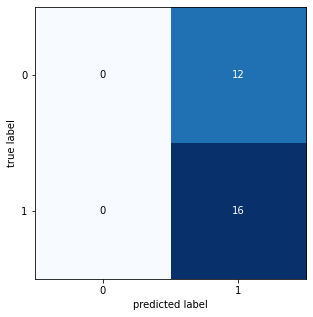

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

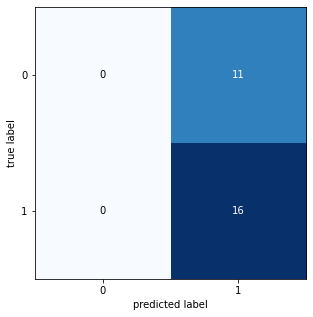

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

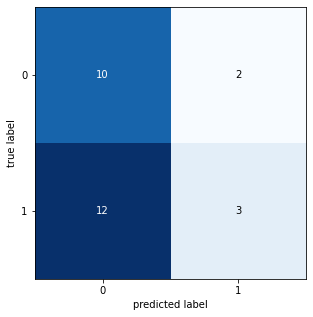

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

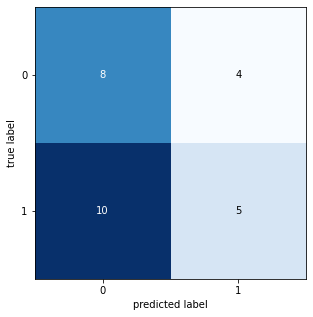

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

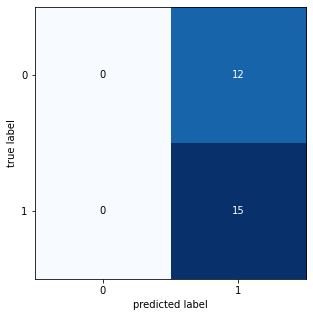

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.086044538998976
gen terbaik : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.5046027501909854  || Akurasi terbaik : 0.5957671957671957  || jumlah fitur : 54

Generation : 3
gene : [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


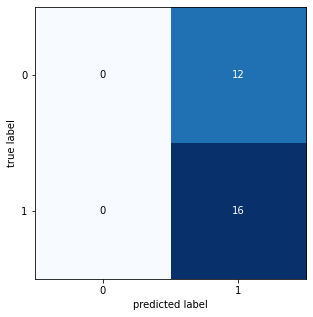

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

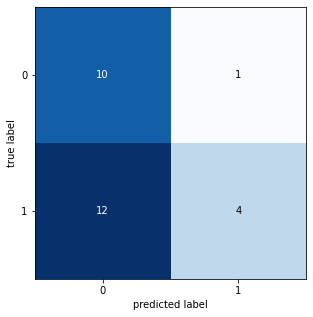

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

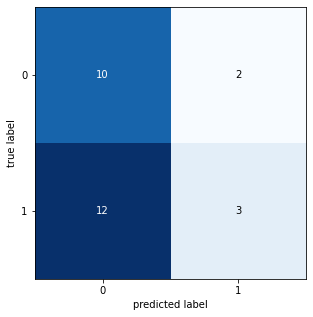

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

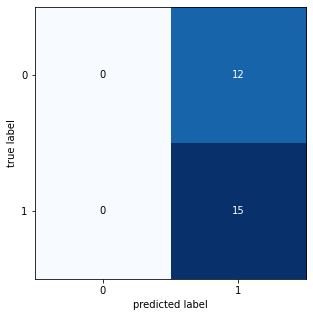

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

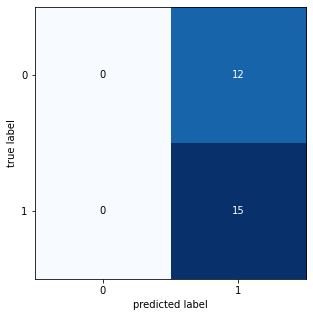

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.40310924369747897
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.33693079999648
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


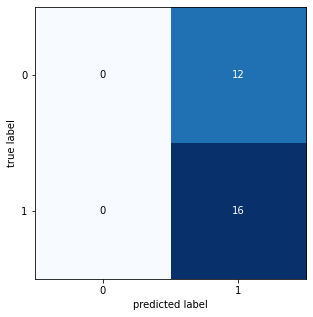

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

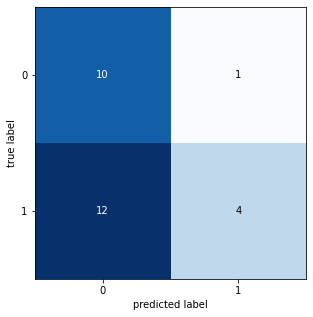

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

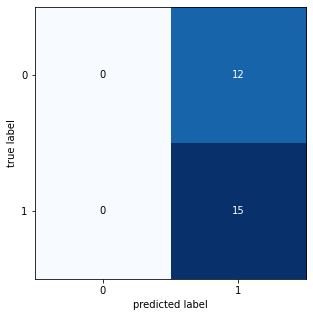

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

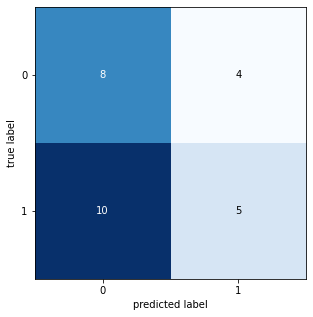

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

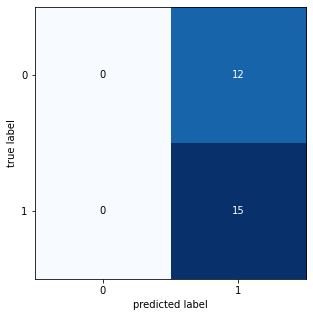

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.79412084800424
gene : [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


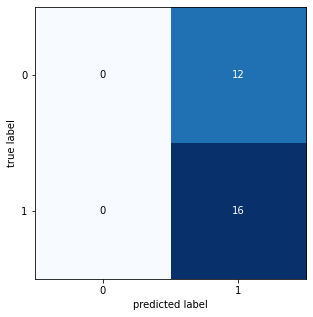

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

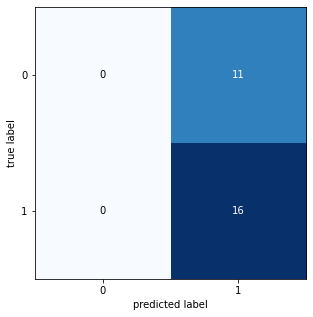

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

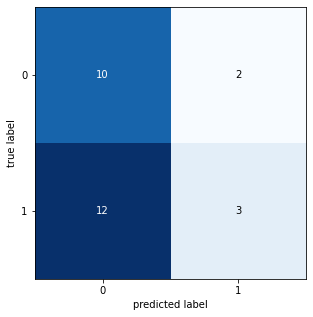

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

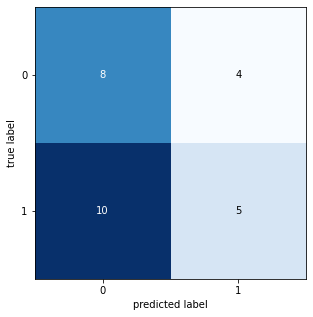

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

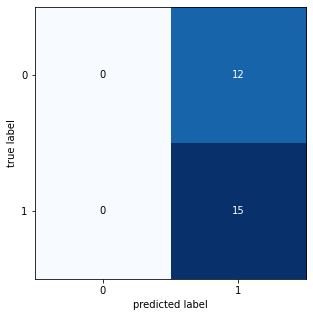

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.81495366600575
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


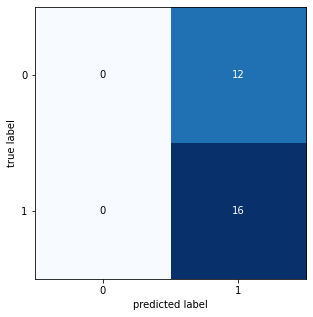

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

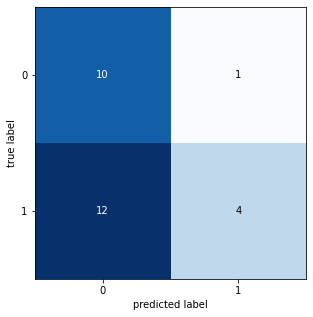

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

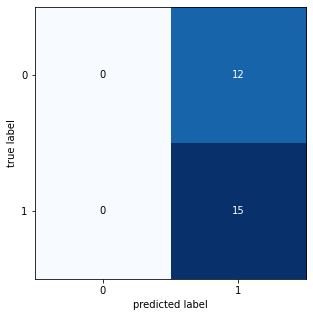

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

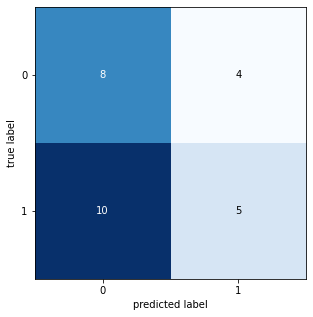

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

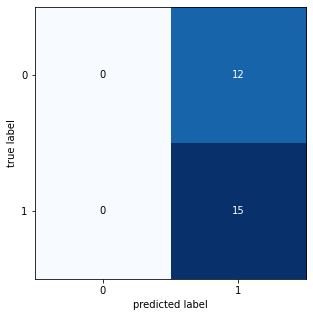

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.964762095005426
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 1

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


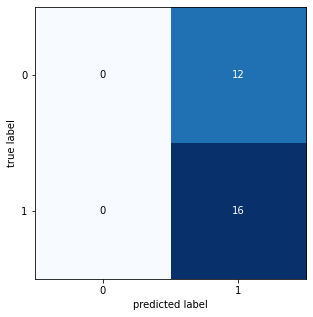

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

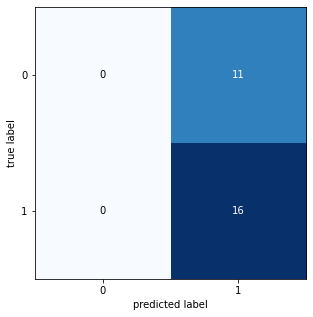

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

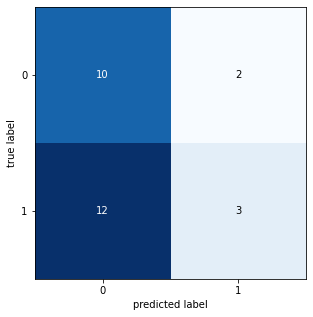

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

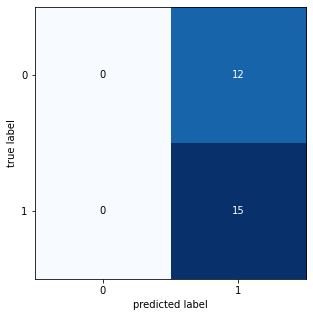

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

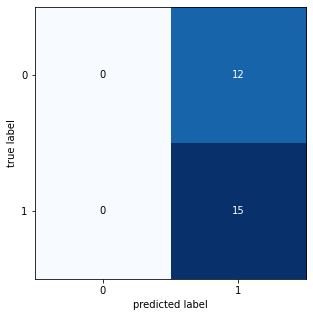

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.37882654964734314
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.56155370500346
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


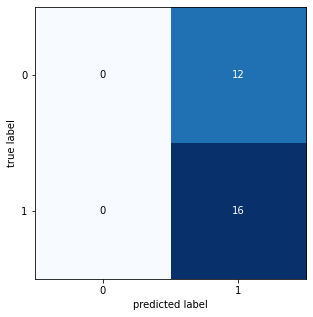

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

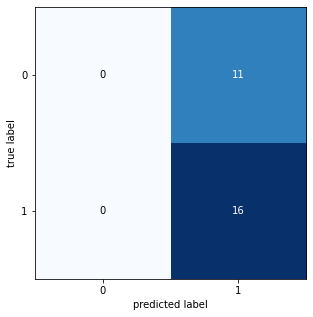

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

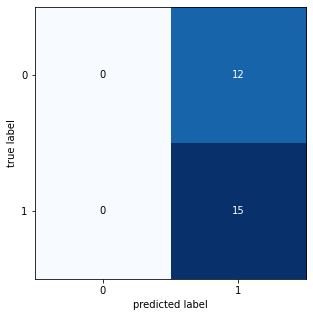

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

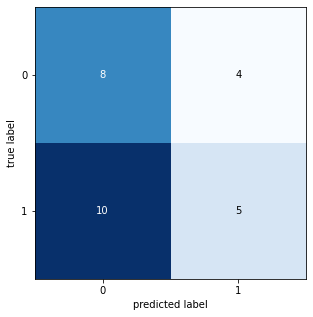

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

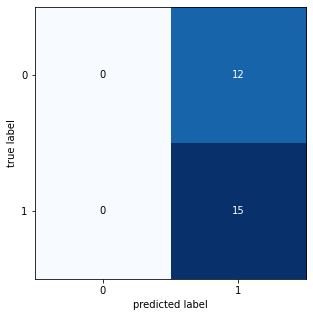

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3850030202355784
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.025508933998935
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


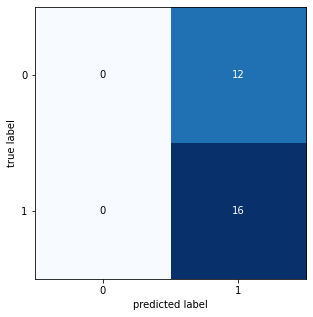

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

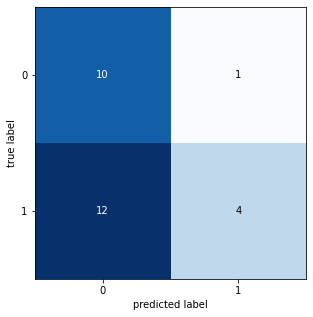

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

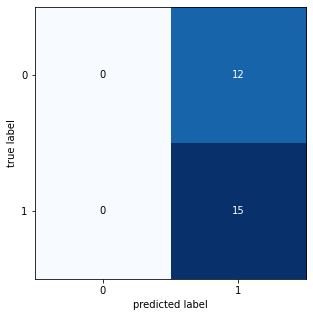

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

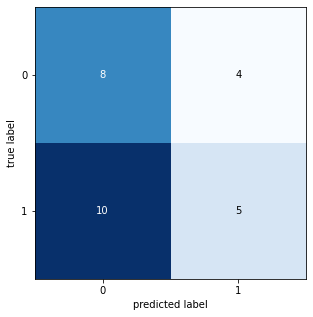

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

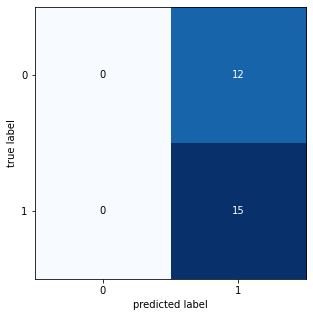

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.00972251400526
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


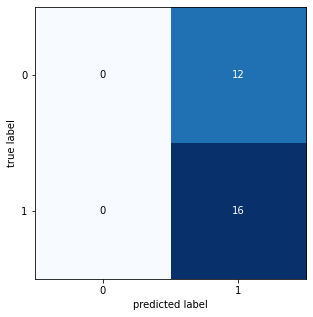

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

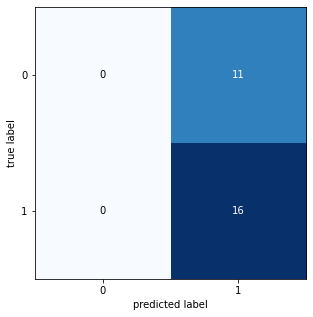

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

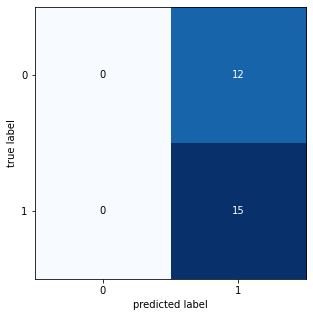

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5925925925925926
F1_Score :  0.4427767354596623
              precision    recall  f1-score   support

           0     

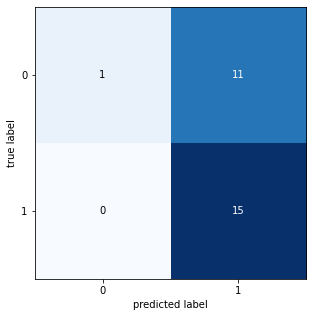

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

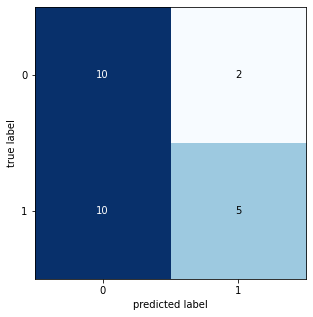

avg accuraccy Prostate Cancer =  0.5735449735449736
avg F1_Score Prostate Cancer =  0.41508434135348493
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.42437802600034
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


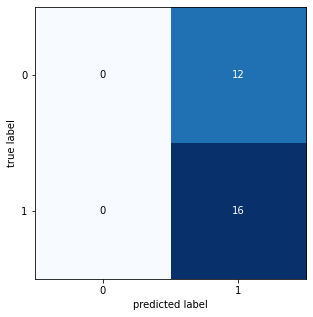

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

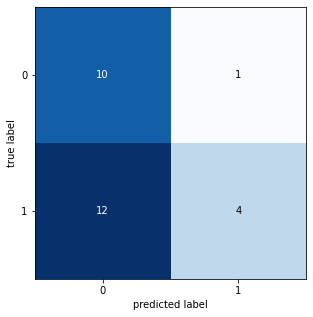

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

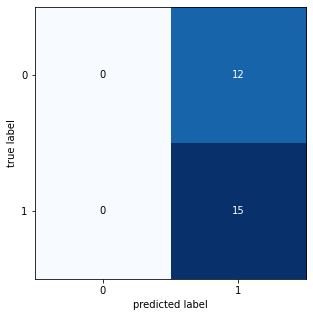

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

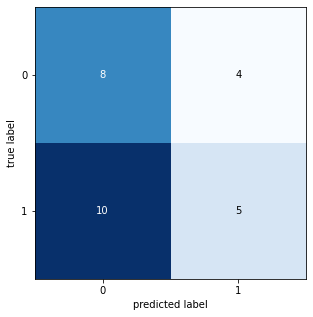

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

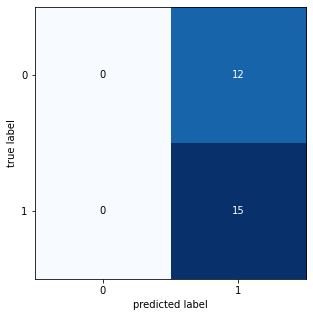

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.40928571428571436
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.52464378500008
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


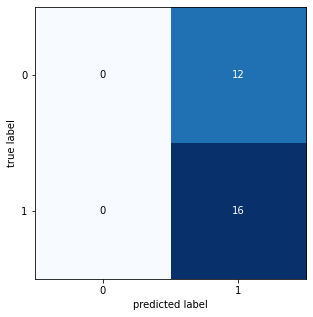

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

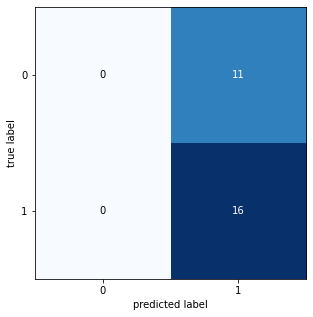

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

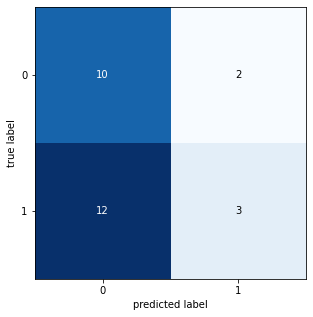

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

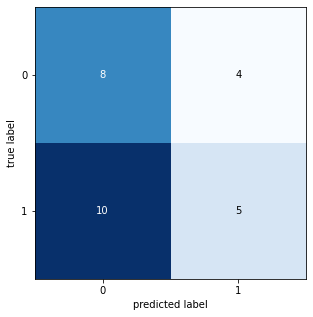

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

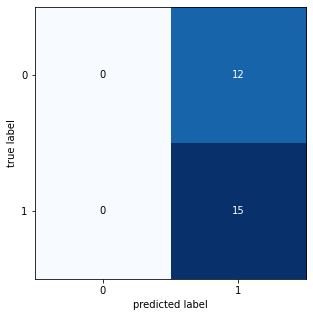

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.20946840100078
gen terbaik : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.5046027501909854  || Akurasi terbaik : 0.5957671957671957  || jumlah fitur : 54

Generation : 4
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


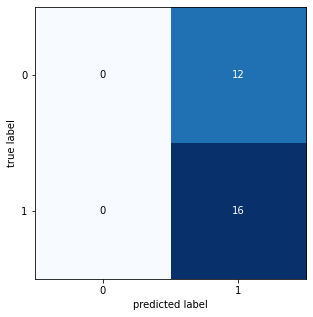

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

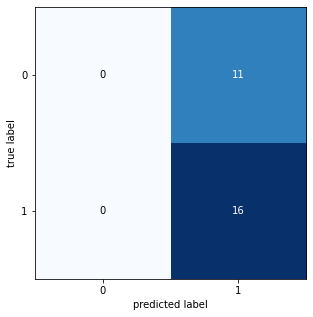

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

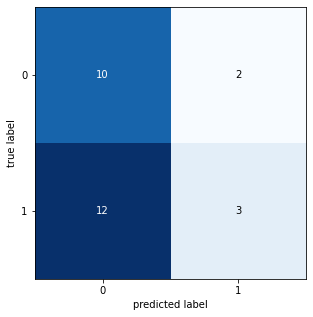

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

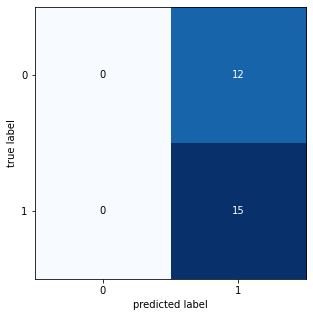

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

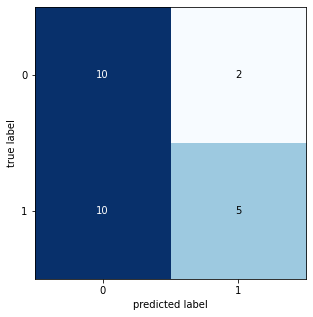

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.4153525236733172
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.18307699599973
gene : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


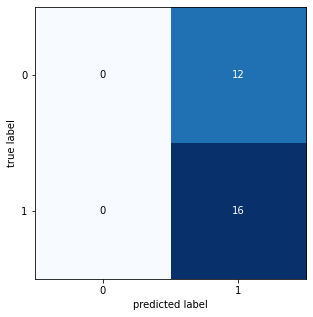

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

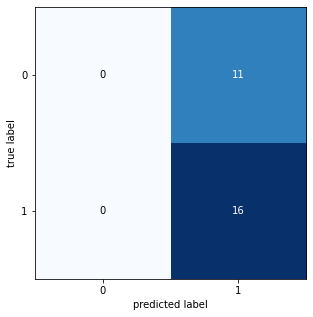

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

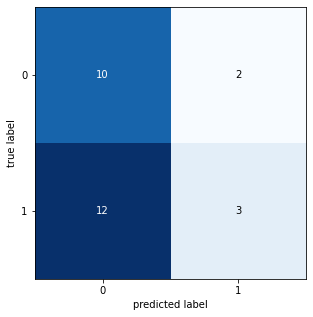

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

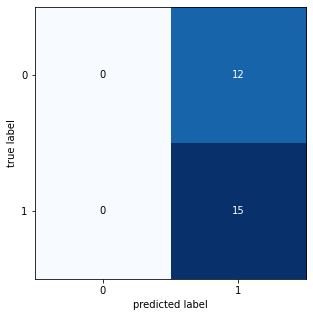

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

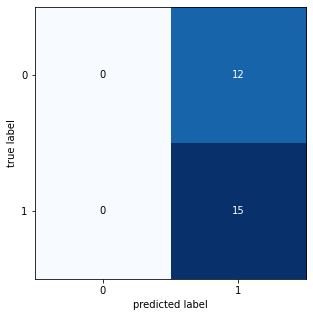

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.37882654964734314
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.89076685500186
gene : [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


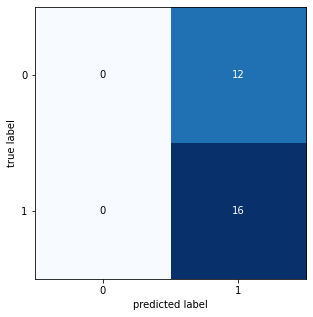

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

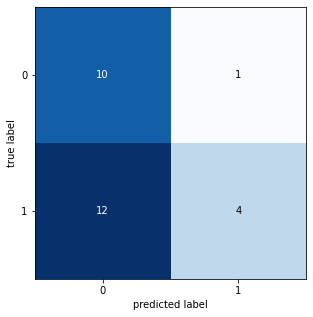

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

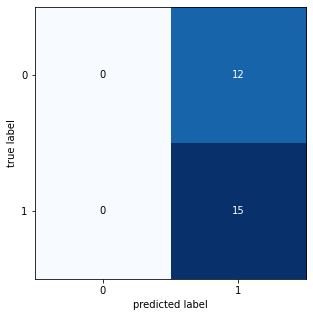

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

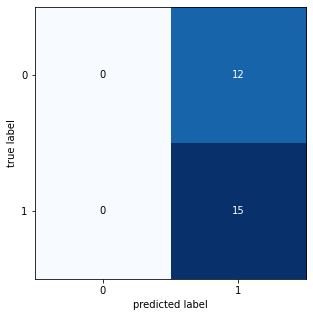

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

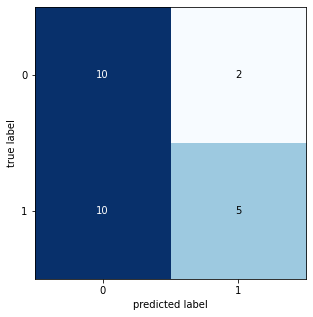

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.42224025974025975
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.715160997002386
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


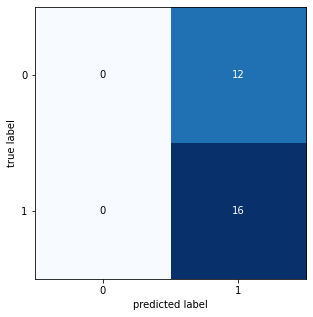

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

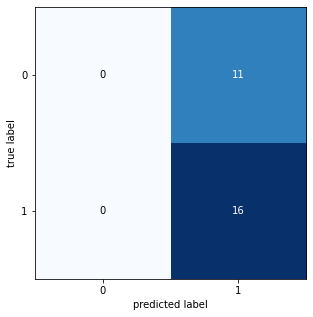

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

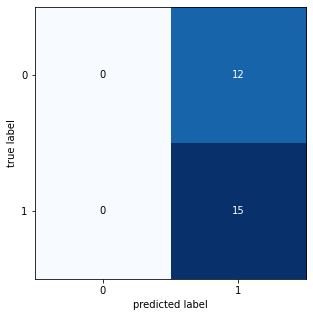

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

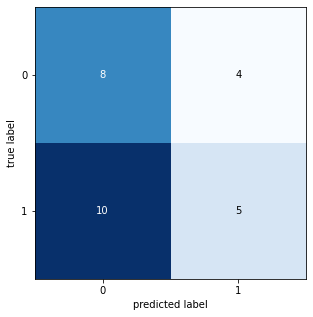

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

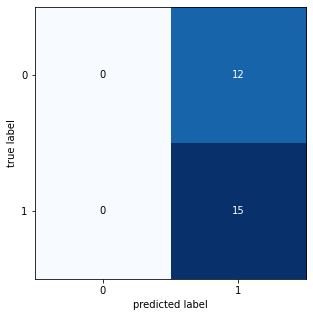

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3850030202355784
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.978040105997934
gene : [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


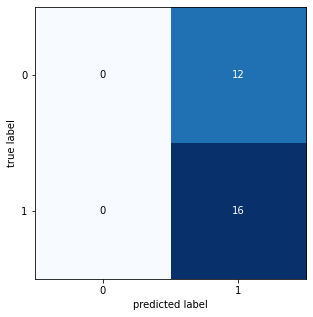

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

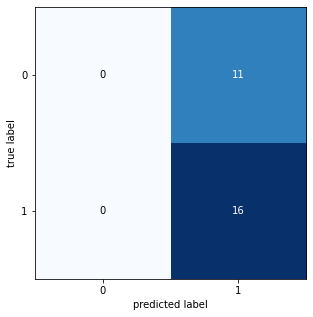

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

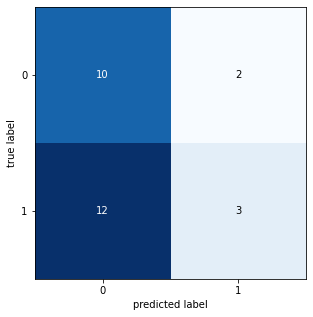

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

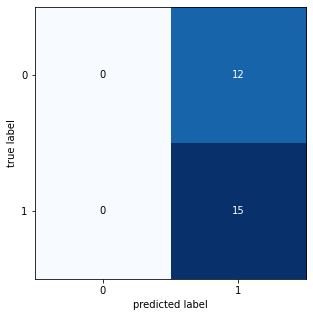

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

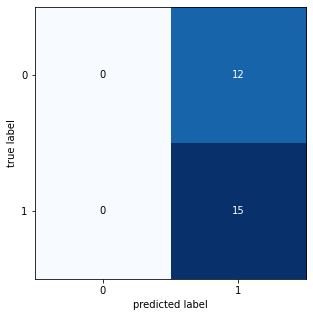

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.37882654964734314
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.4441176470588235
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  36.97284418399795
gene : [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


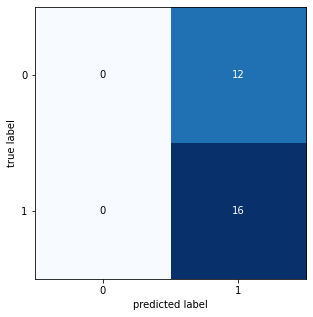

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

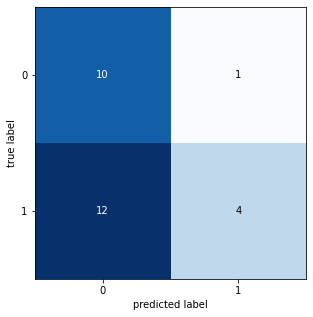

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

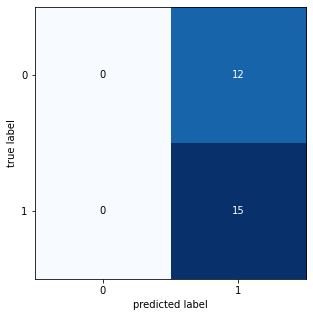

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

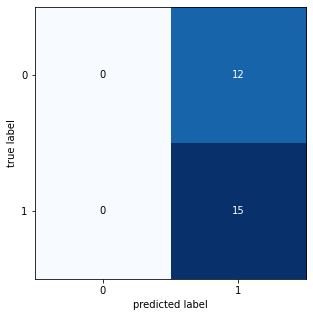

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

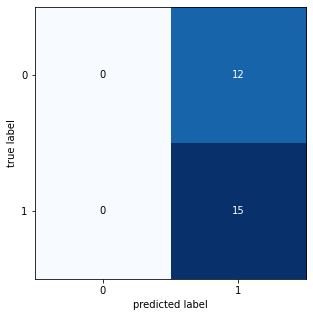

avg accuraccy Prostate Cancer =  0.5513227513227512
avg F1_Score Prostate Cancer =  0.3857142857142858
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.5185185185185185
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  39.64389087600284
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


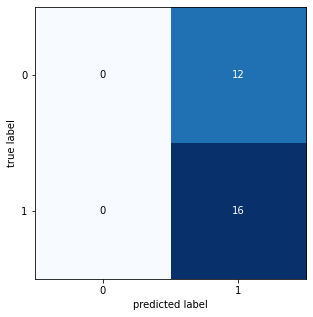

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

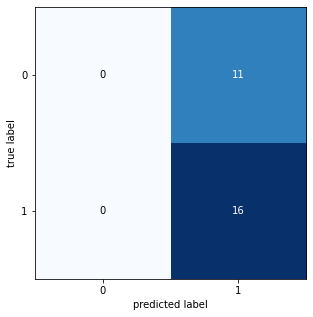

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

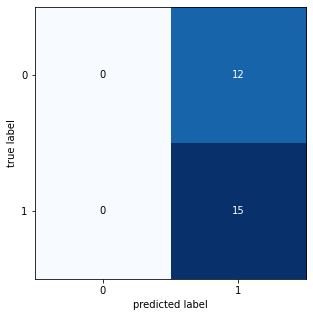

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

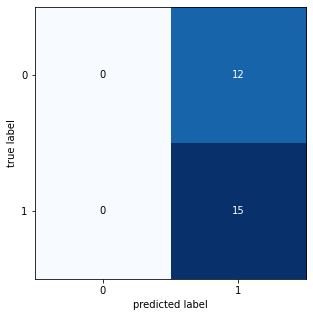

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

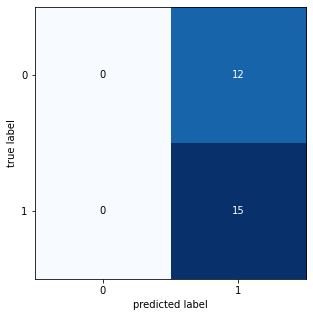

avg accuraccy Prostate Cancer =  0.5661375661375662
avg F1_Score Prostate Cancer =  0.36143159166414984
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.37209302325581395
min accuraccy Prostate Cancer =  0.5555555555555556
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.36504865800089
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


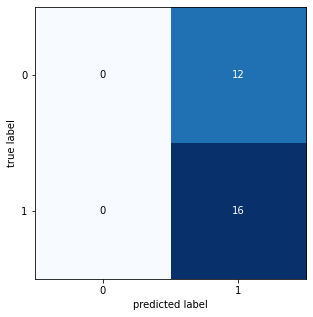

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5185185185185185
F1_Score :  0.4935064935064935
              precision    recall  f1-score   support

           0     

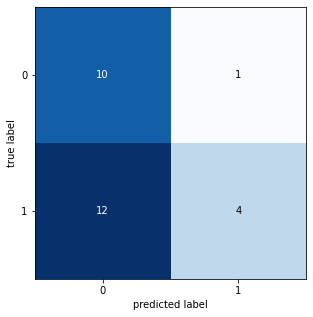

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

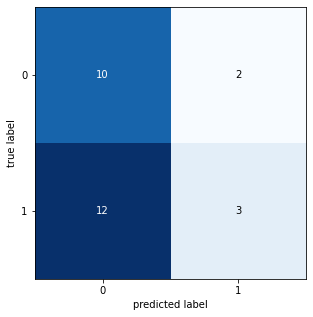

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

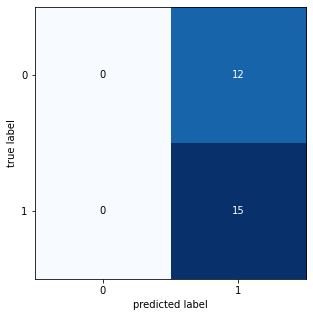

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

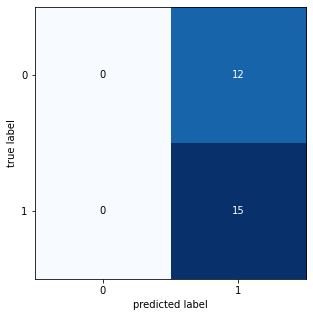

avg accuraccy Prostate Cancer =  0.5365079365079364
avg F1_Score Prostate Cancer =  0.40310924369747897
max accuraccy Prostate Cancer =  0.5714285714285714
max F1_Score Prostate Cancer =  0.4935064935064935
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  35.95484370399936
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 10

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


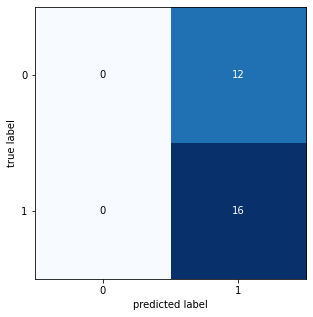

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

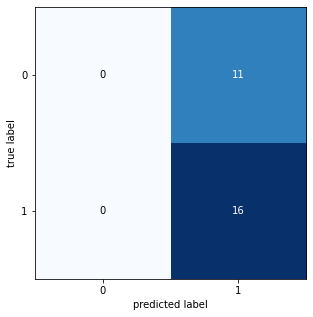

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.4444444444444444
F1_Score :  0.4155844155844156
              precision    recall  f1-score   support

           0     

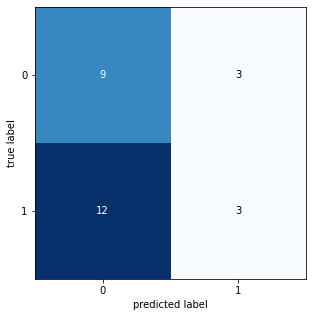

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

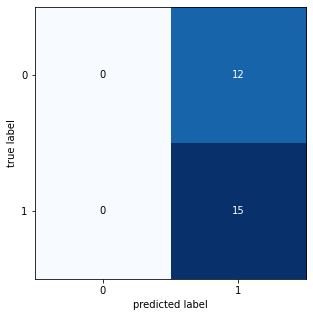

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.5397727272727273
              precision    recall  f1-score   support

           0     

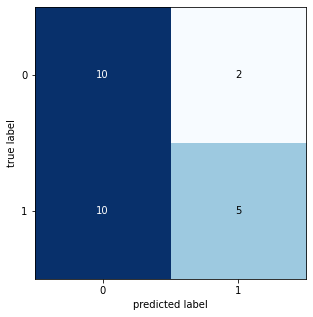

avg accuraccy Prostate Cancer =  0.5439153439153438
avg F1_Score Prostate Cancer =  0.4096458773784356
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.5397727272727273
min accuraccy Prostate Cancer =  0.4444444444444444
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  38.519555121005396
gene : [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


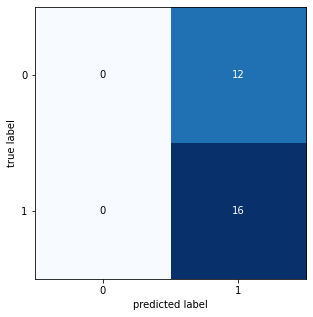

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.5925925925925926
F1_Score :  0.37209302325581395
              precision    recall  f1-score   support

           0    

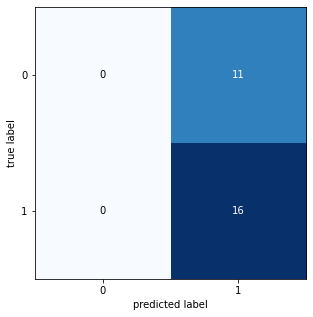

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.4441176470588235
              precision    recall  f1-score   support

           0    

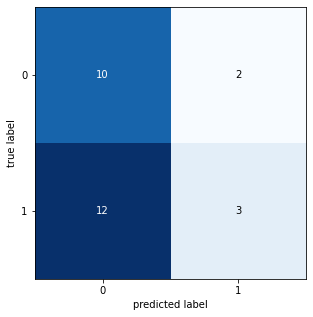

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.48148148148148145
F1_Score :  0.475
              precision    recall  f1-score   support

           0       0.44      

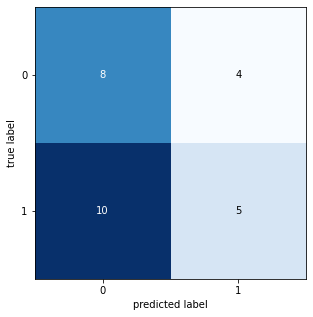

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.5555555555555556
F1_Score :  0.35714285714285715
              precision    recall  f1-score   support

           0    

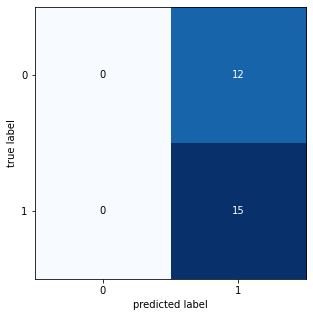

avg accuraccy Prostate Cancer =  0.5365079365079366
avg F1_Score Prostate Cancer =  0.4023979782187717
max accuraccy Prostate Cancer =  0.5925925925925926
max F1_Score Prostate Cancer =  0.475
min accuraccy Prostate Cancer =  0.48148148148148145
min F1_Score Prostate Cancer =  0.35714285714285715
Running Time:  37.55859530499583
gen terbaik : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.5046027501909854  || Akurasi terbaik : 0.5957671957671957  || jumlah fitur : 54

Running Time:  1909.553021448999


In [15]:
Prostate_IG_GA = GeneticAlgorithm(Prostate_IG, 4)